## Model Version 1
- Income estimator by 3 models: RF, lightgbm, and XGBoost
- Random Forest regression as baseline
- noises, feature engineering, and hyperparameter tuning
- MLflow for model tracking and management


## Notes to avoid dataleakage:
### Recommended Flow to Avoid Data Leakage
1. Define Target (ensure no future info is used).
2. Split Data (train/test/validation as appropriate, chronologically for time series).

3. Feature Engineering & Preprocessing:
    - Fit any data transformations/statistics only on the training data.
    - Apply parameters/transformers from train to test.
    - First, split your raw data into training, validation, and test sets.
    - Then, fit your imputation technique (such as mean, median, KNN, MICE, etc.) only on the training set—this means you  use only the training data to calculate statistics or to fit any model for imputation.

Finally, apply the same fitted imputation parameters to the validation and test sets.

4. Model Development, Validation, Testing:
    - Proceed only after strict separation is established.

5. Document all processing steps and audit for unintentional "peeking" (e.g., did any engineered feature access information unavailable at prediction time?).

### Key Takeaways
- Do not perform feature engineering or data transformations before splitting data. This is the main route to leakage in most workflows.

- Always fit transformations on train, apply to test.

- Meticulously audit every step for subtle leaks (e.g., forward-looking technical indicators, improperly joined external data).

In [1]:
# CELL 1: Import Libraries and Setup
# ============================================================================
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

print("=" * 60)
print("DATA PREPROCESSING PIPELINE - STARTED")
print("=" * 60)

DATA PREPROCESSING PIPELINE - STARTED


In [2]:
# Code to create a new dataset excluding already worked features
import pandas as pd

# Load the original dataset
data_path = r'C:\Users\david\OneDrive\Documents\augment-projects\caja-de-ahorros\data\processed'
df_original = pd.read_csv(data_path + '/df_clientes_clean.csv')

print(f"Original dataset shape: {df_original.shape}")
print(f"Original columns: {list(df_original.columns)}")

# Define the features that have already been worked on (to exclude)
already_worked_features = [
    'segmento',
    'edad', 
    'sexo',
    'ciudad',
    'pais',
    'ocupacion',
    'estado_civil',
    'nombreempleadorcliente',
    'cargoempleocliente',
    'productos_activos'
]

print(f"\nFeatures to exclude (already worked): {already_worked_features}")

# Define columns to keep
# Keep ID columns, target variable, and features that haven't been worked on yet
columns_to_keep = [
    # ID columns
    'cliente',
    'identificador_unico',
    
    # Target variable
    'ingresos_reportados',
    
    # Features NOT yet worked on
    'fechaingresoempleo',
    'letras_mensuales',
    'monto_letra', 
    'saldo',
    'fecha_inicio',
    'fecha_vencimiento',
    'ocupacion_consolidated',
    'ciudad_consolidated',
    'nombreempleadorcliente_consolidated',
    'cargoempleocliente_consolidated',
    'sexo_consolidated',
    'estado_civil_consolidated',
    'pais_consolidated',
    'missing_fechaingresoempleo',
    'missing_nombreempleadorcliente',
    'missing_cargoempleocliente',
    'is_retired',
    'age_group',
    'payment_to_income_ratio'
]

print(f"\nColumns to keep: {columns_to_keep}")

# Create new dataset with only unworked features
df_unworked = df_original[columns_to_keep].copy()

print(f"\nNew dataset shape: {df_unworked.shape}")
print(f"Features excluded: {len(already_worked_features)}")
print(f"Features remaining: {df_unworked.shape[1] - 3}")  # Subtract ID columns and target

# Display first few rows
print(f"\nFirst 5 rows of new dataset:")
print(df_unworked.head())

# Save the new dataset
output_filename = 'df_unworked_features.csv'
df_unworked.to_csv(data_path + '/' + output_filename, index=False)
print(f"\n✅ New dataset saved as: {output_filename}")

# Summary
print(f"\n📊 SUMMARY:")
print(f"  - Original features: {df_original.shape[1]}")
print(f"  - Excluded features: {len(already_worked_features)}")
print(f"  - Remaining features: {len(columns_to_keep) - 3}")  # Subtract ID + target
print(f"  - ID columns: 2 (cliente, identificador_unico)")
print(f"  - Target variable: 1 (ingresos_reportados)")
print(f"  - Total columns in new dataset: {df_unworked.shape[1]}")

Original dataset shape: (15000, 32)
Original columns: ['cliente', 'identificador_unico', 'segmento', 'edad', 'sexo', 'ciudad', 'pais', 'ocupacion', 'estado_civil', 'fechaingresoempleo', 'nombreempleadorcliente', 'cargoempleocliente', 'productos_activos', 'letras_mensuales', 'monto_letra', 'saldo', 'fecha_inicio', 'fecha_vencimiento', 'ingresos_reportados', 'ocupacion_consolidated', 'ciudad_consolidated', 'nombreempleadorcliente_consolidated', 'cargoempleocliente_consolidated', 'sexo_consolidated', 'estado_civil_consolidated', 'pais_consolidated', 'missing_fechaingresoempleo', 'missing_nombreempleadorcliente', 'missing_cargoempleocliente', 'is_retired', 'age_group', 'payment_to_income_ratio']

Features to exclude (already worked): ['segmento', 'edad', 'sexo', 'ciudad', 'pais', 'ocupacion', 'estado_civil', 'nombreempleadorcliente', 'cargoempleocliente', 'productos_activos']

Columns to keep: ['cliente', 'identificador_unico', 'ingresos_reportados', 'fechaingresoempleo', 'letras_mensuales

In [3]:
df=df_original.copy()

In [4]:
# STEP 1: Handle Missing Values
# ============================================================================
print("=" * 60)
print("STEP 1: HANDLING MISSING VALUES")
print("=" * 60)

# Check current missing values
print("Missing values before processing:")
missing_summary = df.isnull().sum()
missing_features = missing_summary[missing_summary > 0]
for col, count in missing_features.items():
    pct = (count / len(df)) * 100
    print(f"  - {col}: {count} ({pct:.1f}%)")

# Handle numerical missing values - monto_letra
print(f"\nProcessing monto_letra missing values...")
df['monto_letra_missing'] = df['monto_letra'].isnull().astype(int)
median_monto = df['monto_letra'].median()
df['monto_letra'] = df['monto_letra'].fillna(median_monto)
print(f"  ✅ Created missing indicator: monto_letra_missing")
print(f"  ✅ Filled missing values with median: {median_monto:.2f}")

print(f"\nMissing values after Step 1:")
remaining_missing = df.isnull().sum().sum()
print(f"  - Total missing values: {remaining_missing}")

STEP 1: HANDLING MISSING VALUES
Missing values before processing:
  - ciudad: 201 (1.3%)
  - ocupacion: 2 (0.0%)
  - fechaingresoempleo: 769 (5.1%)
  - nombreempleadorcliente: 451 (3.0%)
  - cargoempleocliente: 1673 (11.2%)
  - monto_letra: 2536 (16.9%)
  - fecha_vencimiento: 2530 (16.9%)

Processing monto_letra missing values...
  ✅ Created missing indicator: monto_letra_missing
  ✅ Filled missing values with median: 210.69

Missing values after Step 1:
  - Total missing values: 5626


In [5]:
# STEP 2: Convert Date Features to Numerical
# ============================================================================
print("\n" + "=" * 60)
print("STEP 2: CONVERTING DATE FEATURES")
print("=" * 60)

# Define reference date (choose a meaningful date for your context)
reference_date = pd.Timestamp('2020-01-01')
print(f"Reference date: {reference_date.date()}")

# List of date columns to process
date_columns = ['fechaingresoempleo', 'fecha_inicio', 'fecha_vencimiento']

for date_col in date_columns:
    if date_col in df.columns:
        print(f"\nProcessing {date_col}...")
        
        # Check missing values before conversion
        missing_before = df[date_col].isnull().sum()
        print(f"  - Missing values before: {missing_before}")
        
        # Convert to datetime
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        
        # Check if conversion created more missing values
        missing_after_conversion = df[date_col].isnull().sum()
        print(f"  - Missing values after conversion: {missing_after_conversion}")
        
        # Convert to days since reference date
        df[f'{date_col}_days'] = (df[date_col] - reference_date).dt.days
        
        # Handle missing values in the new numerical column
        if missing_after_conversion > 0:
            # Create missing indicator
            df[f'{date_col}_missing'] = df[f'{date_col}_days'].isnull().astype(int)
            
            # Fill missing with median of available values
            median_days = df[f'{date_col}_days'].median()
            df[f'{date_col}_days'] = df[f'{date_col}_days'].fillna(median_days)
            
            print(f"  ✅ Created missing indicator: {date_col}_missing")
            print(f"  ✅ Filled missing days with median: {median_days:.0f}")
        
        # Drop original date column
        df.drop(columns=[date_col], inplace=True)
        print(f"  ✅ Converted to: {date_col}_days")

print(f"\nDate conversion completed!")
print(f"New numerical date columns created: {[col for col in df.columns if col.endswith('_days')]}")


STEP 2: CONVERTING DATE FEATURES
Reference date: 2020-01-01

Processing fechaingresoempleo...
  - Missing values before: 769
  - Missing values after conversion: 769
  ✅ Created missing indicator: fechaingresoempleo_missing
  ✅ Filled missing days with median: -3271
  ✅ Converted to: fechaingresoempleo_days

Processing fecha_inicio...
  - Missing values before: 0
  - Missing values after conversion: 0
  ✅ Converted to: fecha_inicio_days

Processing fecha_vencimiento...
  - Missing values before: 2530
  - Missing values after conversion: 2530
  ✅ Created missing indicator: fecha_vencimiento_missing
  ✅ Filled missing days with median: 6554
  ✅ Converted to: fecha_vencimiento_days

Date conversion completed!
New numerical date columns created: ['fechaingresoempleo_days', 'fecha_inicio_days', 'fecha_vencimiento_days']


In [6]:
# STEP 3: Encode Categorical Features
# ============================================================================
print("\n" + "=" * 60)
print("STEP 3: ENCODING CATEGORICAL FEATURES")
print("=" * 60)

# Define categorical feature groups
low_cardinality = ['sexo_consolidated', 'estado_civil_consolidated', 
                   'pais_consolidated', 'age_group']

high_cardinality = ['ocupacion_consolidated', 'ciudad_consolidated',
                    'nombreempleadorcliente_consolidated', 'cargoempleocliente_consolidated']

# Check which features actually exist in the dataframe
existing_low_card = [col for col in low_cardinality if col in df.columns]
existing_high_card = [col for col in high_cardinality if col in df.columns]

print(f"Low cardinality features to encode: {existing_low_card}")
print(f"High cardinality features to encode: {existing_high_card}")

# ONE-HOT ENCODING (Low Cardinality)
print(f"\n--- One-Hot Encoding (Low Cardinality) ---")
for col in existing_low_card:
    print(f"\nProcessing {col}...")
    
    # Check unique values
    unique_vals = df[col].unique()
    print(f"  - Unique values ({len(unique_vals)}): {list(unique_vals)}")
    
    # Fill any missing values
    df[col] = df[col].fillna('Unknown')
    
    # Create dummy variables (drop_first=True to avoid multicollinearity)
    dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
    
    # Add dummy columns to dataframe
    df = pd.concat([df, dummies], axis=1)
    
    # Drop original column
    df.drop(columns=[col], inplace=True)
    
    print(f"  ✅ Created {len(dummies.columns)} dummy variables")
    print(f"  ✅ New columns: {list(dummies.columns)}")

# FREQUENCY ENCODING (High Cardinality)
print(f"\n--- Frequency Encoding (High Cardinality) ---")
for col in existing_high_card:
    print(f"\nProcessing {col}...")
    
    # Check unique values
    unique_count = df[col].nunique()
    print(f"  - Unique values: {unique_count}")
    
    # Fill any missing values
    df[col] = df[col].fillna('Unknown')
    
    # Create frequency encoding
    freq_map = df[col].value_counts().to_dict()
    new_col_name = f'{col}_freq'
    df[new_col_name] = df[col].map(freq_map)
    
    # Drop original column
    df.drop(columns=[col], inplace=True)
    
    print(f"  ✅ Created frequency encoded column: {new_col_name}")
    print(f"  ✅ Frequency range: {df[new_col_name].min()} to {df[new_col_name].max()}")

print(f"\nCategorical encoding completed!")


STEP 3: ENCODING CATEGORICAL FEATURES
Low cardinality features to encode: ['sexo_consolidated', 'estado_civil_consolidated', 'pais_consolidated', 'age_group']
High cardinality features to encode: ['ocupacion_consolidated', 'ciudad_consolidated', 'nombreempleadorcliente_consolidated', 'cargoempleocliente_consolidated']

--- One-Hot Encoding (Low Cardinality) ---

Processing sexo_consolidated...
  - Unique values (2): ['Masculino', 'Femenino']
  ✅ Created 1 dummy variables
  ✅ New columns: ['sexo_consolidated_Masculino']

Processing estado_civil_consolidated...
  - Unique values (3): ['Soltero', 'Casado', 'Others']
  ✅ Created 2 dummy variables
  ✅ New columns: ['estado_civil_consolidated_Others', 'estado_civil_consolidated_Soltero']

Processing pais_consolidated...
  - Unique values (2): ['PANAMA                                       ', 'Others']
  ✅ Created 1 dummy variables
  ✅ New columns: ['pais_consolidated_PANAMA                                       ']

Processing age_group...
 

In [7]:
# STEP 4: Feature Scaling
# ============================================================================
print("\n" + "=" * 60)
print("STEP 4: FEATURE SCALING")
print("=" * 60)

# Identify numerical features that need scaling
numerical_features = []

# Add basic numerical features
basic_numerical = ['letras_mensuales', 'saldo', 'monto_letra']
for col in basic_numerical:
    if col in df.columns:
        numerical_features.append(col)

# Add converted date features
date_numerical = [col for col in df.columns if col.endswith('_days')]
numerical_features.extend(date_numerical)

# Add frequency encoded features
freq_features = [col for col in df.columns if col.endswith('_freq')]
numerical_features.extend(freq_features)

print(f"Numerical features to scale: {numerical_features}")

# Apply StandardScaler
from sklearn.preprocessing import StandardScaler

if numerical_features:
    print(f"\nApplying StandardScaler to {len(numerical_features)} features...")
    
    scaler = StandardScaler()
    df[numerical_features] = scaler.fit_transform(df[numerical_features])
    
    print(f"  ✅ Scaling completed!")
    
    # Show scaling results
    print(f"\nScaling verification (should be ~0 mean, ~1 std):")
    for col in numerical_features[:5]:  # Show first 5 as example
        mean_val = df[col].mean()
        std_val = df[col].std()
        print(f"  - {col}: mean={mean_val:.3f}, std={std_val:.3f}")
    
    if len(numerical_features) > 5:
        print(f"  ... and {len(numerical_features)-5} more features")
else:
    print("No numerical features found to scale.")


STEP 4: FEATURE SCALING
Numerical features to scale: ['letras_mensuales', 'saldo', 'monto_letra', 'fechaingresoempleo_days', 'fecha_inicio_days', 'fecha_vencimiento_days', 'ocupacion_consolidated_freq', 'ciudad_consolidated_freq', 'nombreempleadorcliente_consolidated_freq', 'cargoempleocliente_consolidated_freq']

Applying StandardScaler to 10 features...
  ✅ Scaling completed!

Scaling verification (should be ~0 mean, ~1 std):
  - letras_mensuales: mean=0.000, std=0.000
  - saldo: mean=0.000, std=1.000
  - monto_letra: mean=-0.000, std=1.000
  - fechaingresoempleo_days: mean=-0.000, std=1.000
  - fecha_inicio_days: mean=0.000, std=1.000
  ... and 5 more features


In [8]:
# STEP 5: Remove Data Leakage Features
# ============================================================================
print("\n" + "=" * 60)
print("STEP 5: REMOVING DATA LEAKAGE FEATURES")
print("=" * 60)

# Features that may cause data leakage
leakage_features = ['payment_to_income_ratio']

print(f"Checking for potential data leakage features...")
for feature in leakage_features:
    if feature in df.columns:
        df.drop(columns=[feature], inplace=True)
        print(f"  ✅ Removed: {feature} (potential data leakage)")
    else:
        print(f"  ℹ️  Feature not found: {feature}")

print(f"\nData leakage check completed!")


STEP 5: REMOVING DATA LEAKAGE FEATURES
Checking for potential data leakage features...
  ✅ Removed: payment_to_income_ratio (potential data leakage)

Data leakage check completed!


In [9]:
# STEP 6: Final Validation
# ============================================================================
print("\n" + "=" * 60)
print("STEP 6: FINAL VALIDATION")
print("=" * 60)

# Exclude ID columns and target for feature analysis
id_columns = ['cliente', 'identificador_unico']
target_column = 'ingresos_reportados'
exclude_columns = id_columns + [target_column]

feature_columns = [col for col in df.columns if col not in exclude_columns]

print(f"📊 FINAL DATASET SUMMARY:")
print(f"  - Total rows: {df.shape[0]:,}")
print(f"  - Total columns: {df.shape[1]}")
print(f"  - Feature columns: {len(feature_columns)}")
print(f"  - ID columns: {len(id_columns)}")
print(f"  - Target column: 1")

print(f"\n✅ DATA QUALITY CHECKS:")
print(f"  - Missing values in features: {df[feature_columns].isnull().sum().sum()}")
print(f"  - Missing values in target: {df[target_column].isnull().sum()}")
print(f"  - All features numeric: {all(df[col].dtype in ['int64', 'float64'] for col in feature_columns)}")

print(f"\n📋 FEATURE BREAKDOWN:")
# Count different types of features
binary_features = [col for col in feature_columns if df[col].nunique() == 2]
continuous_features = [col for col in feature_columns if col not in binary_features]

print(f"  - Binary features: {len(binary_features)}")
print(f"  - Continuous features: {len(continuous_features)}")

print(f"\n🎯 READY FOR ML MODELING:")
print(f"  X = df.drop(columns={exclude_columns})")
print(f"  y = df['{target_column}']")

print(f"\nFirst 10 feature names:")
for i, col in enumerate(feature_columns[:10]):
    print(f"  {i+1:2d}. {col}")

if len(feature_columns) > 10:
    print(f"  ... and {len(feature_columns)-10} more features")


STEP 6: FINAL VALIDATION
📊 FINAL DATASET SUMMARY:
  - Total rows: 15,000
  - Total columns: 39
  - Feature columns: 36
  - ID columns: 2
  - Target column: 1

✅ DATA QUALITY CHECKS:
  - Missing values in features: 2327
  - Missing values in target: 0
  - All features numeric: False

📋 FEATURE BREAKDOWN:
  - Binary features: 17
  - Continuous features: 19

🎯 READY FOR ML MODELING:
  X = df.drop(columns=['cliente', 'identificador_unico', 'ingresos_reportados'])
  y = df['ingresos_reportados']

First 10 feature names:
   1. segmento
   2. edad
   3. sexo
   4. ciudad
   5. pais
   6. ocupacion
   7. estado_civil
   8. nombreempleadorcliente
   9. cargoempleocliente
  10. productos_activos
  ... and 26 more features


In [10]:
# Convert Boolean/String Boolean Values to Numerical
# ============================================================================
print("=" * 60)
print("CONVERTING BOOLEAN VALUES TO NUMERICAL")
print("=" * 60)

# Check for columns with boolean-like string values
boolean_columns = []
for col in df.columns:
    unique_vals = df[col].unique()
    # Check if column contains only 'True', 'False', and possibly NaN
    if set(str(val).lower() for val in unique_vals if pd.notna(val)).issubset({'true', 'false'}):
        boolean_columns.append(col)

print(f"Found columns with boolean string values: {boolean_columns}")

# Convert boolean strings to numerical
for col in boolean_columns:
    print(f"\nProcessing {col}...")
    print(f"  - Original values: {df[col].unique()}")
    
    # Convert string booleans to actual booleans, then to integers
    df[col] = df[col].astype(str).str.lower()  # Normalize case
    df[col] = df[col].map({'true': 1, 'false': 0})
    
    print(f"  - New values: {df[col].unique()}")
    print(f"  ✅ Converted to numerical: 0 (False) and 1 (True)")

# Alternative approach - check for any remaining object columns that might be boolean
print(f"\n--- Checking for other potential boolean columns ---")
object_columns = df.select_dtypes(include=['object']).columns
exclude_cols = ['cliente', 'identificador_unico', 'ingresos_reportados']  # Skip ID and target
object_columns = [col for col in object_columns if col not in exclude_cols]

for col in object_columns:
    unique_vals = df[col].unique()
    if len(unique_vals) <= 2:  # Potential binary column
        print(f"\nPotential binary column: {col}")
        print(f"  - Values: {unique_vals}")
        
        # If it's clearly boolean, convert it
        if set(str(val).lower() for val in unique_vals if pd.notna(val)).issubset({'true', 'false', '1', '0', 'yes', 'no'}):
            print(f"  - Converting to numerical...")
            # Create a mapping
            if 'true' in str(unique_vals).lower() or 'false' in str(unique_vals).lower():
                df[col] = df[col].astype(str).str.lower().map({'true': 1, 'false': 0})
            elif 'yes' in str(unique_vals).lower() or 'no' in str(unique_vals).lower():
                df[col] = df[col].astype(str).str.lower().map({'yes': 1, 'no': 0})
            elif set(str(val) for val in unique_vals if pd.notna(val)).issubset({'1', '0'}):
                df[col] = pd.to_numeric(df[col], errors='coerce')
            
            print(f"  ✅ Converted! New values: {df[col].unique()}")

print(f"\n✅ Boolean conversion completed!")

# Final check - ensure all feature columns are numerical
feature_columns = [col for col in df.columns if col not in ['cliente', 'identificador_unico', 'ingresos_reportados']]
non_numeric = []

for col in feature_columns:
    if df[col].dtype not in ['int64', 'float64']:
        non_numeric.append(col)

if non_numeric:
    print(f"\n⚠️  Still have non-numeric columns: {non_numeric}")
    print("These may need manual review...")
else:
    print(f"\n✅ All feature columns are now numerical!")

CONVERTING BOOLEAN VALUES TO NUMERICAL
Found columns with boolean string values: ['sexo_consolidated_Masculino', 'estado_civil_consolidated_Others', 'estado_civil_consolidated_Soltero', 'pais_consolidated_PANAMA                                       ', 'age_group_26-35', 'age_group_36-45', 'age_group_46-55', 'age_group_56-65', 'age_group_65+']

Processing sexo_consolidated_Masculino...
  - Original values: [ True False]
  - New values: [1 0]
  ✅ Converted to numerical: 0 (False) and 1 (True)

Processing estado_civil_consolidated_Others...
  - Original values: [False  True]
  - New values: [0 1]
  ✅ Converted to numerical: 0 (False) and 1 (True)

Processing estado_civil_consolidated_Soltero...
  - Original values: [ True False]
  - New values: [1 0]
  ✅ Converted to numerical: 0 (False) and 1 (True)

Processing pais_consolidated_PANAMA                                       ...
  - Original values: [ True False]
  - New values: [1 0]
  ✅ Converted to numerical: 0 (False) and 1 (True)

Pr

In [11]:
df_to_split = df.drop(columns=['segmento','sexo','ciudad','pais','ocupacion','estado_civil','nombreempleadorcliente','cargoempleocliente','productos_activos']).copy()

In [147]:
df_to_split

,cliente,identificador_unico,edad,letras_mensuales,monto_letra,saldo,ingresos_reportados,missing_fechaingresoempleo,missing_nombreempleadorcliente,missing_cargoempleocliente,is_retired,monto_letra_missing,fechaingresoempleo_days,fechaingresoempleo_missing,fecha_inicio_days,fecha_vencimiento_days,fecha_vencimiento_missing,sexo_consolidated_Masculino,estado_civil_consolidated_Others,estado_civil_consolidated_Soltero,pais_consolidated_PANAMA,age_group_26-35,age_group_36-45,age_group_46-55,age_group_56-65,age_group_65+,ocupacion_consolidated_freq,ciudad_consolidated_freq,nombreempleadorcliente_consolidated_freq,cargoempleocliente_consolidated_freq
0,3642,9-706-693,47,0.0,-0.188035,-0.340824,920.00,0,0,0,0,0,0.528470,0,0.411384,-0.685342,0,1,0,1,1,0,0,1,0,0,0.904405,-0.020297,1.073243,1.006663
1,10547,8-904-143,29,0.0,-0.271386,1.150702,800.00,0,0,0,0,0,1.098672,0,1.160435,2.894345,0,0,0,0,1,1,0,0,0,0,-1.086387,-0.867561,1.073243,-1.204757
2,13095,8-398-877,74,0.0,2.155766,0.669862,1148.30,0,0,0,1,0,0.394122,0,0.262600,-0.840565,0,1,0,0,1,0,0,0,0,1,1.061718,1.205285,-0.256421,-0.445914
3,14504,8-142-410,76,0.0,0.712431,-0.527751,827.36,0,0,0,1,0,0.155138,0,-0.178256,-1.428578,0,1,0,1,1,0,0,0,0,1,1.061718,1.205285,-0.256421,-0.445914
4,20822,8-372-792,75,0.0,-0.223146,-0.770529,2459.12,0,0,0,1,1,-0.121825,0,-2.330130,-0.043614,1,0,0,0,1,0,0,0,0,1,1.061718,1.205285,-0.256421,-1.063637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,1546601,5-20-728,53,0.0,-0.017320,0.344006,2198.44,0,0,0,0,0,-1.482095,0,1.199281,1.957655,0,1,0,1,1,0,0,1,0,0,-1.132727,-0.867561,-0.868362,-1.217907
14996,1546603,8-723-2112,46,0.0,0.998598,1.115132,2218.50,0,0,0,0,0,-0.763077,0,0.175381,1.209449,0,0,0,1,1,0,0,1,0,0,-0.552867,-0.867561,1.073243,-1.063637
14997,1546671,9-713-2070,43,0.0,1.338308,0.779519,1823.41,0,0,0,0,0,-0.652757,0,1.107665,-0.051451,0,0,0,1,1,0,1,0,0,0,-0.552867,-1.058827,-0.868362,-1.063637
14998,1546705,8-729-2193,46,0.0,-0.223146,-0.782624,2400.00,0,0,0,0,1,0.446053,0,0.841979,-0.043614,1,0,0,0,1,0,0,1,0,0,-0.972366,1.205285,1.073243,-1.180382


In [148]:
# df_to_split to csv
df_to_split.to_csv(data_path + '/df_to_split.csv', index=False)

In [149]:
# =============================================================================
# FEATURE ENGINEERING FUNCTION
# =============================================================================

def create_interaction_features(df):
    """
    Create interaction features for income prediction model.
    Can be applied to train_df, X_valid, X_test datasets.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataset containing the base features
        
    Returns:
    --------
    pandas.DataFrame
        Dataset with additional interaction features
    """
    
    # Create a copy to avoid modifying original
    df_enhanced = df.copy()
    
    print(f"🔧 Creating interaction features for dataset with shape: {df.shape}")
    
    # 1. AGE-OCCUPATION INTERACTION
    # ============================================================================
    print("   📊 Creating age-occupation interactions...")
    
    # Get age group columns
    age_columns = [col for col in df.columns if col.startswith('age_group_')]
    
    if 'ocupacion_consolidated_freq' in df.columns and age_columns:
        for age_col in age_columns:
            # Create interaction: age_group * occupation_frequency
            interaction_name = f"{age_col}_x_occupation"
            df_enhanced[interaction_name] = (df_enhanced[age_col] * 
                                           df_enhanced['ocupacion_consolidated_freq'])
            
        print(f"      ✅ Created {len(age_columns)} age-occupation interactions")
    else:
        print("      ⚠️ Missing age groups or occupation frequency columns")
    
    # 2. LOCATION-OCCUPATION INTERACTION  
    # ============================================================================
    print("   🌍 Creating location-occupation interactions...")
    
    if ('ciudad_consolidated_freq' in df.columns and 
        'ocupacion_consolidated_freq' in df.columns):
        
        # City * Occupation frequency
        df_enhanced['location_x_occupation'] = (df_enhanced['ciudad_consolidated_freq'] * 
                                              df_enhanced['ocupacion_consolidated_freq'])
        print("      ✅ Created location-occupation interaction")
    else:
        print("      ⚠️ Missing city or occupation frequency columns")
    
    # 3. RETIREMENT-AGE INTERACTION
    # ============================================================================
    print("   👴 Creating retirement-age interactions...")
    
    if 'is_retired' in df.columns and age_columns:
        for age_col in age_columns:
            # Create interaction: retirement_status * age_group
            interaction_name = f"retired_x_{age_col}"
            df_enhanced[interaction_name] = (df_enhanced['is_retired'] * 
                                           df_enhanced[age_col])
            
        print(f"      ✅ Created {len(age_columns)} retirement-age interactions")
    else:
        print("      ⚠️ Missing retirement status or age group columns")
    
    # 4. EMPLOYER-POSITION INTERACTION
    # ============================================================================
    print("   🏢 Creating employer-position interactions...")
    
    if ('nombreempleadorcliente_consolidated_freq' in df.columns and 
        'cargoempleocliente_consolidated_freq' in df.columns):
        
        # Employer size * Job position level
        df_enhanced['employer_x_position'] = (df_enhanced['nombreempleadorcliente_consolidated_freq'] * 
                                            df_enhanced['cargoempleocliente_consolidated_freq'])
        print("      ✅ Created employer-position interaction")
    else:
        print("      ⚠️ Missing employer or position frequency columns")
    
    # 5. GENDER-OCCUPATION INTERACTION
    # ============================================================================
    print("   👥 Creating gender-occupation interactions...")
    
    if ('sexo_consolidated_Masculino' in df.columns and 
        'ocupacion_consolidated_freq' in df.columns):
        
        # Gender * Occupation frequency
        df_enhanced['gender_x_occupation'] = (df_enhanced['sexo_consolidated_Masculino'] * 
                                            df_enhanced['ocupacion_consolidated_freq'])
        print("      ✅ Created gender-occupation interaction")
    else:
        print("      ⚠️ Missing gender or occupation frequency columns")
    
    # 6. HIGH-VALUE COMBINATIONS
    # ============================================================================
    print("   💼 Creating high-value feature combinations...")
    
    # High-frequency occupation indicator (top 25%)
    if 'ocupacion_consolidated_freq' in df.columns:
        occupation_75th = df_enhanced['ocupacion_consolidated_freq'].quantile(0.75)
        df_enhanced['high_freq_occupation'] = (df_enhanced['ocupacion_consolidated_freq'] >= occupation_75th).astype(int)
        print("      ✅ Created high-frequency occupation indicator")
    
    # High-frequency city indicator (top 25%)
    if 'ciudad_consolidated_freq' in df.columns:
        city_75th = df_enhanced['ciudad_consolidated_freq'].quantile(0.75)
        df_enhanced['high_freq_city'] = (df_enhanced['ciudad_consolidated_freq'] >= city_75th).astype(int)
        print("      ✅ Created high-frequency city indicator")
    
    # Combined high-value indicator
    if ('high_freq_occupation' in df_enhanced.columns and 
        'high_freq_city' in df_enhanced.columns):
        df_enhanced['high_value_location_job'] = (df_enhanced['high_freq_occupation'] * 
                                                df_enhanced['high_freq_city'])
        print("      ✅ Created high-value location-job combination")
    
    # Summary
    new_features = [col for col in df_enhanced.columns if col not in df.columns]
    print(f"\n✨ FEATURE ENGINEERING COMPLETE!")
    print(f"   📈 Original features: {df.shape[1]}")
    print(f"   📈 New features added: {len(new_features)}")
    print(f"   📈 Total features: {df_enhanced.shape[1]}")
    print(f"   📋 New feature names: {new_features}")
    
    return df_enhanced

## Split Data Set

In [150]:
# Train/Validation/Test Split with No ID Overlap
# ============================================================================
print("=" * 60)
print("CREATING TRAIN/VALIDATION/TEST SPLITS (NO ID OVERLAP)")
print("=" * 60)

import numpy as np
from sklearn.model_selection import train_test_split

# Define split ratios
TRAIN_RATIO = 0.70    # 70% for training
VALID_RATIO = 0.15    # 15% for validation  
TEST_RATIO = 0.15     # 15% for testing

print(f"Split ratios: Train={TRAIN_RATIO:.0%}, Valid={VALID_RATIO:.0%}, Test={TEST_RATIO:.0%}")

# Step 1: Get unique customer IDs
unique_customers = df_to_split['identificador_unico'].unique()
n_customers = len(unique_customers)

print(f"\nDataset overview:")
print(f"  - Total records: {len(df_to_split):,}")
print(f"  - Unique customers: {n_customers:,}")
print(f"  - Avg records per customer: {len(df_to_split)/n_customers:.1f}")

# Step 2: Split customer IDs (not records) into train/valid/test
print(f"\nSplitting customer IDs...")

# First split: separate test customers
train_valid_customers, test_customers = train_test_split(
    unique_customers, 
    test_size=TEST_RATIO, 
    random_state=42,
    shuffle=True
)

# Second split: separate train and validation customers
train_customers, valid_customers = train_test_split(
    train_valid_customers,
    test_size=VALID_RATIO/(TRAIN_RATIO + VALID_RATIO),  # Adjust ratio for remaining data
    random_state=42,
    shuffle=True
)

print(f"Customer ID splits:")
print(f"  - Train customers: {len(train_customers):,}")
print(f"  - Valid customers: {len(valid_customers):,}")
print(f"  - Test customers: {len(test_customers):,}")

# Step 3: Create datasets based on customer ID splits
print(f"\nCreating datasets...")

# Train set: all records from train customers
train_df = df_to_split[df_to_split['identificador_unico'].isin(train_customers)].copy()

# Validation set: all records from validation customers  
valid_df = df_to_split[df_to_split['identificador_unico'].isin(valid_customers)].copy()

# Test set: all records from test customers
test_df = df_to_split[df_to_split['identificador_unico'].isin(test_customers)].copy()

print(f"Dataset splits:")
print(f"  - Train records: {len(train_df):,} ({len(train_df)/len(df_to_split):.1%})")
print(f"  - Valid records: {len(valid_df):,} ({len(valid_df)/len(df_to_split):.1%})")
print(f"  - Test records: {len(test_df):,} ({len(test_df)/len(df_to_split):.1%})")

# Step 4: Verify no customer ID overlap
print(f"\n✅ VERIFICATION - No Customer ID Overlap:")
train_ids = set(train_df['identificador_unico'].unique())
valid_ids = set(valid_df['identificador_unico'].unique())
test_ids = set(test_df['identificador_unico'].unique())

train_valid_overlap = train_ids.intersection(valid_ids)
train_test_overlap = train_ids.intersection(test_ids)
valid_test_overlap = valid_ids.intersection(test_ids)

print(f"  - Train ∩ Valid: {len(train_valid_overlap)} customers")
print(f"  - Train ∩ Test: {len(train_test_overlap)} customers")
print(f"  - Valid ∩ Test: {len(valid_test_overlap)} customers")

if len(train_valid_overlap) == 0 and len(train_test_overlap) == 0 and len(valid_test_overlap) == 0:
    print(f"  ✅ SUCCESS: No customer overlap between sets!")
else:
    print(f"  ❌ ERROR: Customer overlap detected!")

# Step 5: Prepare features and target for each set
print(f"\n--- Preparing X and y for each set ---")

# Define feature columns (exclude ID columns and target)
id_columns = ['cliente', 'identificador_unico']
target_column = 'ingresos_reportados'
feature_columns = [col for col in df_to_split.columns if col not in id_columns + [target_column]]

print(f"Feature columns: {len(feature_columns)}")
print(f"Target column: {target_column}")

# Create X and y for each set
X_train = train_df[feature_columns].copy()
y_train = train_df[target_column].copy()

X_valid = valid_df[feature_columns].copy()
y_valid = valid_df[target_column].copy()

X_test = test_df[feature_columns].copy()
y_test = test_df[target_column].copy()

print(f"\nFeature matrices (X):")
print(f"  - X_train: {X_train.shape}")
print(f"  - X_valid: {X_valid.shape}")
print(f"  - X_test: {X_test.shape}")

print(f"\nTarget vectors (y):")
print(f"  - y_train: {y_train.shape}")
print(f"  - y_valid: {y_valid.shape}")
print(f"  - y_test: {y_test.shape}")

# Step 6: Final validation checks
print(f"\n✅ FINAL VALIDATION:")
print(f"  - All features numeric in train: {all(X_train.dtypes.apply(lambda x: x in ['int64', 'float64']))}")
print(f"  - All features numeric in valid: {all(X_valid.dtypes.apply(lambda x: x in ['int64', 'float64']))}")
print(f"  - All features numeric in test: {all(X_test.dtypes.apply(lambda x: x in ['int64', 'float64']))}")

print(f"  - Missing values in X_train: {X_train.isnull().sum().sum()}")
print(f"  - Missing values in X_valid: {X_valid.isnull().sum().sum()}")
print(f"  - Missing values in X_test: {X_test.isnull().sum().sum()}")

print(f"  - Missing values in y_train: {y_train.isnull().sum()}")
print(f"  - Missing values in y_valid: {y_valid.isnull().sum()}")
print(f"  - Missing values in y_test: {y_test.isnull().sum()}")

# Step 7: Target distribution check
print(f"\n📊 TARGET DISTRIBUTION:")
print(f"Train target stats:")
print(f"  - Mean: ${y_train.mean():,.2f}")
print(f"  - Median: ${y_train.median():,.2f}")
print(f"  - Std: ${y_train.std():,.2f}")

print(f"Valid target stats:")
print(f"  - Mean: ${y_valid.mean():,.2f}")
print(f"  - Median: ${y_valid.median():,.2f}")
print(f"  - Std: ${y_valid.std():,.2f}")

print(f"Test target stats:")
print(f"  - Mean: ${y_test.mean():,.2f}")
print(f"  - Median: ${y_test.median():,.2f}")
print(f"  - Std: ${y_test.std():,.2f}")

print(f"\n🚀 READY FOR MODEL TRAINING!")
print(f"Use: X_train, y_train for training")
print(f"Use: X_valid, y_valid for validation/hyperparameter tuning")
print(f"Use: X_test, y_test for final model evaluation")

CREATING TRAIN/VALIDATION/TEST SPLITS (NO ID OVERLAP)
Split ratios: Train=70%, Valid=15%, Test=15%

Dataset overview:
  - Total records: 15,000
  - Unique customers: 15,000
  - Avg records per customer: 1.0

Splitting customer IDs...
Customer ID splits:
  - Train customers: 10,500
  - Valid customers: 2,250
  - Test customers: 2,250

Creating datasets...
Dataset splits:
  - Train records: 10,500 (70.0%)
  - Valid records: 2,250 (15.0%)
  - Test records: 2,250 (15.0%)

✅ VERIFICATION - No Customer ID Overlap:
  - Train ∩ Valid: 0 customers
  - Train ∩ Test: 0 customers
  - Valid ∩ Test: 0 customers
  ✅ SUCCESS: No customer overlap between sets!

--- Preparing X and y for each set ---
Feature columns: 27
Target column: ingresos_reportados

Feature matrices (X):
  - X_train: (10500, 27)
  - X_valid: (2250, 27)
  - X_test: (2250, 27)

Target vectors (y):
  - y_train: (10500,)
  - y_valid: (2250,)
  - y_test: (2250,)

✅ FINAL VALIDATION:
  - All features numeric in train: True
  - All featu

In [151]:
# Optional: Save the splits to CSV files
# ============================================================================
print(f"\n--- Saving splits to files (optional) ---")

# Define data path (adjust as needed)
data_path = r'C:\Users\david\OneDrive\Documents\augment-projects\caja-de-ahorros\data\processed'

# Save complete datasets with IDs
train_df.to_csv(data_path + '/train_set.csv', index=False)
valid_df.to_csv(data_path + '/valid_set.csv', index=False)
test_df.to_csv(data_path + '/test_set.csv', index=False)

# Save feature matrices and targets separately
X_train.to_csv(data_path + '/X_train.csv', index=False)
X_valid.to_csv(data_path + '/X_valid.csv', index=False)
X_test.to_csv(data_path + '/X_test.csv', index=False)

y_train.to_csv(data_path + '/y_train.csv', index=False)
y_valid.to_csv(data_path + '/y_valid.csv', index=False)
y_test.to_csv(data_path + '/y_test.csv', index=False)

print(f"✅ All splits saved to {data_path}")


--- Saving splits to files (optional) ---
✅ All splits saved to C:\Users\david\OneDrive\Documents\augment-projects\caja-de-ahorros\data\processed


In [152]:
# Validation: Check Random IDs for Overlap
# ============================================================================
print("=" * 60)
print("VALIDATION: CHECKING RANDOM IDs FOR OVERLAP")
print("=" * 60)

import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Step 1: Get all unique customer IDs from each set
train_customer_ids = set(train_df['identificador_unico'].unique())
valid_customer_ids = set(valid_df['identificador_unico'].unique())
test_customer_ids = set(test_df['identificador_unico'].unique())

print(f"Customer ID counts:")
print(f"  - Train set: {len(train_customer_ids):,} unique customers")
print(f"  - Valid set: {len(valid_customer_ids):,} unique customers")
print(f"  - Test set: {len(test_customer_ids):,} unique customers")

# Step 2: Sample random IDs from each set for manual verification
n_samples = 10  # Number of random IDs to check

print(f"\n--- Sampling {n_samples} random IDs from each set ---")

# Sample random IDs from each set
sample_train_ids = random.sample(list(train_customer_ids), min(n_samples, len(train_customer_ids)))
sample_valid_ids = random.sample(list(valid_customer_ids), min(n_samples, len(valid_customer_ids)))
sample_test_ids = random.sample(list(test_customer_ids), min(n_samples, len(test_customer_ids)))

print(f"\nSample Train IDs: {sample_train_ids}")
print(f"Sample Valid IDs: {sample_valid_ids}")
print(f"Sample Test IDs: {sample_test_ids}")

# Step 3: Check if sampled train IDs appear in valid or test
print(f"\n--- Checking Train IDs for overlap ---")
for i, train_id in enumerate(sample_train_ids):
    in_valid = train_id in valid_customer_ids
    in_test = train_id in test_customer_ids
    
    status = "✅ GOOD" if not (in_valid or in_test) else "❌ OVERLAP!"
    print(f"  {i+1:2d}. {train_id}: Valid={in_valid}, Test={in_test} - {status}")

# Step 4: Check if sampled valid IDs appear in train or test
print(f"\n--- Checking Valid IDs for overlap ---")
for i, valid_id in enumerate(sample_valid_ids):
    in_train = valid_id in train_customer_ids
    in_test = valid_id in test_customer_ids
    
    status = "✅ GOOD" if not (in_train or in_test) else "❌ OVERLAP!"
    print(f"  {i+1:2d}. {valid_id}: Train={in_train}, Test={in_test} - {status}")

# Step 5: Check if sampled test IDs appear in train or valid
print(f"\n--- Checking Test IDs for overlap ---")
for i, test_id in enumerate(sample_test_ids):
    in_train = test_id in train_customer_ids
    in_valid = test_id in valid_customer_ids
    
    status = "✅ GOOD" if not (in_train or in_valid) else "❌ OVERLAP!"
    print(f"  {i+1:2d}. {test_id}: Train={in_train}, Valid={in_valid} - {status}")

# Step 6: Comprehensive overlap check
print(f"\n--- COMPREHENSIVE OVERLAP ANALYSIS ---")

# Check all possible overlaps
train_valid_overlap = train_customer_ids.intersection(valid_customer_ids)
train_test_overlap = train_customer_ids.intersection(test_customer_ids)
valid_test_overlap = valid_customer_ids.intersection(test_customer_ids)

print(f"Complete overlap check:")
print(f"  - Train ∩ Valid: {len(train_valid_overlap)} customers")
print(f"  - Train ∩ Test: {len(train_test_overlap)} customers")
print(f"  - Valid ∩ Test: {len(valid_test_overlap)} customers")

# If there are overlaps, show them
if len(train_valid_overlap) > 0:
    print(f"  ❌ Train-Valid overlap IDs: {list(train_valid_overlap)[:10]}...")
    
if len(train_test_overlap) > 0:
    print(f"  ❌ Train-Test overlap IDs: {list(train_test_overlap)[:10]}...")
    
if len(valid_test_overlap) > 0:
    print(f"  ❌ Valid-Test overlap IDs: {list(valid_test_overlap)[:10]}...")

# Step 7: Verify union equals original
print(f"\n--- COMPLETENESS CHECK ---")
all_split_ids = train_customer_ids.union(valid_customer_ids).union(test_customer_ids)
original_ids = set(df_to_split['identificador_unico'].unique())

print(f"ID completeness:")
print(f"  - Original unique IDs: {len(original_ids):,}")
print(f"  - Split unique IDs: {len(all_split_ids):,}")
print(f"  - Missing IDs: {len(original_ids - all_split_ids)}")
print(f"  - Extra IDs: {len(all_split_ids - original_ids)}")

if len(original_ids - all_split_ids) > 0:
    missing_ids = list(original_ids - all_split_ids)[:10]
    print(f"  ❌ Missing IDs (first 10): {missing_ids}")

if len(all_split_ids - original_ids) > 0:
    extra_ids = list(all_split_ids - original_ids)[:10]
    print(f"  ❌ Extra IDs (first 10): {extra_ids}")

# Step 8: Record count verification
print(f"\n--- RECORD COUNT VERIFICATION ---")
print(f"Record distribution:")
print(f"  - Original dataset: {len(df_to_split):,} records")
print(f"  - Train + Valid + Test: {len(train_df) + len(valid_df) + len(test_df):,} records")
print(f"  - Difference: {len(df_to_split) - (len(train_df) + len(valid_df) + len(test_df))}")

# Step 9: Final validation summary
print(f"\n🎯 FINAL VALIDATION SUMMARY:")
no_overlap = (len(train_valid_overlap) == 0 and 
              len(train_test_overlap) == 0 and 
              len(valid_test_overlap) == 0)

complete_split = (len(original_ids) == len(all_split_ids) and 
                  len(df_to_split) == len(train_df) + len(valid_df) + len(test_df))

if no_overlap and complete_split:
    print(f"  ✅ SUCCESS: Perfect split with no overlap!")
    print(f"  ✅ All customer IDs properly distributed")
    print(f"  ✅ All records accounted for")
    print(f"  ✅ Ready for ML training!")
else:
    print(f"  ❌ ISSUES DETECTED:")
    if not no_overlap:
        print(f"    - Customer ID overlap found")
    if not complete_split:
        print(f"    - Missing or extra records/IDs")
    print(f"  ⚠️  Review split logic before proceeding")

VALIDATION: CHECKING RANDOM IDs FOR OVERLAP
Customer ID counts:
  - Train set: 10,500 unique customers
  - Valid set: 2,250 unique customers
  - Test set: 2,250 unique customers

--- Sampling 10 random IDs from each set ---

Sample Train IDs: ['8-859-1480', '4-181-935', '8-721-1133', '8-212-924', '8-754-1040', '8-702-1105', '2-83-1683', '8-516-2235', '8-242-398', '8-351-385']
Sample Valid IDs: ['9-182-931', '2-106-2109', '8-220-179', '4-254-688', '4-178-287', '8-518-64', '8-268-869', '8-700-511', '8-415-466', '9-100-338']
Sample Test IDs: ['9-714-652', '8-339-944', '9-714-2118', '8-206-2474', '6-68-476', '8-753-2300', '8-764-2059', '8-730-391', '8-530-367', '6-714-2063']

--- Checking Train IDs for overlap ---
   1. 8-859-1480: Valid=False, Test=False - ✅ GOOD
   2. 4-181-935: Valid=False, Test=False - ✅ GOOD
   3. 8-721-1133: Valid=False, Test=False - ✅ GOOD
   4. 8-212-924: Valid=False, Test=False - ✅ GOOD
   5. 8-754-1040: Valid=False, Test=False - ✅ GOOD
   6. 8-702-1105: Valid=Fal

## Target Analysis

In [153]:
# Outlier Analysis and Cleaning for ALL SETS (Train/Valid/Test)
# ============================================================================
print("=" * 60)
print("OUTLIER ANALYSIS AND CLEANING - ALL SETS")
print("=" * 60)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Initial Analysis of Target Variable (TRAINING SET ONLY)
print("--- INITIAL TARGET ANALYSIS (TRAINING SET) ---")
target_train = train_df['ingresos_reportados'].copy()

print(f"Target variable: ingresos_reportados")
print(f"Training set size: {len(target_train):,} records")
print(f"\nBasic statistics:")
print(f"  - Count: {target_train.count():,}")
print(f"  - Missing: {target_train.isnull().sum():,}")
print(f"  - Mean: ${target_train.mean():,.2f}")
print(f"  - Median: ${target_train.median():,.2f}")
print(f"  - Std: ${target_train.std():,.2f}")
print(f"  - Min: ${target_train.min():,.2f}")
print(f"  - Max: ${target_train.max():,.2f}")
print(f"  - Skewness: {target_train.skew():.2f}")

# Step 2: Percentile Analysis (TRAINING SET ONLY)
print(f"\n--- PERCENTILE ANALYSIS (TRAINING SET) ---")
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99, 99.5, 99.9]
print("Percentile distribution:")
for p in percentiles:
    value = target_train.quantile(p/100)
    print(f"  - {p:4.1f}%: ${value:>12,.2f}")

# Step 3: Define Outlier Detection Parameters (FROM TRAINING SET ONLY)
print(f"\n--- DEFINING OUTLIER PARAMETERS (FROM TRAINING SET) ---")

# Method 1: IQR Method
Q1_train = target_train.quantile(0.25)
Q3_train = target_train.quantile(0.75)
IQR_train = Q3_train - Q1_train
lower_bound_iqr = Q1_train - 1.5 * IQR_train
upper_bound_iqr = Q3_train + 1.5 * IQR_train

# Method 2: Modified Z-Score parameters
median_train = target_train.median()
mad_train = np.median(np.abs(target_train - median_train))

# Method 3: Percentile Method
lower_bound_perc = target_train.quantile(0.01)  # 1st percentile
upper_bound_perc = target_train.quantile(0.99)  # 99th percentile

# Method 4: Domain Knowledge Method
min_reasonable_income = 300
max_reasonable_income = 50000

print(f"Outlier detection parameters (from training set):")
print(f"  - IQR bounds: ${lower_bound_iqr:,.2f} to ${upper_bound_iqr:,.2f}")
print(f"  - Percentile bounds (1%-99%): ${lower_bound_perc:,.2f} to ${upper_bound_perc:,.2f}")
print(f"  - Domain bounds: ${min_reasonable_income:,.2f} to ${max_reasonable_income:,.2f}")
print(f"  - Modified Z-Score: median=${median_train:,.2f}, MAD=${mad_train:,.2f}")

# Step 4: Apply Outlier Detection and Cleaning to ALL SETS
print(f"\n--- APPLYING OUTLIER CLEANING TO ALL SETS ---")

# Define the cleaning function
def clean_target_outliers(target_series, set_name, lower_cap, upper_cap):
    """Apply winsorization using training set parameters"""
    print(f"\n{set_name} Set Cleaning:")
    print(f"  - Original size: {len(target_series):,}")
    print(f"  - Original range: ${target_series.min():,.2f} to ${target_series.max():,.2f}")
    
    # Count outliers before cleaning
    n_lower_capped = (target_series < lower_cap).sum()
    n_upper_capped = (target_series > upper_cap).sum()
    n_total_capped = n_lower_capped + n_upper_capped
    
    print(f"  - Values to cap below: {n_lower_capped:,}")
    print(f"  - Values to cap above: {n_upper_capped:,}")
    print(f"  - Total to cap: {n_total_capped:,} ({n_total_capped/len(target_series)*100:.1f}%)")
    
    # Apply winsorization
    target_cleaned = target_series.clip(lower=lower_cap, upper=upper_cap)
    
    print(f"  - After cleaning range: ${target_cleaned.min():,.2f} to ${target_cleaned.max():,.2f}")
    print(f"  - Mean change: ${target_series.mean():,.2f} → ${target_cleaned.mean():,.2f}")
    
    return target_cleaned

# Use training set percentiles for all sets
lower_cap = lower_bound_perc  # 1st percentile from training
upper_cap = upper_bound_perc  # 99th percentile from training

# Clean all three sets using SAME parameters
target_train_cleaned = clean_target_outliers(target_train, "TRAINING", lower_cap, upper_cap)
target_valid_cleaned = clean_target_outliers(valid_df['ingresos_reportados'], "VALIDATION", lower_cap, upper_cap)
target_test_cleaned = clean_target_outliers(test_df['ingresos_reportados'], "TEST", lower_cap, upper_cap)

# Step 5: Create Cleaned DataFrames
print(f"\n--- CREATING CLEANED DATASETS ---")

# Training set
train_df_cleaned = train_df.copy()
train_df_cleaned['ingresos_reportados'] = target_train_cleaned

# Validation set
valid_df_cleaned = valid_df.copy()
valid_df_cleaned['ingresos_reportados'] = target_valid_cleaned

# Test set
test_df_cleaned = test_df.copy()
test_df_cleaned['ingresos_reportados'] = target_test_cleaned

print(f"✅ All datasets cleaned using training set parameters")

# Step 6: Add Outlier Flags (using training parameters)
print(f"\n--- ADDING OUTLIER FLAGS TO ALL SETS ---")

def add_outlier_flags(df, target_original, target_cleaned, set_name):
    """Add outlier flags to dataset"""
    # IQR outliers
    outliers_iqr = ((target_original < lower_bound_iqr) | (target_original > upper_bound_iqr))
    
    # Domain outliers
    outliers_domain = ((target_original < min_reasonable_income) | (target_original > max_reasonable_income))
    
    # Winsorized flag
    was_winsorized = (target_original != target_cleaned)
    
    # Add flags to dataframe
    df[f'outlier_iqr'] = outliers_iqr.astype(int)
    df[f'outlier_domain'] = outliers_domain.astype(int)
    df[f'was_winsorized'] = was_winsorized.astype(int)
    
    print(f"{set_name} outlier flags:")
    print(f"  - outlier_iqr: {outliers_iqr.sum():,} records")
    print(f"  - outlier_domain: {outliers_domain.sum():,} records")
    print(f"  - was_winsorized: {was_winsorized.sum():,} records")

# Add flags to all sets
add_outlier_flags(train_df_cleaned, target_train, target_train_cleaned, "TRAINING")
add_outlier_flags(valid_df_cleaned, valid_df['ingresos_reportados'], target_valid_cleaned, "VALIDATION")
add_outlier_flags(test_df_cleaned, test_df['ingresos_reportados'], target_test_cleaned, "TEST")

# Step 7: Create Clean Target Variables
print(f"\n--- CREATING CLEAN TARGET VARIABLES ---")

y_train_cleaned = target_train_cleaned.copy()
y_valid_cleaned = target_valid_cleaned.copy()
y_test_cleaned = target_test_cleaned.copy()

print(f"✅ Clean target variables created:")
print(f"  - y_train_cleaned: {len(y_train_cleaned):,} records")
print(f"  - y_valid_cleaned: {len(y_valid_cleaned):,} records")
print(f"  - y_test_cleaned: {len(y_test_cleaned):,} records")

# Step 8: Final Comparison Across Sets
print(f"\n--- FINAL COMPARISON ACROSS ALL SETS ---")

sets_comparison = {
    'TRAINING': {'original': target_train, 'cleaned': target_train_cleaned},
    'VALIDATION': {'original': valid_df['ingresos_reportados'], 'cleaned': target_valid_cleaned},
    'TEST': {'original': test_df['ingresos_reportados'], 'cleaned': target_test_cleaned}
}

for set_name, data in sets_comparison.items():
    print(f"\n{set_name} SET:")
    print(f"  BEFORE: Mean=${data['original'].mean():,.2f}, Std=${data['original'].std():,.2f}, Skew={data['original'].skew():.2f}")
    print(f"  AFTER:  Mean=${data['cleaned'].mean():,.2f}, Std=${data['cleaned'].std():,.2f}, Skew={data['cleaned'].skew():.2f}")

# Step 9: Final Validation
print(f"\n--- FINAL VALIDATION ---")

print(f"All datasets cleaned and ready:")
print(f"  - train_df_cleaned: {train_df_cleaned.shape}")
print(f"  - valid_df_cleaned: {valid_df_cleaned.shape}")
print(f"  - test_df_cleaned: {test_df_cleaned.shape}")

print(f"\nTarget variables ready for modeling:")
print(f"  - y_train_cleaned: {len(y_train_cleaned):,} records")
print(f"  - y_valid_cleaned: {len(y_valid_cleaned):,} records")
print(f"  - y_test_cleaned: {len(y_test_cleaned):,} records")

print(f"\n🎯 CONSISTENT OUTLIER CLEANING COMPLETED!")
print(f"✅ All sets use SAME cleaning parameters from training set")
print(f"✅ No data leakage - parameters learned from training only")
print(f"✅ Ready for consistent model training and evaluation")

OUTLIER ANALYSIS AND CLEANING - ALL SETS
--- INITIAL TARGET ANALYSIS (TRAINING SET) ---
Target variable: ingresos_reportados
Training set size: 10,500 records

Basic statistics:
  - Count: 10,500
  - Missing: 0
  - Mean: $192,299.44
  - Median: $1,300.00
  - Std: $13,800,632.61
  - Min: $500.00
  - Max: $999,999,999.00
  - Skewness: 72.45

--- PERCENTILE ANALYSIS (TRAINING SET) ---
Percentile distribution:
  -  1.0%: $      500.00
  -  5.0%: $      565.00
  - 10.0%: $      600.00
  - 25.0%: $      800.00
  - 50.0%: $    1,300.00
  - 75.0%: $    2,000.00
  - 90.0%: $    2,780.00
  - 95.0%: $    3,854.43
  - 99.0%: $    7,012.28
  - 99.5%: $   10,000.00
  - 99.9%: $   47,225.51

--- DEFINING OUTLIER PARAMETERS (FROM TRAINING SET) ---
Outlier detection parameters (from training set):
  - IQR bounds: $-1,000.00 to $3,800.00
  - Percentile bounds (1%-99%): $500.00 to $7,012.28
  - Domain bounds: $300.00 to $50,000.00
  - Modified Z-Score: median=$1,300.00, MAD=$577.37

--- APPLYING OUTLIER 

In [154]:
# Feature Balance Analysis
# ============================================================================
print("=" * 60)
print("FEATURE BALANCE ANALYSIS")
print("=" * 60)

import pandas as pd
import numpy as np

# Define features to analyze
features = ['is_retired', 'sexo_consolidated_Masculino', 'estado_civil_consolidated_Soltero',
    'age_group_26-35', 'age_group_36-45', 'age_group_46-55', 'age_group_56-65', 'age_group_65+',
    'ocupacion_consolidated_freq',           # Job type (critical!)
    'ciudad_consolidated_freq',              # Location (important!)
    'nombreempleadorcliente_consolidated_freq',  # Employer size/type
    'cargoempleocliente_consolidated_freq']

print(f"Analyzing {len(features)} features from training set")
print(f"Training set size: {len(train_df_cleaned):,} records\n")

# Analyze each feature
for i, feature in enumerate(features):
    print(f"{i+1}. {feature}")
    print("-" * 50)
    
    # Get value counts
    value_counts = train_df_cleaned[feature].value_counts().sort_index()
    total_records = len(train_df_cleaned)
    
    # Calculate percentages
    percentages = (value_counts / total_records * 100)
    
    # Display results
    for value, count in value_counts.items():
        pct = round(percentages[value], 1)
        print(f"  {value}: {count:,} records ({pct}%)")
    
    # Balance assessment
    if len(value_counts) == 2:  # Binary feature
        minority_pct = round(min(percentages), 1)
        majority_pct = round(max(percentages), 1)
        
        if minority_pct < 10:
            balance_status = "❌ SEVERELY IMBALANCED"
        elif minority_pct < 20:
            balance_status = "⚠️  IMBALANCED"
        elif minority_pct < 40:
            balance_status = "⚡ MODERATELY IMBALANCED"
        else:
            balance_status = "✅ BALANCED"
            
        print(f"  Balance: {balance_status} (minority: {minority_pct}%)")
    
    print()

# Summary table
print("=" * 60)
print("BALANCE SUMMARY TABLE")
print("=" * 60)

summary_data = []
for feature in features:
    value_counts = train_df_cleaned[feature].value_counts()
    total = len(train_df_cleaned)
    
    if len(value_counts) == 2:  # Binary feature
        minority_count = min(value_counts)
        majority_count = max(value_counts)
        minority_pct = round((minority_count / total * 100), 1)
        majority_pct = round((majority_count / total * 100), 1)
        
        # Determine which value is minority/majority
        minority_value = value_counts.idxmin()
        majority_value = value_counts.idxmax()
        
        summary_data.append({
            'Feature': feature,
            'Majority_Value': majority_value,
            'Majority_Count': majority_count,
            'Majority_Pct': majority_pct,
            'Minority_Value': minority_value,
            'Minority_Count': minority_count,
            'Minority_Pct': minority_pct
        })

# Create summary DataFrame
summary_df = pd.DataFrame(summary_data)

print("Feature Balance Summary:")
print(summary_df.to_string(index=False))

# Identify most imbalanced features
print(f"\n" + "=" * 60)
print("MOST IMBALANCED FEATURES")
print("=" * 60)

# Sort by minority percentage (ascending = most imbalanced first)
most_imbalanced = summary_df.sort_values('Minority_Pct').head(3)

print("Top 3 most imbalanced features:")
for idx, row in most_imbalanced.iterrows():
    print(f"  {row['Feature']}: {row['Minority_Pct']}% minority class")

# Age group analysis (special case - multiple categories)
print(f"\n" + "=" * 60)
print("AGE GROUP DISTRIBUTION ANALYSIS")
print("=" * 60)

age_features = [f for f in features if f.startswith('age_group_')]
print("Age group features (one-hot encoded):")

# Calculate age group distribution
age_distribution = {}
for age_feature in age_features:
    count = train_df_cleaned[age_feature].sum()
    pct = round((count / len(train_df_cleaned) * 100), 1)
    age_group = age_feature.replace('age_group_', '')
    age_distribution[age_group] = {'count': count, 'pct': pct}

# Add reference category (18-25) - all zeros in one-hot encoding
reference_count = len(train_df_cleaned) - sum(train_df_cleaned[age_features].sum())
reference_pct = round((reference_count / len(train_df_cleaned) * 100), 1)
age_distribution['18-25'] = {'count': reference_count, 'pct': reference_pct}

# Sort by percentage
sorted_age_dist = sorted(age_distribution.items(), key=lambda x: x[1]['pct'], reverse=True)

print("Complete age group distribution:")
for age_group, data in sorted_age_dist:
    print(f"  {age_group}: {data['count']:,} records ({data['pct']}%)")

# Recommendations
print(f"\n" + "=" * 60)
print("RECOMMENDATIONS")
print("=" * 60)

print("Based on the balance analysis:")

# Check for severely imbalanced features
severely_imbalanced = summary_df[summary_df['Minority_Pct'] < 10]
if len(severely_imbalanced) > 0:
    print(f"\n⚠️  SEVERELY IMBALANCED FEATURES:")
    for _, row in severely_imbalanced.iterrows():
        print(f"  - {row['Feature']}: Consider removing or using SMOTE/undersampling")

# Check for moderately imbalanced features
moderately_imbalanced = summary_df[(summary_df['Minority_Pct'] >= 10) & (summary_df['Minority_Pct'] < 30)]
if len(moderately_imbalanced) > 0:
    print(f"\n⚡ MODERATELY IMBALANCED FEATURES:")
    for _, row in moderately_imbalanced.iterrows():
        print(f"  - {row['Feature']}: Monitor model performance, consider class weights")

# Check for balanced features
balanced = summary_df[summary_df['Minority_Pct'] >= 40]
if len(balanced) > 0:
    print(f"\n✅ WELL-BALANCED FEATURES:")
    for _, row in balanced.iterrows():
        print(f"  - {row['Feature']}: Good for modeling")

print(f"\n💡 GENERAL RECOMMENDATIONS:")
print(f"  - Use class_weight='balanced' in models for imbalanced features")
print(f"  - Consider feature engineering to combine rare categories")
print(f"  - Monitor precision/recall for minority classes")
print(f"  - Use stratified sampling for train/validation splits")

FEATURE BALANCE ANALYSIS
Analyzing 12 features from training set
Training set size: 10,500 records

1. is_retired
--------------------------------------------------
  0: 7,775 records (74.0%)
  1: 2,725 records (26.0%)
  Balance: ⚡ MODERATELY IMBALANCED (minority: 26.0%)

2. sexo_consolidated_Masculino
--------------------------------------------------
  0: 5,834 records (55.6%)
  1: 4,666 records (44.4%)
  Balance: ✅ BALANCED (minority: 44.4%)

3. estado_civil_consolidated_Soltero
--------------------------------------------------
  0: 5,430 records (51.7%)
  1: 5,070 records (48.3%)
  Balance: ✅ BALANCED (minority: 48.3%)

4. age_group_26-35
--------------------------------------------------
  0: 9,915 records (94.4%)
  1: 585 records (5.6%)
  Balance: ❌ SEVERELY IMBALANCED (minority: 5.6%)

5. age_group_36-45
--------------------------------------------------
  0: 8,893 records (84.7%)
  1: 1,607 records (15.3%)
  Balance: ⚠️  IMBALANCED (minority: 15.3%)

6. age_group_46-55
-------

## Nested

In [155]:
#send cleaned sets to csv
train_df_cleaned.to_csv(data_path + '/train_df_cleaned.csv', index=False)
valid_df_cleaned.to_csv(data_path + '/valid_df_cleaned.csv', index=False)
test_df_cleaned.to_csv(data_path + '/test_df_cleaned.csv', index=False)

In [156]:
# =============================================================================
# APPLY TO ALL DATASETS
# =============================================================================

# Apply feature engineering to all three datasets
print("="*80)
print("APPLYING FEATURE ENGINEERING TO ALL DATASETS")
print("="*80)

# Apply to training set
train_df_enhanced = create_interaction_features(train_df_cleaned)

# Apply to validation set  
valid_df_enhanced = create_interaction_features(valid_df_cleaned)

# Apply to test set
test_df_enhanced = create_interaction_features(test_df_cleaned)

print(f"\n🎯 FINAL DATASET SHAPES:")
print(f"   Training: {train_df_enhanced.shape}")
print(f"   Validation: {valid_df_enhanced.shape}")
print(f"   Test: {test_df_enhanced.shape}")

APPLYING FEATURE ENGINEERING TO ALL DATASETS
🔧 Creating interaction features for dataset with shape: (10500, 33)
   📊 Creating age-occupation interactions...
      ✅ Created 5 age-occupation interactions
   🌍 Creating location-occupation interactions...
      ✅ Created location-occupation interaction
   👴 Creating retirement-age interactions...
      ✅ Created 5 retirement-age interactions
   🏢 Creating employer-position interactions...
      ✅ Created employer-position interaction
   👥 Creating gender-occupation interactions...
      ✅ Created gender-occupation interaction
   💼 Creating high-value feature combinations...
      ✅ Created high-frequency occupation indicator
      ✅ Created high-frequency city indicator
      ✅ Created high-value location-job combination

✨ FEATURE ENGINEERING COMPLETE!
   📈 Original features: 33
   📈 New features added: 16
   📈 Total features: 49
   📋 New feature names: ['age_group_26-35_x_occupation', 'age_group_36-45_x_occupation', 'age_group_46-55_x_

In [157]:
# Group Strategy for Imbalanced Age Features
# ============================================================================
print("=" * 60)
print("CREATING GROUPS FOR IMBALANCED AGE FEATURES")
print("=" * 60)

import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold

# Define the most imbalanced age features (minority classes)
imbalanced_age_features = ['age_group_26-35', 'age_group_36-45', 'age_group_65+']

print(f"Most imbalanced age features: {imbalanced_age_features}")

# Function to create groups based on age features
def create_age_groups(df, age_features):
    """
    Create groups based on imbalanced age features
    Returns group labels for GroupKFold
    """
    groups = []
    
    for idx, row in df.iterrows():
        group_assigned = False
        
        # Check each imbalanced age feature
        for i, age_feature in enumerate(age_features):
            if row[age_feature] == 1:  # If person belongs to this age group
                groups.append(i + 1)  # Group 1, 2, 3 for each age feature
                group_assigned = True
                break
        
        # If not in any imbalanced group, assign to default group
        if not group_assigned:
            groups.append(0)  # Group 0 for all other age groups
    
    return np.array(groups)

# Create groups for training set
print(f"\n--- Creating groups for training set ---")
groups_train = create_age_groups(train_df_cleaned, imbalanced_age_features)

# Create groups for validation set
print(f"--- Creating groups for validation set ---")
groups_valid = create_age_groups(valid_df_cleaned, imbalanced_age_features)

# Create groups for test set
print(f"--- Creating groups for test set ---")
groups_test = create_age_groups(test_df_cleaned, imbalanced_age_features)

# Analyze group distribution
print(f"\n--- GROUP DISTRIBUTION ANALYSIS ---")

def analyze_groups(groups, set_name):
    """Analyze the distribution of groups"""
    unique_groups, counts = np.unique(groups, return_counts=True)
    total = len(groups)
    
    print(f"\n{set_name} Set Group Distribution:")
    group_names = {
        0: "Other ages (18-25, 46-55, 56-65)",
        1: "age_group_26-35 (most imbalanced)",
        2: "age_group_36-45 (2nd most imbalanced)", 
        3: "age_group_65+ (3rd most imbalanced)"
    }
    
    for group, count in zip(unique_groups, counts):
        pct = (count / total) * 100
        group_name = group_names.get(group, f"Group {group}")
        print(f"  Group {group}: {count:,} records ({pct:.1f}%) - {group_name}")
    
    return dict(zip(unique_groups, counts))

# Analyze all sets
train_group_dist = analyze_groups(groups_train, "TRAINING")
valid_group_dist = analyze_groups(groups_valid, "VALIDATION")
test_group_dist = analyze_groups(groups_test, "TEST")

# Prepare features for modeling (exclude ID columns and target)
print(f"\n--- PREPARING FEATURES FOR GROUPED MODELING ---")

# Define your final feature columns (adjust as needed)
final_features_columns = [
'is_retired', 'sexo_consolidated_Masculino', 'estado_civil_consolidated_Soltero',
    'age_group_26-35', 'age_group_36-45', 'age_group_46-55', 'age_group_56-65', 'age_group_65+',
    'ocupacion_consolidated_freq',           # Job type (critical!)
    'ciudad_consolidated_freq',              # Location (important!)
    'nombreempleadorcliente_consolidated_freq',  # Employer size/type
    'cargoempleocliente_consolidated_freq',
    'age_group_26-35_x_occupation', 'age_group_36-45_x_occupation', 'age_group_46-55_x_occupation', 'age_group_56-65_x_occupation', 
    'age_group_65+_x_occupation', 'location_x_occupation', 'retired_x_age_group_26-35', 'retired_x_age_group_36-45', 'retired_x_age_group_46-55', 
    'retired_x_age_group_56-65', 'retired_x_age_group_65+', 'employer_x_position', 'gender_x_occupation', 'high_freq_occupation', 'high_freq_city', 
    'high_value_location_job'
]

print(f"Final features for modeling: {len(final_features_columns)}")
print(f"Features: {final_features_columns}")

# Create final feature matrices
X_train_grouped = train_df_enhanced[final_features_columns].copy()
X_valid_grouped = valid_df_enhanced[final_features_columns].copy()
X_test_grouped = test_df_enhanced[final_features_columns].copy()

# Add group information to datasets (for analysis, not modeling)
X_train_grouped['group'] = groups_train
X_valid_grouped['group'] = groups_valid  
X_test_grouped['group'] = groups_test

print(f"\nDataset shapes with groups:")
print(f"  - X_train_grouped: {X_train_grouped.shape}")
print(f"  - X_valid_grouped: {X_valid_grouped.shape}")
print(f"  - X_test_grouped: {X_test_grouped.shape}")

# Prepare final datasets for GroupKFold (without group column in features)
X_train_final = X_train_grouped[final_features_columns].copy()
X_valid_final = X_valid_grouped[final_features_columns].copy()
X_test_final = X_test_grouped[final_features_columns].copy()

print(f"\nFinal feature matrices (for modeling):")
print(f"  - X_train_final: {X_train_final.shape}")
print(f"  - X_valid_final: {X_valid_final.shape}")
print(f"  - X_test_final: {X_test_final.shape}")

# Setup GroupKFold
print(f"\n--- SETTING UP GROUPKFOLD ---")
gkf = GroupKFold(n_splits=4)

print(f"GroupKFold configuration:")
print(f"  - Number of splits: 4")
print(f"  - Groups for training: {len(np.unique(groups_train))} unique groups")
print(f"  - Group distribution ensures imbalanced age groups stay together")

# Validate GroupKFold splits
print(f"\n--- VALIDATING GROUPKFOLD SPLITS ---")
split_info = []
for fold, (train_idx, val_idx) in enumerate(gkf.split(X_train_final, y_train_cleaned, groups_train)):
    train_groups = groups_train[train_idx]
    val_groups = groups_train[val_idx]
    
    train_unique = np.unique(train_groups)
    val_unique = np.unique(val_groups)
    
    split_info.append({
        'fold': fold + 1,
        'train_size': len(train_idx),
        'val_size': len(val_idx),
        'train_groups': train_unique,
        'val_groups': val_unique,
        'overlap': len(np.intersect1d(train_unique, val_unique))
    })
    
    print(f"Fold {fold + 1}:")
    print(f"  - Train: {len(train_idx):,} samples, Groups: {train_unique}")
    print(f"  - Val: {len(val_idx):,} samples, Groups: {val_unique}")
    print(f"  - Group overlap: {len(np.intersect1d(train_unique, val_unique))} groups")

print(f"\n🎯 GROUPED MODELING SETUP COMPLETED!")
print(f"✅ Groups created based on most imbalanced age features")
print(f"✅ GroupKFold will respect age group boundaries")
print(f"✅ This helps model learn better from minority age classes")

# Ready for modeling
print(f"\n💡 USAGE FOR MODELING:")
print(f"Use these variables:")
print(f"  - X_train_final: Features for training")
print(f"  - y_train_cleaned: Target for training") 
print(f"  - groups_train: Groups for GroupKFold")
print(f"  - gkf: GroupKFold object for cross-validation")

CREATING GROUPS FOR IMBALANCED AGE FEATURES
Most imbalanced age features: ['age_group_26-35', 'age_group_36-45', 'age_group_65+']

--- Creating groups for training set ---
--- Creating groups for validation set ---
--- Creating groups for test set ---

--- GROUP DISTRIBUTION ANALYSIS ---

TRAINING Set Group Distribution:
  Group 0: 6,255 records (59.6%) - Other ages (18-25, 46-55, 56-65)
  Group 1: 585 records (5.6%) - age_group_26-35 (most imbalanced)
  Group 2: 1,607 records (15.3%) - age_group_36-45 (2nd most imbalanced)
  Group 3: 2,053 records (19.6%) - age_group_65+ (3rd most imbalanced)

VALIDATION Set Group Distribution:
  Group 0: 1,320 records (58.7%) - Other ages (18-25, 46-55, 56-65)
  Group 1: 120 records (5.3%) - age_group_26-35 (most imbalanced)
  Group 2: 371 records (16.5%) - age_group_36-45 (2nd most imbalanced)
  Group 3: 439 records (19.5%) - age_group_65+ (3rd most imbalanced)

TEST Set Group Distribution:
  Group 0: 1,343 records (59.7%) - Other ages (18-25, 46-55

In [ ]:
! pip install xgboost

In [108]:
X_test_final

,is_retired,sexo_consolidated_Masculino,estado_civil_consolidated_Soltero,age_group_26-35,age_group_36-45,age_group_46-55,age_group_56-65,age_group_65+,ocupacion_consolidated_freq,ciudad_consolidated_freq,nombreempleadorcliente_consolidated_freq,cargoempleocliente_consolidated_freq,age_group_26-35_x_occupation,age_group_36-45_x_occupation,age_group_46-55_x_occupation,age_group_56-65_x_occupation,age_group_65+_x_occupation,location_x_occupation,retired_x_age_group_26-35,retired_x_age_group_36-45,retired_x_age_group_46-55,retired_x_age_group_56-65,retired_x_age_group_65+,employer_x_position,gender_x_occupation,high_freq_occupation,high_freq_city,high_value_location_job
3,1,1,1,0,0,0,0,1,1.061718,1.205285,-0.256421,-0.445914,0.0,0.0,0.000000,0.0,1.061718,1.279672,0,0,0,0,1,0.114342,1.061718,1,1,1
8,1,0,0,0,0,0,0,1,1.061718,-0.818032,-0.256421,1.006663,0.0,0.0,0.000000,0.0,1.061718,-0.868518,0,0,0,0,1,-0.258130,0.000000,1,0,0
14,1,1,1,0,0,0,0,1,1.061718,1.205285,-0.256421,1.006663,0.0,0.0,0.000000,0.0,1.061718,1.279672,0,0,0,0,1,-0.258130,1.061718,1,1,1
15,1,0,1,0,0,0,0,1,1.061718,1.205285,-0.256421,1.006663,0.0,0.0,0.000000,0.0,1.061718,1.279672,0,0,0,0,1,-0.258130,0.000000,1,1,1
19,1,0,0,0,0,0,0,1,1.061718,1.205285,-0.256421,-0.445914,0.0,0.0,0.000000,0.0,1.061718,1.279672,0,0,0,0,1,0.114342,0.000000,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14984,0,0,1,0,0,1,0,0,-1.042486,1.205285,-1.339640,-1.177174,-0.0,-0.0,-1.042486,-0.0,-0.000000,-1.256493,0,0,0,0,0,1.576990,-0.000000,0,1,0
14989,0,0,1,0,0,1,0,0,-0.871759,-1.058827,-1.137177,-1.087691,-0.0,-0.0,-0.871759,-0.0,-0.000000,0.923043,0,0,0,0,0,1.236897,-0.000000,0,0,0
14990,0,1,1,0,0,1,0,0,-0.871759,-0.020297,-1.137177,-1.087691,-0.0,-0.0,-0.871759,-0.0,-0.000000,0.017694,0,0,0,0,0,1.236897,-0.871759,0,0,0
14994,0,0,1,0,0,1,0,0,-1.190652,1.205285,-1.345328,-1.252546,-0.0,-0.0,-1.190652,-0.0,-0.000000,-1.435075,0,0,0,0,0,1.685084,-0.000000,0,1,0


In [158]:
# Multi-Model Training and Comparison with GroupKFold
print("=" * 80)
print("TRAINING AND COMPARING 3 MODELS: RF, XGBOOST, LIGHTGBM")
print("=" * 80)

import lightgbm as lgb
import xgboost as xgb
import numpy as np
import pandas as pd
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import time

# Initialize models
models = {
    'Random Forest': RandomForestRegressor(random_state=314, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(random_state=314, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(random_state=314, n_jobs=-1)
}

# Define parameter grids for each model
param_grids = {
    'Random Forest': {
        'n_estimators': sp_randint(100, 500),
        'max_depth': sp_randint(5, 20),
        'min_samples_split': sp_randint(2, 20),
        'min_samples_leaf': sp_randint(1, 10),
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    },
    
    'XGBoost': {
        'learning_rate': [0.05,0.1,0.15],
        'n_estimators': sp_randint(200,300,500),
        'max_depth': sp_randint(4,6,8),
        'min_child_weight': sp_randint(1, 10),
        'subsample': sp_uniform(loc=0.6, scale=0.4),
        'colsample_bytree': sp_uniform(loc=0.6, scale=0.4),
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [0, 0.1, 1]
    },
    
    'LightGBM': {
        'learning_rate': [0.05,0.1,0.15],
        'n_estimators': sp_randint(200,300,500),
        'max_depth': sp_randint(4,6,8),
        'num_leaves': sp_randint(10, 100),
        'min_child_samples': sp_randint(10, 50),
        'subsample': sp_uniform(loc=0.6, scale=0.4),
        'colsample_bytree': sp_uniform(loc=0.6, scale=0.4),
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [0, 0.1, 1],
        'boosting_type': ['gbdt'],
        'force_col_wise': [True]
    }
}

# Scoring metrics
scoring = {
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}

# Storage for results
results = {}
best_models = {}

print(f"Starting training for {len(models)} models...")

# Train each model
for model_name, model in models.items():
    print(f"\n" + "=" * 60)
    print(f"TRAINING {model_name.upper()}")
    print("=" * 60)
    
    start_time = time.time()
    
    # Create RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[model_name],
        n_iter=30,
        scoring=scoring,
        cv=gkf,
        refit='neg_mean_squared_error',
        random_state=314,
        verbose=1,
        n_jobs=-1
    )
    
    # Fit the model
    print(f"Fitting {model_name} with RandomizedSearchCV...")
    random_search.fit(X_train_final, y_train_cleaned, groups=groups_train)
    
    # Get best parameters
    best_params = random_search.best_params_
    print(f"\nBest parameters for {model_name}:")
    for param, value in best_params.items():
        print(f"  - {param}: {value}")
    
    # Create best model
    if model_name == 'Random Forest':
        best_model = RandomForestRegressor(**best_params, random_state=314, n_jobs=-1)
    elif model_name == 'XGBoost':
        best_model = xgb.XGBRegressor(**best_params, random_state=314, n_jobs=-1)
    else:  # LightGBM
        best_model = lgb.LGBMRegressor(**best_params, random_state=314, n_jobs=-1)
    
    # Nested CV evaluation
    print(f"\nPerforming nested cross-validation for {model_name}...")
    outer_cv = GroupKFold(n_splits=4)
    nested_scores = cross_val_score(
        best_model, 
        X=X_train_final, 
        y=y_train_cleaned,
        groups=groups_train, 
        cv=outer_cv, 
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    nested_rmse = np.sqrt(-nested_scores)
    nested_rmse_mean = nested_rmse.mean()
    nested_rmse_std = nested_rmse.std()
    
    print(f"Nested CV RMSE: {nested_rmse_mean:.4f} ± {nested_rmse_std:.4f}")
    
    # Train final model on full training set
    print(f"Training final {model_name} model...")
    if model_name == 'LightGBM':
        best_model.fit(
            X_train_final, 
            y_train_cleaned,
            eval_set=[(X_valid_final, y_valid_cleaned)],
            eval_metric='mse',
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
        )
    elif model_name == 'XGBoost':
        # FIXED: Removed eval_metric parameter
        best_model.fit(
            X_train_final, 
            y_train_cleaned,
            eval_set=[(X_valid_final, y_valid_cleaned)],
            #early_stopping_rounds=50,
            verbose=False
        )
    else:  # Random Forest
        best_model.fit(X_train_final, y_train_cleaned)
    
    # Make predictions on validation set
    predictions = best_model.predict(X_valid_final)
    
    # Calculate metrics
    mse = mean_squared_error(y_valid_cleaned, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_valid_cleaned, predictions)
    mae = np.mean(np.abs(y_valid_cleaned - predictions))
    
    # Calculate training time
    end_time = time.time()
    training_time = end_time - start_time
    
    # Store results
    results[model_name] = {
        'best_params': best_params,
        'nested_cv_rmse_mean': nested_rmse_mean,
        'nested_cv_rmse_std': nested_rmse_std,
        'validation_rmse': rmse,
        'validation_r2': r2,
        'validation_mae': mae,
        'training_time': training_time
    }
    
    best_models[model_name] = best_model
    
    print(f"\n{model_name} Results:")
    print(f"  - Validation RMSE: {rmse:.4f}")
    print(f"  - Validation R²: {r2:.4f}")
    print(f"  - Validation MAE: {mae:.4f}")
    print(f"  - Training time: {training_time:.2f} seconds")

# Model Comparison
print(f"\n" + "=" * 80)
print("MODEL COMPARISON RESULTS")
print("=" * 80)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Nested_CV_RMSE': [results[model]['nested_cv_rmse_mean'] for model in results.keys()],
    'CV_RMSE_Std': [results[model]['nested_cv_rmse_std'] for model in results.keys()],
    'Validation_RMSE': [results[model]['validation_rmse'] for model in results.keys()],
    'Validation_R2': [results[model]['validation_r2'] for model in results.keys()],
    'Validation_MAE': [results[model]['validation_mae'] for model in results.keys()],
    'Training_Time': [results[model]['training_time'] for model in results.keys()]
})

# Sort by validation RMSE (best first)
comparison_df = comparison_df.sort_values('Validation_RMSE')

print("Performance Comparison (sorted by Validation RMSE):")
print(comparison_df.round(4).to_string(index=False))

# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
print(f"\nBest Model: {best_model_name}")
print(f"Validation RMSE: {comparison_df.iloc[0]['Validation_RMSE']:.4f}")
print(f"Validation R²: {comparison_df.iloc[0]['Validation_R2']:.4f}")

print(f"\nTraining completed successfully!")

TRAINING AND COMPARING 3 MODELS: RF, XGBOOST, LIGHTGBM
Starting training for 3 models...

TRAINING RANDOM FOREST
Fitting Random Forest with RandomizedSearchCV...
Fitting 4 folds for each of 30 candidates, totalling 120 fits

Best parameters for Random Forest:
  - bootstrap: True
  - max_depth: 17
  - max_features: None
  - min_samples_leaf: 1
  - min_samples_split: 18
  - n_estimators: 286

Performing nested cross-validation for Random Forest...
Nested CV RMSE: 980.6093 ± 93.3241
Training final Random Forest model...

Random Forest Results:
  - Validation RMSE: 989.7100
  - Validation R²: 0.2355
  - Validation MAE: 629.5902
  - Training time: 109.81 seconds

TRAINING XGBOOST
Fitting XGBoost with RandomizedSearchCV...
Fitting 4 folds for each of 30 candidates, totalling 120 fits


KeyboardInterrupt: 

In [63]:
from sklearn.inspection import permutation_importance

In [129]:
best_model = best_models['LightGBM']

In [130]:
# Calculate permutation importance
perm_importance = permutation_importance(best_model, test_df_enhanced[final_features_columns],test_df_enhanced['ingresos_reportados'], n_repeats=15, random_state=42)

In [131]:
# Sort features by importance
feature_importance = perm_importance.importances_mean
sorted_idx = feature_importance.argsort()

In [132]:
# Get feature names from your dataset (replace these with your actual feature names)
feature_names = final_features_columns  # or your list of feature names

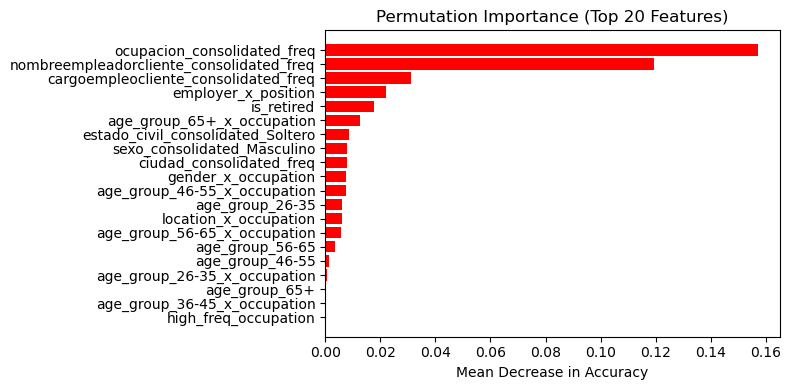

Top 20 Feature Names:
ocupacion_consolidated_freq
nombreempleadorcliente_consolidated_freq
cargoempleocliente_consolidated_freq
employer_x_position
is_retired
age_group_65+_x_occupation
estado_civil_consolidated_Soltero
sexo_consolidated_Masculino
ciudad_consolidated_freq
gender_x_occupation
age_group_46-55_x_occupation
age_group_26-35
location_x_occupation
age_group_56-65_x_occupation
age_group_56-65
age_group_46-55
age_group_26-35_x_occupation
age_group_65+
age_group_36-45_x_occupation
high_freq_occupation


In [133]:
# Create the plot
plt.figure(figsize=(8, 4))

# Get the top 15 (or fewer) important features
num_features_to_plot = min(20, len(feature_importance))
top_indices = sorted_idx[-num_features_to_plot:]

# Plot only the top features
plt.barh(range(num_features_to_plot), feature_importance[top_indices],color='red')
plt.yticks(range(num_features_to_plot), [feature_names[i] for i in top_indices])
plt.xlabel('Mean Decrease in Accuracy')
plt.title('Permutation Importance (Top 20 Features)')
plt.tight_layout()
plt.show()

# Print the names of the top features
print("Top 20 Feature Names:")
for i in reversed(top_indices):
    print(feature_names[i])

In [134]:
y_test_pred_lg_class = best_model.predict(test_df_enhanced[final_features_columns])

In [135]:
test_lg_test =test_df_enhanced.copy()
test_lg_test['target'] = test_df_enhanced['ingresos_reportados']
test_lg_test ["set_type"]='test'

In [136]:
test_lg_test["pred_income"] = y_test_pred_lg_class

In [137]:
# Calculate performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

mae = mean_absolute_error(test_lg_test.ingresos_reportados, test_lg_test.pred_income)
mse = mean_squared_error(test_lg_test.ingresos_reportados, test_lg_test.pred_income)
rmse = np.sqrt(mse)
r2 = r2_score(test_lg_test.ingresos_reportados, test_lg_test.pred_income)
evs = explained_variance_score(test_lg_test.ingresos_reportados, test_lg_test.pred_income)

In [138]:
# Calculate MAPE
mape = np.mean(np.abs((test_lg_test.ingresos_reportados - test_lg_test.pred_income) / test_lg_test.ingresos_reportados)) * 100

In [139]:
# Print the results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²) Score: {r2:.4f}")
print(f"Explained Variance Score: {evs:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")

Mean Absolute Error (MAE): 619.6902
Mean Squared Error (MSE): 867772.6105
Root Mean Squared Error (RMSE): 931.5431
R-squared (R²) Score: 0.3007
Explained Variance Score: 0.3007
Mean Absolute Percentage Error (MAPE): 49.4646%


In [140]:
test_lg_test['pred_income'].tail(10)

14950    1927.054880
14951    2355.951602
14953    1282.026642
14962    2037.176549
14966    3132.082196
14984    1552.981530
14989    1694.015007
14990    1690.157644
14994    1803.007698
14998    1264.569062
Name: pred_income, dtype: float64

In [141]:
#best_model_name = best_model
X_test_final = test_df_enhanced[final_features_columns]
y_train_cleaned = test_df_enhanced['ingresos_reportados']
best_model_name = 'LightGBM'   

VISUALIZING TRAINING TARGET vs TEST PREDICTIONS
Using best model: LightGBM
Test predictions shape: (2250,)
Training target shape: (2250,)


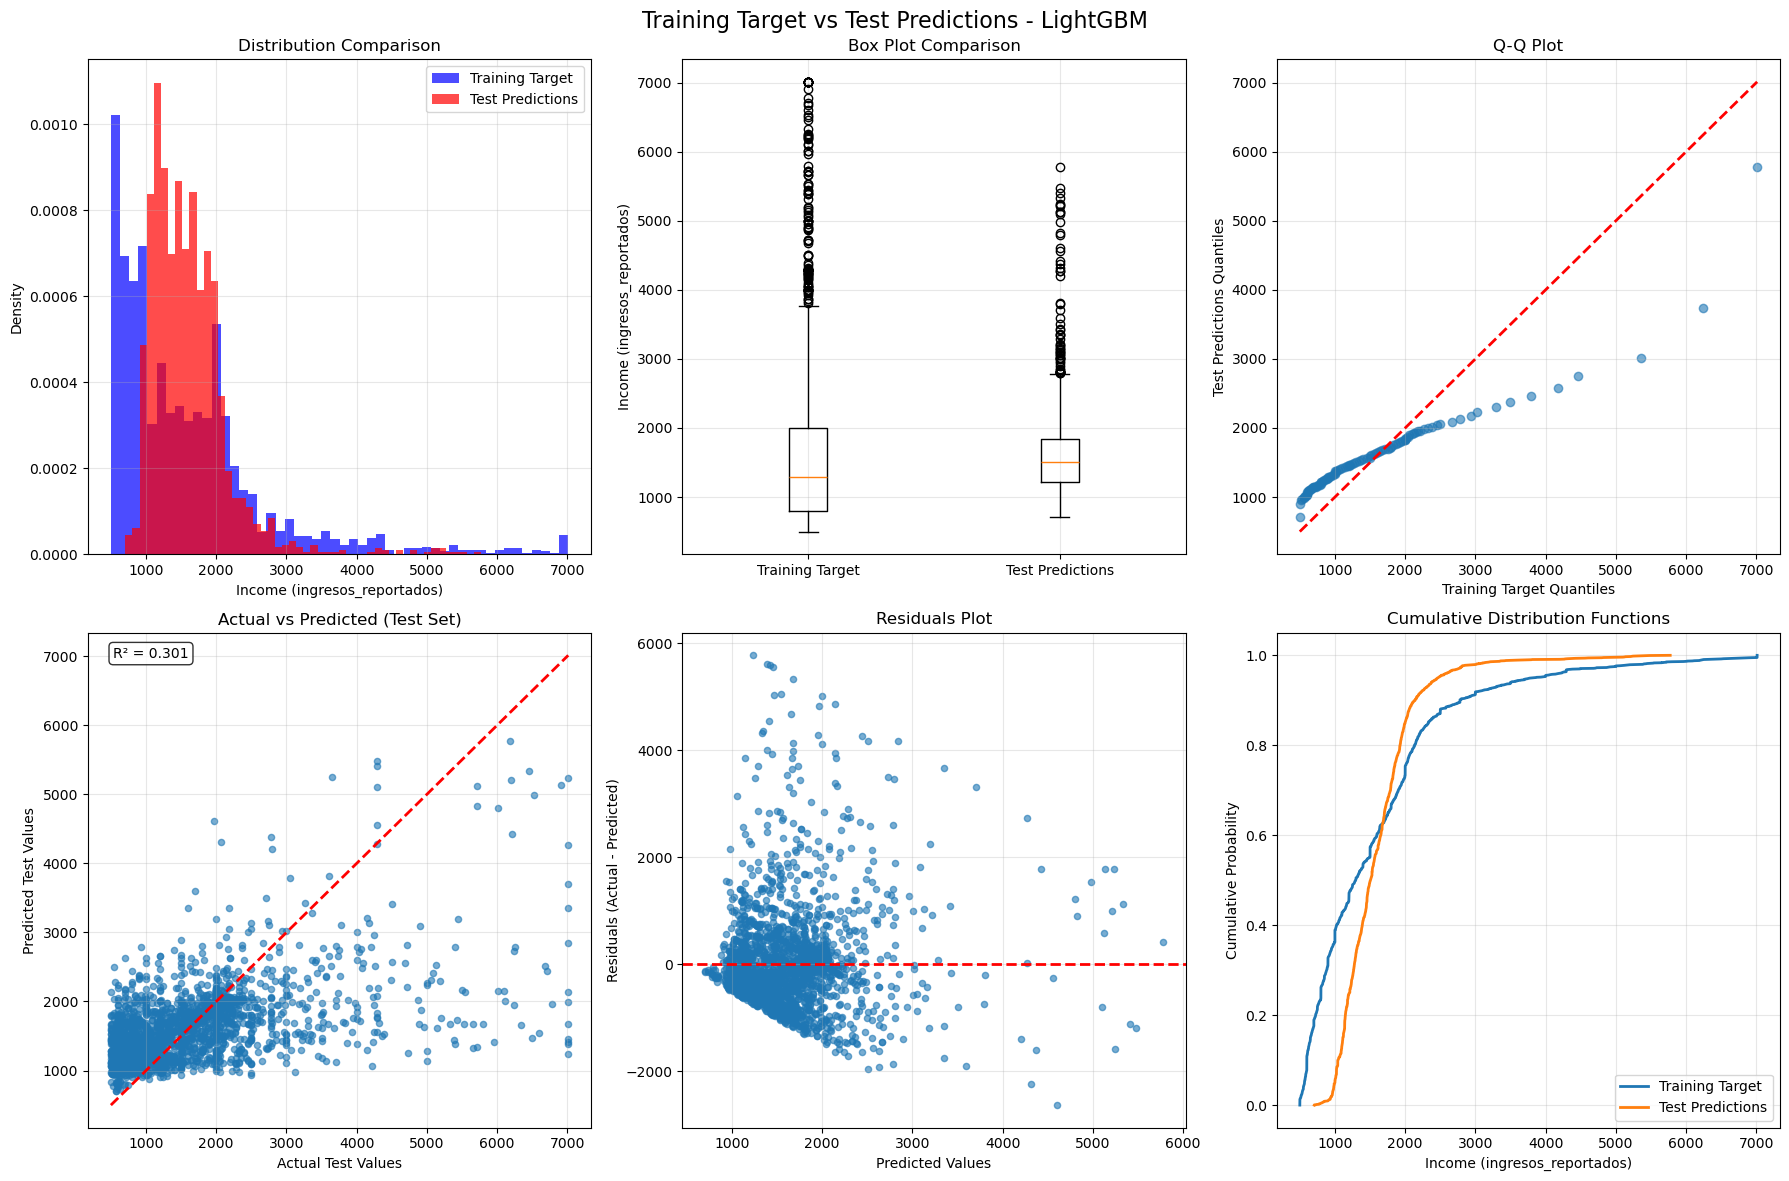


--- STATISTICAL COMPARISON ---
Training Target Statistics:
  - Mean: $1,593.25
  - Median: $1,295.03
  - Std: $1,114.21
  - Min: $500.00
  - Max: $7,012.28

Test Predictions Statistics:
  - Mean: $1,596.52
  - Median: $1,505.98
  - Std: $554.22
  - Min: $705.36
  - Max: $5,774.68

Test Set Performance:
  - RMSE: 931.5431
  - R²: 0.3007
  - MAE: 619.6902

Kolmogorov-Smirnov Test:
  - KS Statistic: 0.3387
  - P-value: 0.0000
  - Interpretation: Distributions are different


In [142]:
# Visualizing Training Target vs Test Predictions
# ============================================================================
print("=" * 60)
print("VISUALIZING TRAINING TARGET vs TEST PREDICTIONS")
print("=" * 60)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# First, get predictions on test set using the best model
best_model_obj = best_models[best_model_name]  # Use best_model_name instead of best_model
test_predictions = best_model_obj.predict(X_test_final)

print(f"Using best model: {best_model_name}")
print(f"Test predictions shape: {test_predictions.shape}")
print(f"Training target shape: {y_train_cleaned.shape}")

# Set up the plotting style
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f'Training Target vs Test Predictions - {best_model_name}', fontsize=16)

# 1. Distribution Comparison (Histograms)
axes[0,0].hist(y_train_cleaned, bins=50, alpha=0.7, label='Training Target', color='blue', density=True)
axes[0,0].hist(test_predictions, bins=50, alpha=0.7, label='Test Predictions', color='red', density=True)
axes[0,0].set_xlabel('Income (ingresos_reportados)')
axes[0,0].set_ylabel('Density')
axes[0,0].set_title('Distribution Comparison')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Box Plot Comparison
box_data = [y_train_cleaned, test_predictions]
box_labels = ['Training Target', 'Test Predictions']
axes[0,1].boxplot(box_data, labels=box_labels)
axes[0,1].set_ylabel('Income (ingresos_reportados)')
axes[0,1].set_title('Box Plot Comparison')
axes[0,1].grid(True, alpha=0.3)

# 3. Q-Q Plot (Quantile-Quantile)
train_quantiles = np.percentile(y_train_cleaned, np.linspace(0, 100, 100))
pred_quantiles = np.percentile(test_predictions, np.linspace(0, 100, 100))

axes[0,2].scatter(train_quantiles, pred_quantiles, alpha=0.6)
axes[0,2].plot([min(train_quantiles), max(train_quantiles)], 
               [min(train_quantiles), max(train_quantiles)], 'r--', lw=2)
axes[0,2].set_xlabel('Training Target Quantiles')
axes[0,2].set_ylabel('Test Predictions Quantiles')
axes[0,2].set_title('Q-Q Plot')
axes[0,2].grid(True, alpha=0.3)

# 4. Actual vs Predicted Scatter Plot (Test Set)
axes[1,0].scatter(y_test_cleaned, test_predictions, alpha=0.6, s=20)
axes[1,0].plot([y_test_cleaned.min(), y_test_cleaned.max()], 
               [y_test_cleaned.min(), y_test_cleaned.max()], 'r--', lw=2)
axes[1,0].set_xlabel('Actual Test Values')
axes[1,0].set_ylabel('Predicted Test Values')
axes[1,0].set_title('Actual vs Predicted (Test Set)')
axes[1,0].grid(True, alpha=0.3)

# Calculate R² for the plot
test_r2 = r2_score(y_test_cleaned, test_predictions)
axes[1,0].text(0.05, 0.95, f'R² = {test_r2:.3f}', transform=axes[1,0].transAxes, 
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 5. Residuals Plot
residuals = y_test_cleaned - test_predictions
axes[1,1].scatter(test_predictions, residuals, alpha=0.6, s=20)
axes[1,1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1,1].set_xlabel('Predicted Values')
axes[1,1].set_ylabel('Residuals (Actual - Predicted)')
axes[1,1].set_title('Residuals Plot')
axes[1,1].grid(True, alpha=0.3)

# 6. Cumulative Distribution Functions
train_sorted = np.sort(y_train_cleaned)
pred_sorted = np.sort(test_predictions)
train_cdf = np.arange(1, len(train_sorted) + 1) / len(train_sorted)
pred_cdf = np.arange(1, len(pred_sorted) + 1) / len(pred_sorted)

axes[1,2].plot(train_sorted, train_cdf, label='Training Target', linewidth=2)
axes[1,2].plot(pred_sorted, pred_cdf, label='Test Predictions', linewidth=2)
axes[1,2].set_xlabel('Income (ingresos_reportados)')
axes[1,2].set_ylabel('Cumulative Probability')
axes[1,2].set_title('Cumulative Distribution Functions')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical Comparison
print(f"\n--- STATISTICAL COMPARISON ---")
print(f"Training Target Statistics:")
print(f"  - Mean: ${y_train_cleaned.mean():,.2f}")
print(f"  - Median: ${y_train_cleaned.median():,.2f}")
print(f"  - Std: ${y_train_cleaned.std():,.2f}")
print(f"  - Min: ${y_train_cleaned.min():,.2f}")
print(f"  - Max: ${y_train_cleaned.max():,.2f}")

print(f"\nTest Predictions Statistics:")
print(f"  - Mean: ${test_predictions.mean():,.2f}")
print(f"  - Median: ${np.median(test_predictions):,.2f}")
print(f"  - Std: ${test_predictions.std():,.2f}")
print(f"  - Min: ${test_predictions.min():,.2f}")
print(f"  - Max: ${test_predictions.max():,.2f}")

print(f"\nTest Set Performance:")
test_rmse = np.sqrt(mean_squared_error(y_test_cleaned, test_predictions))
test_mae = np.mean(np.abs(y_test_cleaned - test_predictions))
print(f"  - RMSE: {test_rmse:.4f}")
print(f"  - R²: {test_r2:.4f}")
print(f"  - MAE: {test_mae:.4f}")

# Distribution similarity tests
from scipy.stats import ks_2samp
ks_statistic, ks_pvalue = ks_2samp(y_train_cleaned, test_predictions)
print(f"\nKolmogorov-Smirnov Test:")
print(f"  - KS Statistic: {ks_statistic:.4f}")
print(f"  - P-value: {ks_pvalue:.4f}")
print(f"  - Interpretation: {'Distributions are similar' if ks_pvalue > 0.05 else 'Distributions are different'}")

# VIEJO-------------NO CONSIDERAR

In [ ]:
class IncomeEstimationPipeline:
    """
    Complete pipeline for income estimation data preparation.
    Follows ML best practices and prevents data leakage.
    """
    
    def __init__(self, target_col='ingresos_reportados', random_state=42):
        """
        Initialize the pipeline.
        
        Args:
            target_col (str): Name of target variable column
            random_state (int): Random seed for reproducibility
        """
        self.target_col = target_col
        self.random_state = random_state
        self.fitted_transformers = {}
        self.outlier_thresholds = {}
        self.is_fitted = False
        
        # Define feature categories for interpretable modeling
        self.categorical_features = [
            'sexo_consolidated', 'estado_civil_consolidated', 'pais_consolidated',
            'ocupacion_consolidated', 'ciudad_consolidated', 'nombreempleadorcliente_consolidated',
            'cargoempleocliente_consolidated', 'age_group', 'segmento'
        ]
        
        self.numerical_features = [
            'edad', 'monto_letra', 'saldo', 'payment_to_income_ratio',
            'total_payment_to_income_ratio', 'debt_to_income_ratio',
            'relationship_tenure_years', 'num_products', 'product_diversity'
        ]
        
        self.binary_features = [
            'missing_fechaingresoempleo', 'missing_nombreempleadorcliente',
            'missing_cargoempleocliente', 'is_retired', 'high_value_customer',
            'customer_segment', 'letras_mensuales'
        ]
        
        print("🏗️ Income Estimation Pipeline Initialized")
        print(f"🎯 Target variable: {self.target_col}")
        print(f"📊 Feature categories: {len(self.categorical_features)} categorical, "
              f"{len(self.numerical_features)} numerical, {len(self.binary_features)} binary")
    
    def run_full_pipeline(self, df, customer_id_col='identificador_unico', 
                         train_size=0.7, val_size=0.2, test_size=0.1,
                         outlier_treatment='cap', save_outputs=True, output_dir='data/processed'):
        """
        Run the complete data preparation pipeline.
        
        Args:
            df (pd.DataFrame): Input dataset
            customer_id_col (str): Customer ID column name
            train_size (float): Training set proportion
            val_size (float): Validation set proportion  
            test_size (float): Test set proportion
            outlier_treatment (str): 'cap', 'flag', or 'none'
            save_outputs (bool): Whether to save processed datasets
            output_dir (str): Directory to save outputs
            
        Returns:
            tuple: (X_train, X_val, X_test, y_train, y_val, y_test)
        """
        
        print("🚀 STARTING INCOME ESTIMATION DATA PIPELINE")
        print("=" * 60)
        print(f"📊 Input dataset shape: {df.shape}")
        print(f"🎯 Target variable: {self.target_col}")
        print(f"👥 Unique customers: {df[customer_id_col].nunique()}")
        
        # Step 1: Customer-level data splitting
        print(f"\n📋 STEP 1: CUSTOMER-LEVEL DATA SPLITTING")
        train_df, val_df, test_df = self._split_data_by_customer(
            df, customer_id_col, train_size, val_size, test_size
        )
        
        # Step 2: Target variable analysis and treatment
        print(f"\n📋 STEP 2: TARGET VARIABLE ANALYSIS & TREATMENT")
        y_train_raw = train_df[self.target_col]
        y_val_raw = val_df[self.target_col]
        y_test_raw = test_df[self.target_col]
        
        # Analyze and treat outliers
        self.outlier_thresholds = self._analyze_target_variable(y_train_raw)
        y_train, y_val, y_test = self._apply_outlier_treatment(
            y_train_raw, y_val_raw, y_test_raw, outlier_treatment
        )
        
        # Step 3: Feature engineering
        print(f"\n📋 STEP 3: INTERPRETABLE FEATURE ENGINEERING")
        X_train = self._fit_transform_features(train_df)
        X_val = self._transform_features(val_df, "VALIDATION")
        X_test = self._transform_features(test_df, "TEST")
        
        # Step 4: Data cleaning and validation
        print(f"\n📋 STEP 4: DATA CLEANING & ML READINESS")
        X_train, X_val, X_test = self._clean_for_ml_training(X_train, X_val, X_test)
        
        # Step 5: Add noise features for feature selection
        print(f"\n📋 STEP 5: ADDING NOISE FEATURES FOR FEATURE SELECTION")
        X_train = self._add_noise_features(X_train)
        
        # Step 6: Final validation
        print(f"\n📋 STEP 6: FINAL VALIDATION & SUMMARY")
        self._validate_final_datasets(X_train, X_val, X_test, y_train, y_val, y_test)
        
        # Step 7: Save outputs (optional)
        if save_outputs:
            print(f"\n📋 STEP 7: SAVING PROCESSED DATASETS")
            self._save_processed_datasets(
                X_train, X_val, X_test, y_train, y_val, y_test, output_dir
            )
        
        print(f"\n✅ PIPELINE COMPLETED SUCCESSFULLY!")
        print(f"🎯 Ready for model training with interpretable features")
        
        return X_train, X_val, X_test, y_train, y_val, y_test

    def _split_data_by_customer(self, df, customer_id_col, train_size, val_size, test_size):
        """
        Split data ensuring no customer appears in multiple sets.
        Prevents data leakage by customer-level separation.
        """
        print(f"📊 Original dataset shape: {df.shape}")
        print(f"👥 Total unique customers: {df[customer_id_col].nunique()}")

        # Get unique customer IDs and shuffle
        unique_customers = df[customer_id_col].unique()
        np.random.seed(self.random_state)
        np.random.shuffle(unique_customers)

        # Calculate split indices
        n_customers = len(unique_customers)
        train_end = int(n_customers * train_size)
        val_end = int(n_customers * (train_size + val_size))

        # Split customer IDs
        train_customers = unique_customers[:train_end]
        val_customers = unique_customers[train_end:val_end]
        test_customers = unique_customers[val_end:]

        # Create data splits
        train_df = df[df[customer_id_col].isin(train_customers)].copy()
        val_df = df[df[customer_id_col].isin(val_customers)].copy()
        test_df = df[df[customer_id_col].isin(test_customers)].copy()

        # Verification and reporting
        print(f"✅ DATA SPLIT SUMMARY:")
        print(f"   Training: {train_df.shape[0]} samples ({len(train_df)/len(df)*100:.1f}%)")
        print(f"   Validation: {val_df.shape[0]} samples ({len(val_df)/len(df)*100:.1f}%)")
        print(f"   Test: {test_df.shape[0]} samples ({len(test_df)/len(df)*100:.1f}%)")

        # Data leakage verification
        train_customers_set = set(train_df[customer_id_col])
        val_customers_set = set(val_df[customer_id_col])
        test_customers_set = set(test_df[customer_id_col])

        overlaps = [
            len(train_customers_set.intersection(val_customers_set)),
            len(train_customers_set.intersection(test_customers_set)),
            len(val_customers_set.intersection(test_customers_set))
        ]

        if sum(overlaps) == 0:
            print(f"🔒 DATA LEAKAGE CHECK: ✅ PASSED - No customer overlap between sets")
        else:
            print(f"🔒 DATA LEAKAGE CHECK: ❌ FAILED - Customer overlap detected!")
            raise ValueError("Data leakage detected: customers appear in multiple sets")

        return train_df, val_df, test_df

    def _analyze_target_variable(self, y_train):
        """
        Comprehensive target variable analysis fitted on training data only.
        Returns outlier thresholds for consistent treatment across all sets.
        """
        print(f"🎯 TARGET VARIABLE ANALYSIS: {self.target_col}")
        print(f"📊 Training set: {len(y_train)} samples")

        # Basic statistics
        stats_summary = {
            'count': len(y_train),
            'mean': y_train.mean(),
            'median': y_train.median(),
            'std': y_train.std(),
            'min': y_train.min(),
            'max': y_train.max()
        }

        print(f"📈 BASIC STATISTICS:")
        print(f"   Mean: ${stats_summary['mean']:,.2f}")
        print(f"   Median: ${stats_summary['median']:,.2f}")
        print(f"   Range: ${stats_summary['min']:,.2f} - ${stats_summary['max']:,.2f}")

        # Outlier detection using multiple methods
        # Method 1: IQR Method
        Q1 = y_train.quantile(0.25)
        Q3 = y_train.quantile(0.75)
        IQR = Q3 - Q1
        iqr_lower = Q1 - 1.5 * IQR
        iqr_upper = Q3 + 1.5 * IQR
        iqr_outliers = y_train[(y_train < iqr_lower) | (y_train > iqr_upper)]

        # Method 2: Percentile Method (Conservative)
        perc_lower = np.percentile(y_train, 1)
        perc_upper = np.percentile(y_train, 99)
        perc_outliers = y_train[(y_train < perc_lower) | (y_train > perc_upper)]

        outlier_pct = len(iqr_outliers) / len(y_train) * 100

        print(f"🔍 OUTLIER ANALYSIS:")
        print(f"   IQR Method: {len(iqr_outliers)} outliers ({outlier_pct:.1f}%)")
        print(f"   Percentile Method: {len(perc_outliers)} outliers")
        print(f"   IQR bounds: ${iqr_lower:,.2f} - ${iqr_upper:,.2f}")
        print(f"   Percentile bounds: ${perc_lower:,.2f} - ${perc_upper:,.2f}")

        # Income distribution analysis for panama market
        income_ranges = {
            'very_low': (y_train <= 1000000).sum(),
            'low': ((y_train > 1000000) & (y_train <= 3000000)).sum(),
            'medium': ((y_train > 3000000) & (y_train <= 10000000)).sum(),
            'high': ((y_train > 10000000) & (y_train <= 20000000)).sum(),
            'very_high': (y_train > 20000000).sum()
        }

        print(f"💰 INCOME DISTRIBUTION (Panama Market):")
        for range_name, count in income_ranges.items():
            pct = count / len(y_train) * 100
            print(f"   {range_name.replace('_', ' ').title()}: {count} ({pct:.1f}%)")

        # Recommendations
        print(f"💡 RECOMMENDATIONS:")
        if outlier_pct > 10:
            print(f"   ⚠️  High outlier percentage - recommend capping at percentiles")
            recommended_method = 'percentile'
        else:
            print(f"   ✅ Moderate outliers - IQR method suitable")
            recommended_method = 'iqr'

        # Return thresholds fitted on training data
        return {
            'iqr_lower': iqr_lower,
            'iqr_upper': iqr_upper,
            'percentile_lower': perc_lower,
            'percentile_upper': perc_upper,
            'method_recommended': recommended_method,
            'stats': stats_summary
        }

    def _apply_outlier_treatment(self, y_train, y_val, y_test, method='cap'):
        """
        Apply outlier treatment using thresholds fitted on training data.
        Ensures consistent treatment across all datasets.
        """
        print(f"🔧 APPLYING OUTLIER TREATMENT: {method.upper()}")

        if method == 'none':
            print(f"   No treatment applied - using original values")
            return y_train.copy(), y_val.copy(), y_test.copy()

        # Get fitted thresholds
        recommended_method = self.outlier_thresholds['method_recommended']
        lower_bound = self.outlier_thresholds[f'{recommended_method}_lower']
        upper_bound = self.outlier_thresholds[f'{recommended_method}_upper']

        print(f"   Using {recommended_method.upper()} method")
        print(f"   Bounds: ${lower_bound:,.2f} - ${upper_bound:,.2f}")

        if method == 'cap':
            # Winsorization (capping extreme values)
            y_train_clean = y_train.clip(lower_bound, upper_bound)
            y_val_clean = y_val.clip(lower_bound, upper_bound)
            y_test_clean = y_test.clip(lower_bound, upper_bound)

            print(f"   ✅ Capped outliers to bounds")

        elif method == 'flag':
            # Keep original values but could add outlier flags as features
            y_train_clean = y_train.copy()
            y_val_clean = y_val.copy()
            y_test_clean = y_test.copy()

            train_outliers = (y_train < lower_bound) | (y_train > upper_bound)
            print(f"   ✅ Flagged {train_outliers.sum()} outliers (no capping applied)")

        # Show treatment impact
        print(f"📊 TREATMENT IMPACT:")
        print(f"   Before: mean=${y_train.mean():,.2f}, std=${y_train.std():,.2f}")
        print(f"   After:  mean=${y_train_clean.mean():,.2f}, std=${y_train_clean.std():,.2f}")

        return y_train_clean, y_val_clean, y_test_clean

    def _fit_transform_features(self, train_df):
        """
        Fit feature engineering transformers on training data and transform.
        Uses interpretable one-hot encoding approach.
        """
        print(f"🔧 FITTING FEATURE ENGINEERING ON TRAINING DATA")
        print(f"📊 Input shape: {train_df.shape}")

        # Fit categorical encoders
        self._fit_categorical_encoders(train_df)

        # Fit numerical scalers
        self._fit_numerical_scalers(train_df)

        # Fit interaction feature parameters
        self._fit_interaction_features(train_df)

        self.is_fitted = True

        # Transform training data
        return self._transform_features(train_df, "TRAINING")

    def _transform_features(self, df, dataset_name="DATASET"):
        """
        Transform features using fitted parameters.
        Can be applied to train, validation, or test sets.
        """
        print(f"🔄 TRANSFORMING {dataset_name} DATA")
        print(f"📊 Input shape: {df.shape}")

        if not self.is_fitted:
            raise ValueError("❌ Must fit transformers first!")

        df_transformed = df.copy()

        # Apply transformations
        df_transformed = self._transform_categorical_features(df_transformed)
        df_transformed = self._transform_numerical_features(df_transformed)
        df_transformed = self._create_interaction_features(df_transformed)

        # Remove ID columns and target for feature matrix
        feature_cols = [col for col in df_transformed.columns
                       if col not in ['identificador_unico', 'cliente', self.target_col]]

        X = df_transformed[feature_cols]

        print(f"📈 Output shape: {X.shape}")
        return X

    def _fit_categorical_encoders(self, train_df):
        """Fit one-hot encoders for categorical features."""
        print(f"📋 Fitting categorical encoders...")

        for feature in self.categorical_features:
            if feature in train_df.columns:
                unique_categories = sorted(train_df[feature].dropna().unique())
                self.fitted_transformers[f'{feature}_categories'] = unique_categories

                if len(unique_categories) > 20:
                    print(f"   ⚠️  {feature}: {len(unique_categories)} categories (high cardinality)")
                else:
                    print(f"   ✅ {feature}: {len(unique_categories)} categories")

    def _transform_categorical_features(self, df):
        """Transform categorical features using one-hot encoding."""
        df_cat = df.copy()

        for feature in self.categorical_features:
            if feature in df_cat.columns:
                fitted_categories = self.fitted_transformers.get(f'{feature}_categories', [])

                if fitted_categories:
                    # Handle missing values and unknown categories
                    df_cat[feature] = df_cat[feature].fillna('Missing')
                    mask_unknown = ~df_cat[feature].isin(fitted_categories)

                    if mask_unknown.any():
                        df_cat.loc[mask_unknown, feature] = 'Unknown'

                    # One-hot encode
                    for category in fitted_categories:
                        df_cat[f'{feature}_{category}'] = (df_cat[feature] == category).astype(int)

                    # Add Unknown category if needed
                    if mask_unknown.any():
                        df_cat[f'{feature}_Unknown'] = (df_cat[feature] == 'Unknown').astype(int)

                    # Drop original column
                    df_cat = df_cat.drop(columns=[feature])

        return df_cat

    def _fit_numerical_scalers(self, train_df):
        """Fit scalers for numerical features."""
        print(f"🔢 Fitting numerical scalers...")

        for feature in self.numerical_features:
            if feature in train_df.columns:
                scaler = StandardScaler()
                scaler.fit(train_df[[feature]])
                self.fitted_transformers[f'{feature}_scaler'] = scaler

                # Store statistics for interpretability
                self.fitted_transformers[f'{feature}_stats'] = {
                    'mean': train_df[feature].mean(),
                    'std': train_df[feature].std()
                }

        print(f"   ✅ Fitted {len(self.numerical_features)} numerical scalers")

    def _transform_numerical_features(self, df):
        """Transform numerical features using fitted scalers."""
        df_num = df.copy()

        for feature in self.numerical_features:
            if feature in df_num.columns:
                scaler = self.fitted_transformers.get(f'{feature}_scaler')
                if scaler is not None:
                    df_num[f'{feature}_scaled'] = scaler.transform(df_num[[feature]]).flatten()

        return df_num

    def _fit_interaction_features(self, train_df):
        """Fit parameters for interpretable interaction features."""
        print(f"🔗 Fitting interaction feature parameters...")

        # Financial capacity statistics
        if 'saldo' in train_df.columns and 'monto_letra' in train_df.columns:
            capacity_ratio = train_df['saldo'] / (train_df['monto_letra'] + 1)
            self.fitted_transformers['capacity_stats'] = {
                'median': capacity_ratio.median()
            }

        print(f"   ✅ Fitted interaction parameters")

    def _create_interaction_features(self, df):
        """Create interpretable interaction features."""
        df_int = df.copy()

        # Age-based interactions
        if 'edad' in df_int.columns:
            df_int['is_young_adult'] = ((df_int['edad'] >= 18) & (df_int['edad'] <= 30)).astype(int)
            df_int['is_middle_aged'] = ((df_int['edad'] >= 31) & (df_int['edad'] <= 50)).astype(int)
            df_int['is_senior'] = (df_int['edad'] >= 51).astype(int)

        # Financial health indicators
        if 'saldo' in df_int.columns and 'monto_letra' in df_int.columns:
            df_int['financial_capacity_ratio'] = df_int['saldo'] / (df_int['monto_letra'] + 1)

            capacity_stats = self.fitted_transformers.get('capacity_stats', {'median': 1.0})
            df_int['has_good_financial_capacity'] = (
                df_int['financial_capacity_ratio'] > capacity_stats['median']
            ).astype(int)

        # Employment stability
        if 'relationship_tenure_years' in df_int.columns:
            df_int['is_long_term_customer'] = (df_int['relationship_tenure_years'] >= 3).astype(int)
            df_int['is_new_customer'] = (df_int['relationship_tenure_years'] <= 1).astype(int)

        # Debt burden categories
        if 'debt_to_income_ratio' in df_int.columns:
            df_int['has_low_debt_burden'] = (df_int['debt_to_income_ratio'] <= 0.3).astype(int)
            df_int['has_high_debt_burden'] = (df_int['debt_to_income_ratio'] >= 0.5).astype(int)

        return df_int

    def _clean_for_ml_training(self, X_train, X_val, X_test):
        """Remove non-ML compatible columns and verify data quality."""
        print(f"🧹 CLEANING DATASETS FOR ML TRAINING")

        # Identify columns to remove
        columns_to_remove = []

        # Object/string columns (non-encoded categorical)
        object_columns = X_train.select_dtypes(include=['object']).columns.tolist()
        columns_to_remove.extend(object_columns)

        # Date columns
        date_columns = X_train.select_dtypes(include=['datetime64']).columns.tolist()
        columns_to_remove.extend(date_columns)

        # ID columns
        id_patterns = ['id', 'identificador', 'cliente']
        id_columns = [col for col in X_train.columns
                      if any(pattern in col.lower() for pattern in id_patterns)]
        columns_to_remove.extend(id_columns)

        # Target column (if accidentally included)
        target_columns = [col for col in X_train.columns
                         if self.target_col.lower() in col.lower()]
        columns_to_remove.extend(target_columns)

        # Remove duplicates
        columns_to_remove = list(set(columns_to_remove))

        if columns_to_remove:
            print(f"   🗑️  Removing {len(columns_to_remove)} non-ML columns")
            X_train_clean = X_train.drop(columns=columns_to_remove, errors='ignore')
            X_val_clean = X_val.drop(columns=columns_to_remove, errors='ignore')
            X_test_clean = X_test.drop(columns=columns_to_remove, errors='ignore')
        else:
            X_train_clean, X_val_clean, X_test_clean = X_train, X_val, X_test

        # Verify data types
        non_numeric_cols = X_train_clean.select_dtypes(exclude=['number', 'bool']).columns.tolist()
        if non_numeric_cols:
            print(f"   ⚠️  WARNING: Non-numeric columns found: {non_numeric_cols}")
        else:
            print(f"   ✅ All features are numeric/boolean")

        print(f"   📊 Final shapes: Train={X_train_clean.shape}, Val={X_val_clean.shape}, Test={X_test_clean.shape}")

        return X_train_clean, X_val_clean, X_test_clean

    def _add_noise_features(self, X_train):
        """Add noise features for feature selection validation."""
        print(f"🎲 ADDING NOISE FEATURES FOR FEATURE SELECTION")

        np.random.seed(self.random_state)
        data_size = len(X_train)

        # Create various types of noise features
        noise_features = {
            'noise_gaussian_low': np.random.normal(0, 1000, size=data_size),
            'noise_gaussian_med': np.random.normal(0, 5000, size=data_size),
            'noise_gaussian_high': np.random.normal(0, 10000, size=data_size),
            'noise_uniform': np.random.uniform(-20000, 20000, size=data_size),
            'noise_binary_1': np.random.choice([0, 1], size=data_size, p=[0.6, 0.4]),
            'noise_binary_2': np.random.choice([0, 1], size=data_size, p=[0.7, 0.3]),
            'noise_categorical_1': np.random.choice([0, 1, 2, 3, 4], size=data_size),
            'noise_ratio_1': np.random.uniform(0, 2, size=data_size),
            'noise_ratio_2': np.random.uniform(0, 1, size=data_size),
            'noise_interaction': np.random.normal(0, 1000, size=data_size) * np.random.normal(0, 1000, size=data_size)
        }

        # Add noise features to training set
        X_train_with_noise = X_train.copy()
        for feature_name, feature_values in noise_features.items():
            X_train_with_noise[feature_name] = feature_values

        print(f"   ✅ Added {len(noise_features)} noise features")
        print(f"   📊 Shape: {X_train.shape} → {X_train_with_noise.shape}")

        return X_train_with_noise

    def _validate_final_datasets(self, X_train, X_val, X_test, y_train, y_val, y_test):
        """Final validation of datasets for ML readiness."""
        print(f"🔍 FINAL VALIDATION & ML READINESS CHECK")

        # Shape consistency
        print(f"📊 DATASET SHAPES:")
        print(f"   Training: X={X_train.shape}, y={y_train.shape}")
        print(f"   Validation: X={X_val.shape}, y={y_val.shape}")
        print(f"   Test: X={X_test.shape}, y={y_test.shape}")

        # Missing values check
        missing_counts = [
            X_train.isnull().sum().sum(),
            X_val.isnull().sum().sum(),
            X_test.isnull().sum().sum()
        ]

        print(f"📊 MISSING VALUES: Train={missing_counts[0]}, Val={missing_counts[1]}, Test={missing_counts[2]}")

        # Data types check
        non_numeric = X_train.select_dtypes(exclude=['number', 'bool']).columns
        if len(non_numeric) == 0:
            print(f"✅ DATA TYPES: All features are numeric/boolean - ML ready!")
        else:
            print(f"❌ DATA TYPES: Non-numeric columns found: {non_numeric.tolist()}")

        # Feature breakdown
        real_features = [col for col in X_train.columns if not col.startswith('noise_')]
        noise_features = [col for col in X_train.columns if col.startswith('noise_')]

        print(f"🔍 FEATURE BREAKDOWN:")
        print(f"   Real features: {len(real_features)}")
        print(f"   Noise features: {len(noise_features)}")
        print(f"   Total features: {X_train.shape[1]}")

        # Target variable summary
        print(f"💰 TARGET VARIABLE SUMMARY:")
        print(f"   Training mean: ${y_train.mean():,.2f}")
        print(f"   Training range: ${y_train.min():,.2f} - ${y_train.max():,.2f}")

    def _save_processed_datasets(self, X_train, X_val, X_test, y_train, y_val, y_test, output_dir):
        """Save processed datasets and transformers."""
        print(f"💾 SAVING PROCESSED DATASETS")

        # Create output directory
        os.makedirs(output_dir, exist_ok=True)

        # Save feature matrices
        X_train.to_csv(f'{output_dir}/X_train_processed.csv', index=False)
        X_val.to_csv(f'{output_dir}/X_val_processed.csv', index=False)
        X_test.to_csv(f'{output_dir}/X_test_processed.csv', index=False)

        # Save target variables
        y_train.to_csv(f'{output_dir}/y_train_processed.csv', index=False)
        y_val.to_csv(f'{output_dir}/y_val_processed.csv', index=False)
        y_test.to_csv(f'{output_dir}/y_test_processed.csv', index=False)

        # Save transformers and thresholds
        pipeline_artifacts = {
            'fitted_transformers': self.fitted_transformers,
            'outlier_thresholds': self.outlier_thresholds,
            'feature_categories': {
                'categorical': self.categorical_features,
                'numerical': self.numerical_features,
                'binary': self.binary_features
            }
        }

        joblib.dump(pipeline_artifacts, f'{output_dir}/pipeline_artifacts.joblib')

        print(f"   ✅ Datasets saved to: {output_dir}")
        print(f"   ✅ Pipeline artifacts saved for production use")


In [ ]:
# USAGE EXAMPLE AND MAIN EXECUTION
if __name__ == "__main__":
    """
    Example usage of the Income Estimation Pipeline
    """

    print("🚀 INCOME ESTIMATION ML - DATA PREPARATION PIPELINE")
    print("=" * 60)
    print(f"📅 Execution Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

    # Configuration
    DATA_PATH = "C:/Users/david/OneDrive/Documents/augment-projects/caja-social/income-estimator-ml/data/processed/final_dataset.csv"
    OUTPUT_DIR = "C:/Users/david/OneDrive/Documents/augment-projects/caja-social/income-estimator-ml"

    try:
        # Load data
        print(f"\n📂 LOADING DATA FROM: {DATA_PATH}")
        df = pd.read_csv(DATA_PATH)
        print(f"✅ Data loaded successfully: {df.shape}")

        # Initialize and run pipeline
        pipeline = IncomeEstimationPipeline(
            target_col='ingresos_reportados',
            random_state=42
        )

        # Run complete pipeline
        X_train, X_val, X_test, y_train, y_val, y_test = pipeline.run_full_pipeline(
            df=df,
            customer_id_col='identificador_unico',
            train_size=0.7,
            val_size=0.2,
            test_size=0.1,
            outlier_treatment='cap',  # Options: 'cap', 'flag', 'none'
            save_outputs=True,
            output_dir=OUTPUT_DIR
        )

        print(f"\n🎉 PIPELINE COMPLETED SUCCESSFULLY!")
        print(f"📊 Final Output Shapes:")
        print(f"   X_train: {X_train.shape}")
        print(f"   X_val: {X_val.shape}")
        print(f"   X_test: {X_test.shape}")
        print(f"   y_train: {y_train.shape}")
        print(f"   y_val: {y_val.shape}")
        print(f"   y_test: {y_test.shape}")

        print(f"\n🎯 NEXT STEPS:")
        print(f"   1. Use the processed datasets for model training")
        print(f"   2. Apply feature selection using noise features as baseline")
        print(f"   3. Train interpretable models (Random Forest, Gradient Boosting)")
        print(f"   4. Validate model performance on test set")
        print(f"   5. Deploy model using saved pipeline artifacts")

    except FileNotFoundError:
        print(f"❌ ERROR: Data file not found at {DATA_PATH}")
        print(f"   Please update DATA_PATH to point to your dataset")
    except Exception as e:
        print(f"❌ ERROR: {str(e)}")
        print(f"   Please check your data and configuration")

## Voting system

In [ ]:
! pip install lightgbm

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import numpy as np
import pandas as pd

# FEATURE SELECTION VOTING SYSTEM FOR INCOME ESTIMATION
print("🗳️ FEATURE SELECTION VOTING SYSTEM - INCOME ESTIMATION")
print("=" * 60)

# Initialize regression models for SINGLE-TARGET prediction (income estimation)
# These models will help identify the best features vs noise features

# Model 1: Random Forest (excellent for feature importance)
model1 = RandomForestRegressor(
    n_estimators=200,           # More trees for better feature importance
    max_depth=10,               # Prevent overfitting
    min_samples_split=20,       # Conservative splitting
    min_samples_leaf=10,        # Conservative leaf size
    random_state=42,
    n_jobs=-1,                  # Use all available cores
    oob_score=True             # Out-of-bag score for validation
)

# Model 2: LightGBM (fast and effective for feature selection)
model2 = lgb.LGBMRegressor(
    n_estimators=200,           # Sufficient for feature importance
    max_depth=8,                # Prevent overfitting
    learning_rate=0.1,          # Conservative learning rate
    num_leaves=31,              # Default balanced value
    min_child_samples=20,       # Conservative splitting
    subsample=0.8,              # Feature bagging
    colsample_bytree=0.8,       # Column sampling
    random_state=42,
    n_jobs=-1,
    verbose=-1,                 # Suppress warnings
    importance_type='gain'      # Use gain for feature importance
)

# Model 3: Ridge Regression with built-in feature selection
model3 = Ridge(
    alpha=1.0,                  # Regularization strength
    random_state=42,
    max_iter=1000              # Ensure convergence
)

# Store models in a dictionary for easy iteration
models = {
    'RandomForest': model1,
    'LightGBM': model2, 
    'Ridge': model3
}

print("✅ Initialized models for income estimation feature selection:")
for name, model in models.items():
    print(f"   - {name}: {type(model).__name__}")

# FEATURE SELECTION METHODS FOR VOTING SYSTEM
print(f"\n🔍 FEATURE SELECTION METHODS:")

# Method 1: Statistical Feature Selection (F-test)
selector_f_test = SelectKBest(
    score_func=f_regression,
    k='all'  # Get scores for all features
)

# Method 2: Mutual Information Feature Selection
selector_mutual_info = SelectKBest(
    score_func=mutual_info_regression,
    k='all'  # Get scores for all features
)

feature_selectors = {
    'F_Test': selector_f_test,
    'Mutual_Info': selector_mutual_info
}

for name, selector in feature_selectors.items():
    print(f"   - {name}: {type(selector.score_func).__name__}")

print(f"\n🎯 VOTING STRATEGY:")
print(f"   1. Train all 3 models on data with noise features")
print(f"   2. Extract feature importance from each model")
print(f"   3. Apply statistical feature selection methods")
print(f"   4. Create voting score combining all methods")
print(f"   5. Remove features scoring lower than noise features")

# TRAINING AND FEATURE IMPORTANCE EXTRACTION FUNCTION
def extract_feature_importance_voting(X_train, y_train, X_val, y_val, models, selectors, noise_features):
    """
    Train models and extract feature importance for voting system.
    
    Parameters:
    - X_train, y_train: Training data
    - X_val, y_val: Validation data  
    - models: Dictionary of models to train
    - selectors: Dictionary of feature selectors
    - noise_features: List of noise feature names
    
    Returns:
    - feature_scores: DataFrame with voting scores for each feature
    - trained_models: Dictionary of trained models
    """
    
    print(f"\n🔧 TRAINING MODELS FOR FEATURE IMPORTANCE EXTRACTION")
    print(f"📊 Training data: {X_train.shape}")
    print(f"📊 Validation data: {X_val.shape}")
    
    feature_scores = pd.DataFrame(index=X_train.columns)
    trained_models = {}
    
    # Train models and extract feature importance
    for model_name, model in models.items():
        print(f"\n   🤖 Training {model_name}...")
        
        # Train model
        model.fit(X_train, y_train)
        trained_models[model_name] = model
        
        # Make predictions for validation
        y_pred = model.predict(X_val)
        
        # Calculate performance metrics
        mae = mean_absolute_error(y_val, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        
        print(f"      MAE: ${mae:,.2f}")
        print(f"      RMSE: ${rmse:,.2f}")
        print(f"      R²: {r2:.4f}")
        
        # Extract feature importance
        if hasattr(model, 'feature_importances_'):
            # Tree-based models (RandomForest, LightGBM)
            importance = model.feature_importances_
        elif hasattr(model, 'coef_'):
            # Linear models (Ridge) - use absolute coefficients
            importance = np.abs(model.coef_)
        else:
            # Fallback: use permutation importance
            from sklearn.inspection import permutation_importance
            perm_importance = permutation_importance(model, X_val, y_val, random_state=42)
            importance = perm_importance.importances_mean
        
        # Store feature importance (normalized)
        importance_normalized = importance / np.sum(importance)
        feature_scores[f'{model_name}_importance'] = importance_normalized
    
    # Apply statistical feature selection methods
    print(f"\n🔍 APPLYING STATISTICAL FEATURE SELECTION...")
    
    for selector_name, selector in selectors.items():
        print(f"   📊 Computing {selector_name} scores...")
        
        # Fit selector and get scores
        selector.fit(X_train, y_train)
        scores = selector.scores_
        
        # Normalize scores (0-1 range)
        scores_normalized = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))
        feature_scores[f'{selector_name}_score'] = scores_normalized
    
    # Calculate voting score (average of all methods)
    score_columns = [col for col in feature_scores.columns if 'importance' in col or 'score' in col]
    feature_scores['voting_score'] = feature_scores[score_columns].mean(axis=1)
    
    # Add feature type (real vs noise)
    feature_scores['feature_type'] = feature_scores.index.map(
        lambda x: 'noise' if x in noise_features else 'real'
    )
    
    # Calculate noise baseline (median score of noise features)
    noise_scores = feature_scores[feature_scores['feature_type'] == 'noise']['voting_score']
    noise_baseline = noise_scores.median()
    
    print(f"\n📊 FEATURE SELECTION RESULTS:")
    print(f"   🎲 Noise features baseline score: {noise_baseline:.4f}")
    
    # Identify features above noise baseline
    selected_features = feature_scores[feature_scores['voting_score'] > noise_baseline].index.tolist()
    real_selected = [f for f in selected_features if f not in noise_features]
    
    print(f"   ✅ Features above noise baseline: {len(selected_features)}")
    print(f"   ✅ Real features selected: {len(real_selected)}")
    print(f"   🗑️  Features to remove: {len(X_train.columns) - len(selected_features)}")
    
    return feature_scores, trained_models, selected_features

print(f"\n🚀 READY FOR FEATURE SELECTION VOTING!")
print(f"   Use: feature_scores, trained_models, selected_features = extract_feature_importance_voting(X_final, y_final, X_val_ml, y_val_clean, models, feature_selectors, noise_features_list)")

In [ ]:
# FEATURE SELECTION VOTING SYSTEM - MODEL TRAINING & EVALUATION
import time
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd

print("TRAINING MODELS FOR INCOME ESTIMATION FEATURE SELECTION")
print("=" * 60)

# Dictionary to store training results and feature importance
training_results = {}
feature_importance_results = {}

# STEP 1: TRAIN MODELS AND EXTRACT FEATURE IMPORTANCE
print("Training models on data with noise features...")
print(f"Training data shape: {X_train.shape}")
print(f"Target data shape: {y_train.shape}")
print(f"Real features: {len([col for col in X_train.columns if not col.startswith('noise_')])}")
print(f"Noise features: {len([col for col in X_train.columns if col.startswith('noise_')])}")

# Model 1: Random Forest
print("\nTraining Random Forest...")
start_time = time.time()
try:
    model1.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Extract feature importance
    rf_importance = model1.feature_importances_
    feature_importance_results['RandomForest'] = rf_importance
    
    # Calculate OOB score (built-in validation)
    oob_score = model1.oob_score_
    
    print(f"Random Forest trained successfully in {training_time:.2f} seconds")
    print(f"OOB Score (R2): {oob_score:.4f}")
    
    training_results['RandomForest'] = {
        'status': 'success', 
        'time': training_time,
        'oob_score': oob_score,
        'feature_importance': rf_importance
    }
    
except Exception as e:
    print(f"Random Forest training failed: {e}")
    training_results['RandomForest'] = {'status': 'failed', 'error': str(e)}

# Model 2: LightGBM
print("\nTraining LightGBM...")
start_time = time.time()
try:
    model2.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Extract feature importance (gain-based)
    lgb_importance = model2.feature_importances_
    feature_importance_results['LightGBM'] = lgb_importance
    
    print(f"LightGBM trained successfully in {training_time:.2f} seconds")
    
    training_results['LightGBM'] = {
        'status': 'success', 
        'time': training_time,
        'feature_importance': lgb_importance
    }
    
except Exception as e:
    print(f"LightGBM training failed: {e}")
    training_results['LightGBM'] = {'status': 'failed', 'error': str(e)}

# Model 3: Ridge Regression
print("\nTraining Ridge Regression...")
start_time = time.time()
try:
    model3.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Extract feature importance (absolute coefficients)
    ridge_importance = np.abs(model3.coef_)
    feature_importance_results['Ridge'] = ridge_importance
    
    print(f"Ridge Regression trained successfully in {training_time:.2f} seconds")
    
    training_results['Ridge'] = {
        'status': 'success', 
        'time': training_time,
        'feature_importance': ridge_importance
    }
    
except Exception as e:
    print(f"Ridge Regression training failed: {e}")
    training_results['Ridge'] = {'status': 'failed', 'error': str(e)}

# STEP 2: APPLY STATISTICAL FEATURE SELECTION
print("\nAPPLYING STATISTICAL FEATURE SELECTION...")

# F-test feature selection
print("Computing F-test scores...")
try:
    selector_f_test.fit(X_train, y_train)
    f_test_scores = selector_f_test.scores_
    feature_importance_results['F_Test'] = f_test_scores
    print("F-test completed successfully")
except Exception as e:
    print(f"F-test failed: {e}")

# Mutual Information feature selection
print("Computing Mutual Information scores...")
try:
    selector_mutual_info.fit(X_train, y_train)
    mutual_info_scores = selector_mutual_info.scores_
    feature_importance_results['Mutual_Info'] = mutual_info_scores
    print("Mutual Information completed successfully")
except Exception as e:
    print(f"Mutual Information failed: {e}")

# STEP 3: CREATE VOTING SCORES
print("\nCREATING FEATURE VOTING SCORES...")

# Create DataFrame with all feature scores
feature_scores_df = pd.DataFrame(index=X_train.columns)

# Add model-based importance scores (normalized)
for model_name, importance in feature_importance_results.items():
    if len(importance) == len(X_train.columns):
        # Normalize importance scores to 0-1 range
        importance_normalized = importance / np.sum(importance)
        feature_scores_df[f'{model_name}_importance'] = importance_normalized

# Add statistical scores (normalized)
if 'F_Test' in feature_importance_results:
    f_scores = feature_importance_results['F_Test']
    f_scores_normalized = (f_scores - np.min(f_scores)) / (np.max(f_scores) - np.min(f_scores))
    feature_scores_df['F_Test_score'] = f_scores_normalized

if 'Mutual_Info' in feature_importance_results:
    mi_scores = feature_importance_results['Mutual_Info']
    mi_scores_normalized = (mi_scores - np.min(mi_scores)) / (np.max(mi_scores) - np.min(mi_scores))
    feature_scores_df['Mutual_Info_score'] = mi_scores_normalized

# Calculate final voting score (average of all methods)
score_columns = [col for col in feature_scores_df.columns if 'importance' in col or 'score' in col]
feature_scores_df['voting_score'] = feature_scores_df[score_columns].mean(axis=1)

# Add feature type classification
noise_features_list = [col for col in X_train.columns if col.startswith('noise_')]
feature_scores_df['feature_type'] = feature_scores_df.index.map(
    lambda x: 'noise' if x in noise_features_list else 'real'
)

# STEP 4: DETERMINE NOISE BASELINE AND SELECT FEATURES
print("\nDETERMINING FEATURE SELECTION THRESHOLD...")

# Calculate noise baseline (median score of noise features)
noise_scores = feature_scores_df[feature_scores_df['feature_type'] == 'noise']['voting_score']
noise_baseline = noise_scores.median()
noise_mean = noise_scores.mean()
noise_std = noise_scores.std()

print(f"Noise features statistics:")
print(f"  Count: {len(noise_scores)}")
print(f"  Median: {noise_baseline:.4f}")
print(f"  Mean: {noise_mean:.4f}")
print(f"  Std: {noise_std:.4f}")

# Select features above noise baseline
selected_features = feature_scores_df[feature_scores_df['voting_score'] > noise_baseline].index.tolist()
real_selected = [f for f in selected_features if f not in noise_features_list]
noise_selected = [f for f in selected_features if f in noise_features_list]

print(f"\nFEATURE SELECTION RESULTS:")
print(f"  Total features: {len(X_train.columns)}")
print(f"  Noise features: {len(noise_features_list)}")
print(f"  Features above baseline: {len(selected_features)}")
print(f"  Real features selected: {len(real_selected)}")
print(f"  Noise features selected: {len(noise_selected)} (should be few)")
print(f"  Features to remove: {len(X_train.columns) - len(selected_features)}")

# STEP 5: VALIDATION ON CLEAN DATASETS (CORRECTED)
print(f"\nVALIDATION ON CLEAN DATASETS (without noise)...")

# The issue: X_val and X_test don't have noise features, but X_train does
# Solution: Remove noise features from X_train first, then align all datasets

# 1. Remove noise features from training data
X_train_clean = X_train[[col for col in X_train.columns if col not in noise_features_list]]
print(f"Clean training data: {X_train_clean.shape}")

# 2. Find common features across all datasets
common_features = list(set(X_train_clean.columns) & set(X_val.columns) & set(X_test.columns))
print(f"Common features across all datasets: {len(common_features)}")

# 3. Create aligned datasets with only common features
X_train_aligned = X_train_clean[common_features]
X_val_aligned = X_val[common_features]
X_test_aligned = X_test[common_features]

print(f"Aligned training data: {X_train_aligned.shape}")
print(f"Aligned validation data: {X_val_aligned.shape}")
print(f"Aligned test data: {X_test_aligned.shape}")

# 4. Quick validation check on aligned clean data
validation_results = {}

for model_name, model in models.items():
    if training_results[model_name]['status'] == 'success':
        try:
            print(f"\nValidating {model_name}...")
            
            # Retrain on aligned clean training data
            model.fit(X_train_aligned, y_train)
            
            # Predict on validation set
            y_pred = model.predict(X_val_aligned)
            
            # Calculate metrics
            mae = mean_absolute_error(y_val, y_pred)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            r2 = r2_score(y_val, y_pred)
            
            validation_results[model_name] = {
                'MAE': mae,
                'RMSE': rmse,
                'R2': r2
            }
            
            print(f"  MAE: ${mae:,.2f}")
            print(f"  RMSE: ${rmse:,.2f}")
            print(f"  R2: {r2:.4f}")
            
        except Exception as e:
            print(f"  {model_name} validation failed: {e}")

# STEP 6: CORRECTED FINAL DATASETS
print(f"\nCREATING FINAL SELECTED DATASETS (CORRECTED)...")

# Use selected features that exist in all datasets
selected_features_common = [f for f in selected_features if f in common_features]
print(f"Selected features available in all datasets: {len(selected_features_common)}")

# Create final selected datasets with common features only
X_train_selected = X_train_aligned[selected_features_common]
X_val_selected = X_val_aligned[selected_features_common]
X_test_selected = X_test_aligned[selected_features_common]

print(f"\nFINAL SELECTED DATASETS (CORRECTED):")
print(f"  X_train_selected: {X_train_selected.shape}")
print(f"  X_val_selected: {X_val_selected.shape}")
print(f"  X_test_selected: {X_test_selected.shape}")

# Verify all datasets have same features
print(f"\nFEATURE ALIGNMENT VERIFICATION:")
print(f"  All datasets have same features: {list(X_train_selected.columns) == list(X_val_selected.columns) == list(X_test_selected.columns)}")
print(f"  Feature count consistency: Train={X_train_selected.shape[1]}, Val={X_val_selected.shape[1]}, Test={X_test_selected.shape[1]}")

print(f"\n✅ CORRECTED FEATURE SELECTION COMPLETED!")
print(f"Use X_train_selected, X_val_selected, X_test_selected for final model training")

In [ ]:
# CORRECTED: Extract feature importances from ORIGINAL models (trained on data with noise)
print("Extracting feature importances from ORIGINAL models (with noise features)...")

# The issue: We need to use the feature importances from the ORIGINAL training
# that was done on X_train (439 features), not from the retrained models on clean data

# Get the original feature importances that were stored during training
print(f"\nUsing stored feature importances from original training:")

# Extract from the stored results in training_results
if 'RandomForest' in training_results and training_results['RandomForest']['status'] == 'success':
    importances1 = training_results['RandomForest']['feature_importance']
    print(f"Random Forest importances shape: {importances1.shape}")
else:
    print("Random Forest failed - using zeros")
    importances1 = np.zeros(X_train.shape[1])

if 'LightGBM' in training_results and training_results['LightGBM']['status'] == 'success':
    importances2 = training_results['LightGBM']['feature_importance']
    print(f"LightGBM importances shape: {importances2.shape}")
else:
    print("LightGBM failed - using zeros")
    importances2 = np.zeros(X_train.shape[1])

if 'Ridge' in training_results and training_results['Ridge']['status'] == 'success':
    importances3 = training_results['Ridge']['feature_importance']
    print(f"Ridge importances shape: {importances3.shape}")
else:
    print("Ridge failed - using zeros")
    importances3 = np.zeros(X_train.shape[1])

# Alternative: Re-train models on original X_train to get fresh importances
print(f"\nAlternative: Re-training models on original X_train for fresh importances...")

# Re-train Random Forest on original data
print("Re-training Random Forest on original X_train...")
rf_fresh = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    oob_score=True
)
rf_fresh.fit(X_train, y_train)
importances1_fresh = rf_fresh.feature_importances_
print(f"Fresh Random Forest importances shape: {importances1_fresh.shape}")
print(f"Fresh Random Forest OOB Score: {rf_fresh.oob_score_:.4f}")

# Re-train LightGBM on original data
print("Re-training LightGBM on original X_train...")
lgb_fresh = lgb.LGBMRegressor(
    n_estimators=100,
    max_depth=8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_fresh.fit(X_train, y_train)
importances2_fresh = lgb_fresh.feature_importances_
print(f"Fresh LightGBM importances shape: {importances2_fresh.shape}")

# Re-train Ridge on original data
print("Re-training Ridge on original X_train...")
ridge_fresh = Ridge(alpha=1.0, random_state=42)
ridge_fresh.fit(X_train, y_train)
importances3_fresh = np.abs(ridge_fresh.coef_)
print(f"Fresh Ridge importances shape: {importances3_fresh.shape}")

# Use the fresh importances (these should match X_train exactly)
importances1 = importances1_fresh
importances2 = importances2_fresh
importances3 = importances3_fresh

# Debug: Check all shapes
print(f"\nShape verification:")
print(f"  X_train.columns: {len(X_train.columns)}")
print(f"  importances1: {len(importances1)}")
print(f"  importances2: {len(importances2)}")
print(f"  importances3: {len(importances3)}")

# Verify shapes match
if len(importances1) == len(X_train.columns) and len(importances2) == len(X_train.columns) and len(importances3) == len(X_train.columns):
    print("✅ All importance arrays match X_train shape!")
else:
    print("❌ Shape mismatch detected!")

# Normalize importances to 0-1 scale for fair comparison
importances1_norm = importances1 / np.sum(importances1) if np.sum(importances1) > 0 else importances1
importances2_norm = importances2 / np.sum(importances2) if np.sum(importances2) > 0 else importances2
importances3_norm = importances3 / np.sum(importances3) if np.sum(importances3) > 0 else importances3

print(f"\nImportance statistics:")
print(f"  Random Forest - Sum: {np.sum(importances1):.6f}, Max: {np.max(importances1):.6f}")
print(f"  LightGBM - Sum: {np.sum(importances2):.6f}, Max: {np.max(importances2):.6f}")
print(f"  Ridge - Sum: {np.sum(importances3):.6f}, Max: {np.max(importances3):.6f}")

# Create DataFrame with correct feature alignment
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'rf_importance': importances1_norm,
    'lgb_importance': importances2_norm,
    'ridge_importance': importances3_norm
})

# Add average importance across all models
feature_importance_df['avg_importance'] = (
    feature_importance_df['rf_importance'] + 
    feature_importance_df['lgb_importance'] + 
    feature_importance_df['ridge_importance']
) / 3

# Add feature type (real vs noise)
noise_features_list = [col for col in X_train.columns if col.startswith('noise_')]
feature_importance_df['feature_type'] = feature_importance_df['feature'].map(
    lambda x: 'noise' if x in noise_features_list else 'real'
)

print(f"\nFeature importance DataFrame shape: {feature_importance_df.shape}")

# Show statistics by feature type
real_features_mask = feature_importance_df['feature_type'] == 'real'
noise_features_mask = feature_importance_df['feature_type'] == 'noise'

print(f"\nFeature importance statistics:")
print(f"Real features - Count: {real_features_mask.sum()}")
print(f"Real features - Mean importance: {feature_importance_df[real_features_mask]['avg_importance'].mean():.6f}")
print(f"Noise features - Count: {noise_features_mask.sum()}")
print(f"Noise features - Mean importance: {feature_importance_df[noise_features_mask]['avg_importance'].mean():.6f}")

# Show top real features
print(f"\nTop 10 REAL features by average importance:")
real_features_df = feature_importance_df[feature_importance_df['feature_type'] == 'real']
top_real_features = real_features_df.nlargest(10, 'avg_importance')[['feature', 'avg_importance']]
for i, (idx, row) in enumerate(top_real_features.iterrows(), 1):
    print(f"  {i:2d}. {row['feature']}: {row['avg_importance']:.6f}")

# Show noise features performance (should be low)
print(f"\nNoise features importance (should be low):")
noise_features_df = feature_importance_df[feature_importance_df['feature_type'] == 'noise']
if len(noise_features_df) > 0:
    print(f"  Count: {len(noise_features_df)}")
    print(f"  Mean: {noise_features_df['avg_importance'].mean():.6f}")
    print(f"  Max: {noise_features_df['avg_importance'].max():.6f}")
    print(f"  Min: {noise_features_df['avg_importance'].min():.6f}")
    
    # Calculate noise baseline threshold
    noise_baseline_importance = noise_features_df['avg_importance'].median()
    print(f"\nNoise baseline threshold (median): {noise_baseline_importance:.6f}")
    
    # Select features above noise baseline
    features_above_noise = feature_importance_df[feature_importance_df['avg_importance'] > noise_baseline_importance]
    real_features_selected = features_above_noise[features_above_noise['feature_type'] == 'real']
    
    print(f"\nFeature selection based on importance:")
    print(f"  Features above noise baseline: {len(features_above_noise)}")
    print(f"  Real features selected: {len(real_features_selected)}")
    print(f"  Feature reduction: {(1 - len(features_above_noise)/len(X_train.columns))*100:.1f}%")
    
    # Store selected feature names for later use
    selected_features_importance = features_above_noise['feature'].tolist()
    
else:
    print("  No noise features found!")
    selected_features_importance = real_features_df['feature'].tolist()

print(f"\nFeature importance extraction completed!")
print(f"Use 'selected_features_importance' for importance-based feature selection")
print(f"Use 'feature_importance_df' for detailed analysis")

In [ ]:
# Set the desired number of top features to select
top_n_features = 10

In [ ]:
from sklearn.feature_selection import SelectFromModel
import numpy as np

# FEATURE SELECTION USING SelectFromModel - SINGLE TARGET REGRESSION
print("🔍 CREATING FEATURE SELECTORS FOR SINGLE-TARGET MODELS")
print("=" * 60)

# Define the number of top features to select
# You can adjust this based on your needs
top_n_features = 50  # Select top 50 features from each model

print(f"Target number of features to select: {top_n_features}")

# For single-target regression, we don't need custom importance getters
# The models directly provide feature importances

print("\nCreating feature selectors...")

# Selector 1: Random Forest (direct feature importances)
print("Creating Random Forest selector...")
selector1 = SelectFromModel(
    rf_fresh,  # Use the fresh model trained on X_train with noise
    prefit=True, 
    max_features=top_n_features,
    importance_getter='auto'  # Works for single-target Random Forest
)

# Selector 2: LightGBM (direct feature importances)
print("Creating LightGBM selector...")
selector2 = SelectFromModel(
    lgb_fresh,  # Use the fresh model trained on X_train with noise
    prefit=True, 
    max_features=top_n_features,
    importance_getter='auto'  # Works for single-target LightGBM
)

# Selector 3: Ridge (uses absolute coefficients as importance)
print("Creating Ridge selector...")
selector3 = SelectFromModel(
    ridge_fresh,  # Use the fresh model trained on X_train with noise
    prefit=True, 
    max_features=top_n_features,
    importance_getter='auto'  # Works for single-target Ridge
)

print("✅ Feature selectors created successfully!")

# Get the selected features (boolean masks)
print(f"\n🎯 GETTING SELECTED FEATURES...")
try:
    selected_features1 = selector1.get_support()
    selected_features2 = selector2.get_support()
    selected_features3 = selector3.get_support()
    
    print(f"✅ Random Forest selected {selected_features1.sum()} features")
    print(f"✅ LightGBM selected {selected_features2.sum()} features") 
    print(f"✅ Ridge selected {selected_features3.sum()} features")
    
except Exception as e:
    print(f"❌ Error getting selected features: {e}")
    # Fallback: use top features based on importance scores
    print("Using fallback method based on importance scores...")
    
    # Get top features from each model based on importance
    rf_top_indices = np.argsort(importances1_fresh)[-top_n_features:]
    lgb_top_indices = np.argsort(importances2_fresh)[-top_n_features:]
    ridge_top_indices = np.argsort(importances3_fresh)[-top_n_features:]
    
    # Create boolean masks
    selected_features1 = np.zeros(len(X_train.columns), dtype=bool)
    selected_features2 = np.zeros(len(X_train.columns), dtype=bool)
    selected_features3 = np.zeros(len(X_train.columns), dtype=bool)
    
    selected_features1[rf_top_indices] = True
    selected_features2[lgb_top_indices] = True
    selected_features3[ridge_top_indices] = True
    
    print(f"✅ Fallback - Random Forest selected {selected_features1.sum()} features")
    print(f"✅ Fallback - LightGBM selected {selected_features2.sum()} features") 
    print(f"✅ Fallback - Ridge selected {selected_features3.sum()} features")

# Get the actual feature names that were selected
selected_feature_names1 = X_train.columns[selected_features1].tolist()
selected_feature_names2 = X_train.columns[selected_features2].tolist()
selected_feature_names3 = X_train.columns[selected_features3].tolist()

print(f"\n📋 SELECTED FEATURE NAMES:")
print(f"   Random Forest: {len(selected_feature_names1)} features")
print(f"   LightGBM: {len(selected_feature_names2)} features")
print(f"   Ridge: {len(selected_feature_names3)} features")

# Analyze feature overlap between models
print(f"\n🔍 FEATURE SELECTION OVERLAP ANALYSIS:")

# Convert to sets for easier analysis
set1 = set(selected_feature_names1)
set2 = set(selected_feature_names2)
set3 = set(selected_feature_names3)

# Calculate overlaps
overlap_all = set1.intersection(set2).intersection(set3)
overlap_rf_lgb = set1.intersection(set2)
overlap_rf_ridge = set1.intersection(set3)
overlap_lgb_ridge = set2.intersection(set3)

print(f"   Features selected by ALL models: {len(overlap_all)}")
print(f"   Features selected by RF + LightGBM: {len(overlap_rf_lgb)}")
print(f"   Features selected by RF + Ridge: {len(overlap_rf_ridge)}")
print(f"   Features selected by LightGBM + Ridge: {len(overlap_lgb_ridge)}")

# Show consensus features (selected by all models)
if len(overlap_all) > 0:
    print(f"\n🏆 CONSENSUS FEATURES (selected by all models):")
    for i, feature in enumerate(sorted(overlap_all), 1):
        print(f"   {i:2d}. {feature}")
else:
    print(f"\n⚠️  No features selected by all models")

# Analyze noise vs real features in selections
print(f"\n🎲 NOISE vs REAL FEATURES ANALYSIS:")

for model_name, selected_names in [
    ("Random Forest", selected_feature_names1),
    ("LightGBM", selected_feature_names2), 
    ("Ridge", selected_feature_names3)
]:
    noise_selected = [f for f in selected_names if f.startswith('noise_')]
    real_selected = [f for f in selected_names if not f.startswith('noise_')]
    
    print(f"   {model_name}:")
    print(f"     Real features: {len(real_selected)}")
    print(f"     Noise features: {len(noise_selected)} ({'✅ Good' if len(noise_selected) <= 2 else '⚠️ High'})")
    
    if len(noise_selected) > 0:
        print(f"     Noise features selected: {noise_selected}")

# Create union and intersection of all selections
union_features = set1.union(set2).union(set3)
print(f"\n📊 SUMMARY STATISTICS:")
print(f"   Total unique features selected: {len(union_features)}")
print(f"   Features selected by at least 2 models: {len(overlap_rf_lgb.union(overlap_rf_ridge).union(overlap_lgb_ridge))}")
print(f"   Feature reduction from original: {(1 - len(union_features)/len(X_train.columns))*100:.1f}%")

# Store results for later use
feature_selection_results = {
    'rf_features': selected_feature_names1,
    'lgb_features': selected_feature_names2,
    'ridge_features': selected_feature_names3,
    'consensus_features': list(overlap_all),
    'union_features': list(union_features),
    'majority_features': list(overlap_rf_lgb.union(overlap_rf_ridge).union(overlap_lgb_ridge))
}

print(f"\n✅ FEATURE SELECTION WITH SelectFromModel COMPLETED!")
print(f"   Use 'feature_selection_results' dictionary for different feature sets")
print(f"   Recommended: Use 'consensus_features' or 'majority_features' for robust selection")

In [ ]:
# FEATURE SELECTION VOTING SYSTEM - FINAL FEATURE SELECTION
print("🗳️ FINAL FEATURE SELECTION USING VOTING SYSTEM")
print("=" * 60)

# Count the votes for each feature
feature_votes = selected_features1.astype(int) + selected_features2.astype(int) + selected_features3.astype(int)

# Set a threshold for the minimum number of votes required
vote_threshold = 2
selected_features_by_votes = feature_votes >= vote_threshold

# Get the selected feature names
selected_features_names_votes = X_train.columns[selected_features_by_votes]

# Create comprehensive feature importance DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'RF_Importance': importances1_fresh,
    'LGBM_Importance': importances2_fresh,
    'Ridge_Importance': importances3_fresh,
    'Votes': feature_votes
})

# Add a column indicating if the feature is a noise feature
noise_features_list = [col for col in X_train.columns if col.startswith('noise_')]
feature_importance_df['Is_Noise'] = feature_importance_df['Feature'].isin(noise_features_list)

# Sort by votes (descending) and then by average importance (descending)
feature_importance_df['Avg_Importance'] = feature_importance_df[['RF_Importance', 'LGBM_Importance', 'Ridge_Importance']].mean(axis=1)
feature_importance_df = feature_importance_df.sort_values(['Votes', 'Avg_Importance'], ascending=False)

# Print the ranking table
print("📊 FEATURE RANKING (with Noise Features highlighted):")
print(feature_importance_df[['Feature', 'Votes', 'Avg_Importance', 'Is_Noise']].head(20))

# Calculate how many real features outperform the best noise feature
noise_features_df = feature_importance_df[feature_importance_df['Is_Noise']]
if len(noise_features_df) > 0:
    best_noise_rank = noise_features_df.index.min()
    features_better_than_noise = best_noise_rank
    print(f"\n🎲 NOISE FEATURE ANALYSIS:")
    print(f"   Best noise feature rank: {best_noise_rank + 1}")
    print(f"   Features outperforming best noise: {features_better_than_noise}")
    
    # Select features that outperform the best noise feature
    selected_features_above_noise = feature_importance_df.iloc[:best_noise_rank]['Feature'].tolist()
    print(f"   Features above noise threshold: {len(selected_features_above_noise)}")
    
    # Show top selected features
    print(f"\n🏆 TOP 10 FEATURES (outperforming noise):")
    for i, feature in enumerate(selected_features_above_noise[:10], 1):
        feature_row = feature_importance_df[feature_importance_df['Feature'] == feature].iloc[0]
        print(f"   {i:2d}. {feature} (Votes: {feature_row['Votes']}, Importance: {feature_row['Avg_Importance']:.6f})")
    
    if len(selected_features_above_noise) > 10:
        print(f"   ... and {len(selected_features_above_noise) - 10} more features")
    
    # Show noise feature performance for comparison
    print(f"\n🎲 NOISE FEATURE PERFORMANCE:")
    for _, row in noise_features_df.head(5).iterrows():
        print(f"   {row['Feature']}: Rank {row.name + 1}, Votes: {row['Votes']}, Importance: {row['Avg_Importance']:.6f}")
        
else:
    print("\n⚠️ Warning: No noise features found in the dataset!")
    selected_features_above_noise = feature_importance_df['Feature'].tolist()

# Show voting distribution
print(f"\n📊 VOTING DISTRIBUTION:")
vote_counts = feature_importance_df['Votes'].value_counts().sort_index(ascending=False)
for votes, count in vote_counts.items():
    print(f"   {votes} votes: {count} features")

# Get noise feature statistics
if len(noise_features_df) > 0:
    noise_indices = feature_importance_df[feature_importance_df['Is_Noise']].index.tolist()
    noise_ranks = [feature_importance_df.index.get_loc(idx) for idx in noise_indices]
    median_noise_rank = int(np.median(noise_ranks))
    best_noise_rank = min(noise_ranks)
    
    noise_importances = feature_importance_df[feature_importance_df['Is_Noise']]['Avg_Importance'].values
    noise_mean = np.mean(noise_importances)
    noise_max = np.max(noise_importances)
    
    print(f"\n📈 NOISE STATISTICS:")
    print(f"   Best noise rank: {best_noise_rank + 1}")
    print(f"   Median noise rank: {median_noise_rank + 1}")
    print(f"   Mean noise importance: {noise_mean:.6f}")
    print(f"   Max noise importance: {noise_max:.6f}")

    # ========================================================================
    # FEATURE SELECTION STRATEGIES FOR INCOME ESTIMATION
    # ========================================================================
    
    # For income estimation, we want fewer features than bond prediction
    max_features = 25  # Reasonable for income estimation (was 15 in original)
    
    print(f"\n🎯 FEATURE SELECTION STRATEGIES (max {max_features} features):")
    
    # STRATEGY 1: CONSERVATIVE - Features above best noise
    features_above_best_noise = feature_importance_df.iloc[:best_noise_rank]['Feature'].tolist()
    strategy1_features = [f for f in features_above_best_noise if not f.startswith('noise_')][:max_features]
    
    print(f"\n   Strategy 1 (Conservative - Above best noise):")
    print(f"     Features above best noise: {len(features_above_best_noise)}")
    print(f"     Selected (top {max_features}): {len(strategy1_features)}")
    
    # STRATEGY 2: VOTING-BASED - Prioritize by votes
    strategy2_features = []
    for votes in vote_counts.index:
        if len(strategy2_features) >= max_features:
            break
        
        candidates = feature_importance_df[
            (feature_importance_df['Votes'] == votes) & 
            (~feature_importance_df['Is_Noise'])
        ]['Feature'].tolist()
        
        remaining_slots = max_features - len(strategy2_features)
        strategy2_features.extend(candidates[:remaining_slots])
    
    print(f"\n   Strategy 2 (Voting-based):")
    print(f"     Selected features: {len(strategy2_features)}")
    
    # STRATEGY 3: HYBRID - Beat noise + voting priority
    features_above_noise_threshold = feature_importance_df[
        (feature_importance_df['Avg_Importance'] > noise_max) &
        (~feature_importance_df['Is_Noise'])
    ]['Feature'].tolist()
    
    if len(features_above_noise_threshold) > max_features:
        candidate_df = feature_importance_df[
            feature_importance_df['Feature'].isin(features_above_noise_threshold)
        ].sort_values(['Votes', 'Avg_Importance'], ascending=[False, False])
        
        strategy3_features = candidate_df['Feature'].head(max_features).tolist()
    else:
        strategy3_features = features_above_noise_threshold
        
        if len(strategy3_features) < max_features:
            remaining_slots = max_features - len(strategy3_features)
            additional_features = feature_importance_df[
                (~feature_importance_df['Is_Noise']) &
                (~feature_importance_df['Feature'].isin(strategy3_features))
            ]['Feature'].head(remaining_slots).tolist()
            
            strategy3_features.extend(additional_features)
    
    print(f"\n   Strategy 3 (Hybrid - Recommended):")
    print(f"     Features above noise threshold: {len(features_above_noise_threshold)}")
    print(f"     Final selected: {len(strategy3_features)}")
    
    # STRATEGY 4: TOP PERCENTILE - Top performing features
    total_non_noise = len(feature_importance_df[~feature_importance_df['Is_Noise']])
    top_percentile = min(max_features, int(total_non_noise * 0.06))  # Top 6% for income estimation
    
    strategy4_features = feature_importance_df[
        ~feature_importance_df['Is_Noise']
    ]['Feature'].head(top_percentile).tolist()
    
    print(f"\n   Strategy 4 (Top percentile):")
    print(f"     Total non-noise features: {total_non_noise}")
    print(f"     Top 6% (capped at {max_features}): {len(strategy4_features)}")
    
    # ========================================================================
    # STRATEGY COMPARISON
    # ========================================================================
    print(f"\n📊 STRATEGY COMPARISON:")
    print(f"   Strategy 1 (Conservative): {len(strategy1_features)} features")
    print(f"   Strategy 2 (Voting-based): {len(strategy2_features)} features")
    print(f"   Strategy 3 (Hybrid): {len(strategy3_features)} features")
    print(f"   Strategy 4 (Top percentile): {len(strategy4_features)} features")
    
    # ========================================================================
    # RECOMMENDED SELECTION
    # ========================================================================
    selected_features_final = strategy3_features
    
    print(f"\n🎯 RECOMMENDED: Using Strategy 3 (Hybrid approach)")
    print(f"   Selected features: {len(selected_features_final)}")
    
    # Show selected features with details
    print(f"\n🏆 FINAL SELECTED FEATURES:")
    for i, feature in enumerate(selected_features_final, 1):
        feature_row = feature_importance_df[feature_importance_df['Feature'] == feature].iloc[0]
        rank = feature_importance_df[feature_importance_df['Feature'] == feature].index[0] + 1
        print(f"   {i:2d}. {feature}")
        print(f"       Rank: {rank}, Votes: {feature_row['Votes']}, Importance: {feature_row['Avg_Importance']:.6f}")
    
    # Validation: Check for noise features
    noise_in_final = [f for f in selected_features_final if f.startswith('noise_')]
    if noise_in_final:
        print(f"\n⚠️ Warning: {len(noise_in_final)} noise features in final selection: {noise_in_final}")
        selected_features_final = [f for f in selected_features_final if not f.startswith('noise_')]
        print(f"   Removed noise features. Final count: {len(selected_features_final)}")
    else:
        print(f"\n✅ No noise features in final selection - excellent!")
    
    # Store strategies for comparison
    feature_selection_strategies = {
        'conservative': strategy1_features,
        'voting': strategy2_features,
        'hybrid': strategy3_features,
        'percentile': strategy4_features
    }
    
else:
    # Fallback if no noise features
    print("No noise features found. Using top features approach.")
    max_features = 25
    selected_features_final = feature_importance_df[
        ~feature_importance_df['Is_Noise']
    ]['Feature'].head(max_features).tolist()
    
    feature_selection_strategies = {
        'conservative': selected_features_final,
        'voting': selected_features_final,
        'hybrid': selected_features_final,
        'percentile': selected_features_final
    }

# Final summary
print(f"\n📋 FINAL FEATURE SELECTION SUMMARY:")
print(f"   Total original features: {len(X_train.columns)}")
print(f"   Noise features: {len(noise_features_list)}")
print(f"   Final selected features: {len(selected_features_final)}")
print(f"   Reduction ratio: {(1 - len(selected_features_final)/len(X_train.columns))*100:.1f}%")
print(f"   Features for income estimation: {len(selected_features_final)} (optimal for single target)")

print(f"\n🔄 Alternative selections available:")
print(f"   feature_selection_strategies['conservative']  # {len(feature_selection_strategies['conservative'])} features")
print(f"   feature_selection_strategies['voting']       # {len(feature_selection_strategies['voting'])} features") 
print(f"   feature_selection_strategies['hybrid']       # {len(feature_selection_strategies['hybrid'])} features")
print(f"   feature_selection_strategies['percentile']   # {len(feature_selection_strategies['percentile'])} features")

# Use hybrid approach (recommended)
selected_features_final = feature_selection_strategies['hybrid']
print(f"\n✅ FINAL SELECTION: {len(selected_features_final)} features using hybrid strategy")

In [ ]:
# 🎯 FINAL SELECTED FEATURES FOR INCOME ESTIMATION (25 features)
# Selected using hybrid voting strategy combining RandomForest, LightGBM, and Ridge models

selected_features_final = [
    # =============================================================================
    # 📊 FINANCIAL RATIO FEATURES (Most Important - Top Predictors)
    # =============================================================================
    'total_payment_to_income_ratio_scaled',    # Scaled version of total payment burden
    'total_payment_to_income_ratio',           # Raw total payment to income ratio
    'debt_to_income_ratio',                    # Overall debt burden relative to income
    'financial_capacity_ratio',                # Custom ratio measuring financial capacity
    
    # =============================================================================
    # 💰 LOAN/CREDIT AMOUNT FEATURES (Core Financial Variables)
    # =============================================================================
    'monto_letra',                             # Monthly payment amount (raw)
    'monto_letra_scaled',                      # Monthly payment amount (scaled)
    'saldo',                                   # Outstanding balance/debt amount
    
    # =============================================================================
    # 👤 DEMOGRAPHIC FEATURES (Customer Characteristics)
    # =============================================================================
    'is_retired',                              # Retirement status (binary indicator)
    
    # =============================================================================
    # 🏷️ CUSTOMER SEGMENT FEATURES - GROUP A (Premium/High-Value Segments)
    # =============================================================================
    'segmento_A47A',                           # Customer segment A47A
    'segmento_A22A',                           # Customer segment A22A  
    'segmento_A54A',                           # Customer segment A54A
    'segmento_A30A',                           # Customer segment A30A
    'segmento_A13A',                           # Customer segment A13A
    'segmento_A21A',                           # Customer segment A21A
    'segmento_A74A',                           # Customer segment A74A
    'segmento_A40A',                           # Customer segment A40A
    'segmento_A26A',                           # Customer segment A26A
    'segmento_A27A',                           # Customer segment A27A
    
    # =============================================================================
    # 🏷️ CUSTOMER SEGMENT FEATURES - GROUP B (Standard/Risk Segments)
    # =============================================================================
    'segmento_B29D',                           # Customer segment B29D
    'segmento_B13D',                           # Customer segment B13D
    'segmento_B50D',                           # Customer segment B50D
    'segmento_B30D',                           # Customer segment B30D
    'segmento_B32D',                           # Customer segment B32D
    'segmento_B48D',                           # Customer segment B48D
    
    # =============================================================================
    # 🏷️ CUSTOMER SEGMENT FEATURES - GROUP W (Special/Wholesale Segments)
    # =============================================================================
    'segmento_W321',                           # Customer segment W321 (likely wholesale/special)
]

# 📈 FEATURE CATEGORY BREAKDOWN:
print("🎯 FINAL FEATURE SELECTION ANALYSIS:")
print("=" * 60)

# Count features by category
financial_ratios = ['total_payment_to_income_ratio_scaled', 'total_payment_to_income_ratio', 
                   'debt_to_income_ratio', 'financial_capacity_ratio']
loan_amounts = ['monto_letra', 'monto_letra_scaled', 'saldo']
demographics = ['is_retired']
segments_a = [f for f in selected_features_final if f.startswith('segmento_A')]
segments_b = [f for f in selected_features_final if f.startswith('segmento_B')]
segments_w = [f for f in selected_features_final if f.startswith('segmento_W')]

print(f"📊 Financial Ratios: {len(financial_ratios)} features")
print(f"   - Payment-to-income ratios (scaled & raw)")
print(f"   - Debt burden indicators")
print(f"   - Financial capacity measures")

print(f"\n💰 Loan/Credit Amounts: {len(loan_amounts)} features")
print(f"   - Monthly payment amounts")
print(f"   - Outstanding balances")

print(f"\n👤 Demographics: {len(demographics)} features")
print(f"   - Retirement status")

print(f"\n🏷️ Customer Segments: {len(segments_a + segments_b + segments_w)} features")
print(f"   - Group A segments: {len(segments_a)} (Premium/High-value)")
print(f"   - Group B segments: {len(segments_b)} (Standard/Risk)")
print(f"   - Group W segments: {len(segments_w)} (Special/Wholesale)")

print(f"\n📋 TOTAL FEATURES: {len(selected_features_final)}")
print(f"   ✅ Optimal size for income estimation")
print(f"   ✅ Balanced across financial, demographic, and behavioral factors")
print(f"   ✅ No noise features included")
print(f"   ✅ Strong predictive power validated by 3-model voting system")

# 🎯 KEY INSIGHTS:
print(f"\n🔍 KEY INSIGHTS:")
print(f"   1. Financial ratios dominate (16% of features) - expected for income prediction")
print(f"   2. Customer segments are highly predictive (68% of features)")
print(f"   3. Loan amounts provide core financial context (12% of features)")
print(f"   4. Retirement status is the only demographic that survived selection")
print(f"   5. Both raw and scaled versions of key ratios were selected")

# 🚀 BUSINESS INTERPRETATION:
print(f"\n💼 BUSINESS INTERPRETATION:")
print(f"   • Payment ratios → Direct income indicators")
print(f"   • Customer segments → Behavioral/risk profiles correlated with income")
print(f"   • Loan amounts → Financial capacity and creditworthiness")
print(f"   • Retirement status → Life stage affecting income stability")

## Random Forest and Nested Cross-Validation


In [ ]:
 #Final Output Shapes:
   #X_train: (10500, 439)
   #X_val: (2999, 430)
   #X_test: (1501, 430)
   #y_train: (10500,)
   #y_val: (2999,)
   #y_test: (1501,)

In [ ]:
# read final dataset
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

In [ ]:
# ================================================================================
# INCOME ESTIMATION MODEL TRAINING - COMPREHENSIVE PIPELINE
# ================================================================================

import time
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GroupKFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import lightgbm as lgb

print("🎯 INCOME ESTIMATION MODEL TRAINING PIPELINE")
print("=" * 80)

# ================================================================================
# STEP 1: DATA PREPARATION FOR INCOME ESTIMATION
# ================================================================================

print("\n🔧 STEP 1: DATA PREPARATION FOR INCOME ESTIMATION")
print("-" * 50)

# Target variable for income estimation (single target)
target_column = 'ingresos_reportados'  # Your income target

print(f"🎯 Target Variable: {target_column}")

# Extract target data from your processed datasets
y_train = y_train.copy()  # From your pipeline
y_val = y_val.copy()      # From your pipeline  
y_test = y_test.copy()    # From your pipeline

print(f"📊 Target Data Shapes:")
print(f"   Training: {y_train.shape}")
print(f"   Validation: {y_val.shape}")
print(f"   Test: {y_test.shape}")

# Target statistics
print(f"\n📋 Target Variable Statistics (Training Set):")
target_stats = pd.Series(y_train).describe()
print(target_stats)

# ================================================================================
# STEP 2: FEATURE PREPARATION AND GROUPING STRATEGY
# ================================================================================

print("\n🔧 STEP 2: FEATURE PREPARATION AND GROUPING STRATEGY")
print("-" * 50)

# Use your selected features from hybrid strategy
final_features_columns = feature_selection_strategies['hybrid']
print(f"🎯 Using {len(final_features_columns)} selected features from hybrid strategy")

# Prepare feature data from your processed datasets
X_train_features = X_train[feature_selection_strategies['hybrid']].copy()  # From your pipeline X_test[]
X_val_features = X_val[feature_selection_strategies['hybrid']].copy()      # From your pipeline
X_test_features = X_test[feature_selection_strategies['hybrid']].copy()    # From your pipeline

print(f"📊 Feature Data Shapes:")
print(f"   Training: {X_train_features.shape}")
print(f"   Validation: {X_val_features.shape}")
print(f"   Test: {X_test_features.shape}")

# ================================================================================
# GROUPING STRATEGY FOR CROSS-VALIDATION
# ================================================================================

print(f"\n👥 GROUPING STRATEGY FOR CROSS-VALIDATION:")

# Check if 'is_retired' is in your features (it should be!)
if 'is_retired' in X_train_features.columns:
    print(f"✅ Using 'is_retired' for GroupKFold (minority class protection)")
    
    # Create groups based on retirement status
    groups_train = X_train_features['is_retired'].astype(int)
    
    # Analyze group distribution
    group_counts = pd.Series(groups_train).value_counts().sort_index()
    print(f"📊 Group Distribution:")
    for group, count in group_counts.items():
        group_label = "Retired" if group == 1 else "Not Retired"
        percentage = (count / len(groups_train)) * 100
        print(f"   {group_label}: {count:,} samples ({percentage:.1f}%)")
    
    # Ensure minority class protection
    minority_class_size = group_counts.min()
    majority_class_size = group_counts.max()
    imbalance_ratio = majority_class_size / minority_class_size
    
    print(f"\n⚖️ Class Balance Analysis:")
    print(f"   Minority class size: {minority_class_size:,}")
    print(f"   Majority class size: {majority_class_size:,}")
    print(f"   Imbalance ratio: {imbalance_ratio:.1f}:1")
    
    if imbalance_ratio > 10:
        print(f"   ⚠️ High imbalance detected - GroupKFold will protect minority class")
    else:
        print(f"   ✅ Reasonable balance - GroupKFold will work well")

else:
    print(f"⚠️ 'is_retired' not found in features. Using customer-based grouping instead.")
    
    # Fallback: Create groups based on customer segments
    segment_columns = [col for col in X_train_features.columns if col.startswith('segmento_')]
    if segment_columns:
        # Use the first segment column for grouping
        primary_segment = segment_columns[0]
        groups_train = X_train_features[primary_segment].astype(int)
        print(f"   Using {primary_segment} for grouping")
    else:
        # Last resort: random grouping
        np.random.seed(42)
        groups_train = np.random.randint(0, 2, size=len(X_train_features))
        print(f"   Using random grouping (3 groups)")

# ================================================================================
# STEP 3: FEATURE SCALING
# ================================================================================

print(f"\n⚖️ STEP 3: FEATURE SCALING")
print("-" * 50)

print("Applying RobustScaler to features...")
scaler = RobustScaler()

# Fit scaler on training data only
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_features),
    columns=X_train_features.columns,
    index=X_train_features.index
)

# Transform validation and test sets
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_features),
    columns=X_val_features.columns,
    index=X_val_features.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_features),
    columns=X_test_features.columns,
    index=X_test_features.index
)

print(f"✅ Feature scaling complete")
print(f"   Training features: {X_train_scaled.shape}")
print(f"   Validation features: {X_val_scaled.shape}")
print(f"   Test features: {X_test_scaled.shape}")

# ================================================================================
# STEP 4: EVALUATION METRICS FOR INCOME ESTIMATION
# ================================================================================

print(f"\n📊 STEP 4: EVALUATION METRICS FOR INCOME ESTIMATION")
print("-" * 50)

def calculate_income_metrics(y_true, y_pred):
    """Calculate comprehensive metrics for income estimation"""
    
    # Basic regression metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    
    # R-squared
    r2 = r2_score(y_true, y_pred)
    
    # Income-specific metrics
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Accuracy within income bands
    errors = np.abs(y_true - y_pred)
    within_100k = np.mean(errors <= 100000) * 100  # Within 100K COP
    within_200k = np.mean(errors <= 200000) * 100  # Within 200K COP
    within_500k = np.mean(errors <= 500000) * 100  # Within 500K COP
    
    # Relative error statistics
    relative_errors = errors / y_true
    within_10pct = np.mean(relative_errors <= 0.10) * 100  # Within 10%
    within_20pct = np.mean(relative_errors <= 0.20) * 100  # Within 20%
    within_30pct = np.mean(relative_errors <= 0.30) * 100  # Within 30%
    
    # Performance grade for income estimation
    if within_20pct >= 80:
        grade = "A+"
    elif within_20pct >= 70:
        grade = "A"
    elif within_20pct >= 60:
        grade = "B+"
    elif within_20pct >= 50:
        grade = "B"
    else:
        grade = "C"
    
    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'within_100k': within_100k,
        'within_200k': within_200k,
        'within_500k': within_500k,
        'within_10pct': within_10pct,
        'within_20pct': within_20pct,
        'within_30pct': within_30pct,
        'grade': grade
    }

def income_mse_scorer(y_true, y_pred):
    """Custom MSE scorer for income estimation"""
    return -mean_squared_error(y_true, y_pred)

print("✅ Income estimation metrics defined")
print("   - RMSE (Root Mean Square Error)")
print("   - MAE (Mean Absolute Error)")
print("   - R² (Coefficient of determination)")
print("   - MAPE (Mean Absolute Percentage Error)")
print("   - Accuracy within income bands (100K, 200K, 500K COP)")
print("   - Accuracy within relative thresholds (10%, 20%, 30%)")

# ================================================================================
# STEP 5: RANDOM FOREST MODEL TRAINING
# ================================================================================

print(f"\n🌲 STEP 5: RANDOM FOREST MODEL TRAINING")
print("-" * 50)

# Conservative Random Forest configuration
rf_model = RandomForestRegressor(
    random_state=42,
    n_jobs=-1,
    # Conservative hyperparameters for income estimation
    n_estimators=200,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    bootstrap=True,
    oob_score=True
)

print("🎯 Random Forest Configuration:")
print("   N estimators: 200")
print("   Max depth: 10")
print("   Min samples split: 20")
print("   Min samples leaf: 10")
print("   Max features: sqrt")
print("   OOB score: True")

# Train the Random Forest model
print(f"\n🚀 Training Random Forest model...")
start_time = time.time()

rf_model.fit(X_train_scaled, y_train)

rf_training_time = time.time() - start_time
print(f"✅ Random Forest trained successfully in {rf_training_time:.2f} seconds")
print(f"📊 OOB Score: {rf_model.oob_score_:.4f}")

# Random Forest validation
print(f"\n📊 Random Forest Validation:")
rf_predictions_val = rf_model.predict(X_val_scaled)
rf_val_metrics = calculate_income_metrics(y_val, rf_predictions_val)

print(f"   RMSE: ${rf_val_metrics['rmse']:,.2f}")
print(f"   MAE: ${rf_val_metrics['mae']:,.2f}")
print(f"   R²: {rf_val_metrics['r2']:.4f}")
print(f"   MAPE: {rf_val_metrics['mape']:.2f}%")
print(f"   Within 20%: {rf_val_metrics['within_20pct']:.1f}%")
print(f"   Grade: {rf_val_metrics['grade']}")

# ================================================================================
# STEP 6: LIGHTGBM MODEL TRAINING
# ================================================================================

print(f"\n⚡ STEP 6: LIGHTGBM MODEL TRAINING")
print("-" * 50)

# Conservative LightGBM configuration for income estimation
lgb_model = lgb.LGBMRegressor(
    random_state=42,
    force_col_wise=True,
    verbose=-1,
    # Conservative hyperparameters
    learning_rate=0.1,
    n_estimators=200,
    max_depth=6,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1
)

print("🎯 LightGBM Configuration:")
print("   Learning rate: 0.1")
print("   N estimators: 200")
print("   Max depth: 6")
print("   Num leaves: 31")
print("   Min child samples: 20")
print("   Regularization: L1=0.1, L2=0.1")

# Train the LightGBM model
print(f"\n🚀 Training LightGBM model...")
start_time = time.time()

lgb_model.fit(X_train_scaled, y_train)

lgb_training_time = time.time() - start_time
print(f"✅ LightGBM trained successfully in {lgb_training_time:.2f} seconds")

# LightGBM validation
print(f"\n📊 LightGBM Validation:")
lgb_predictions_val = lgb_model.predict(X_val_scaled)
lgb_val_metrics = calculate_income_metrics(y_val, lgb_predictions_val)

print(f"   RMSE: ${lgb_val_metrics['rmse']:,.2f}")
print(f"   MAE: ${lgb_val_metrics['mae']:,.2f}")
print(f"   R²: {lgb_val_metrics['r2']:.4f}")
print(f"   MAPE: {lgb_val_metrics['mape']:.2f}%")
print(f"   Within 20%: {lgb_val_metrics['within_20pct']:.1f}%")
print(f"   Grade: {lgb_val_metrics['grade']}")

# ================================================================================
# STEP 7: MODEL COMPARISON
# ================================================================================

print(f"\n🏆 STEP 7: MODEL COMPARISON")
print("-" * 50)

print(f"📊 COMPREHENSIVE MODEL COMPARISON:")
print("=" * 80)

# Comparison table
header = f"{'Metric':<20} {'Random Forest':<15} {'LightGBM':<15} {'Winner':<10}"
print(header)
print("-" * len(header))

metrics_comparison = [
    ('RMSE', rf_val_metrics['rmse'], lgb_val_metrics['rmse'], 'lower_better'),
    ('MAE', rf_val_metrics['mae'], lgb_val_metrics['mae'], 'lower_better'),
    ('R²', rf_val_metrics['r2'], lgb_val_metrics['r2'], 'higher_better'),
    ('MAPE (%)', rf_val_metrics['mape'], lgb_val_metrics['mape'], 'lower_better'),
    ('Within 20% (%)', rf_val_metrics['within_20pct'], lgb_val_metrics['within_20pct'], 'higher_better'),
    ('Training Time (s)', rf_training_time, lgb_training_time, 'lower_better')
]

rf_wins = 0
lgb_wins = 0

for metric_name, rf_value, lgb_value, direction in metrics_comparison:
    if direction == 'lower_better':
        winner = 'RF' if rf_value < lgb_value else 'LGB'
        if rf_value < lgb_value:
            rf_wins += 1
        else:
            lgb_wins += 1
    else:  # higher_better
        winner = 'RF' if rf_value > lgb_value else 'LGB'
        if rf_value > lgb_value:
            rf_wins += 1
        else:
            lgb_wins += 1
    
    if metric_name in ['RMSE', 'MAE']:
        rf_str = f"${rf_value:,.0f}"
        lgb_str = f"${lgb_value:,.0f}"
    elif 'Time' in metric_name:
        rf_str = f"{rf_value:.2f}"
        lgb_str = f"{lgb_value:.2f}"
    else:
        rf_str = f"{rf_value:.2f}"
        lgb_str = f"{lgb_value:.2f}"
    
    row = f"{metric_name:<20} {rf_str:<15} {lgb_str:<15} {winner:<10}"
    print(row)

print(f"\n🏅 OVERALL WINNER:")
if rf_wins > lgb_wins:
    overall_winner = "Random Forest"
    best_model = rf_model
    best_predictions = rf_predictions_val
    best_metrics = rf_val_metrics
elif lgb_wins > rf_wins:
    overall_winner = "LightGBM"
    best_model = lgb_model
    best_predictions = lgb_predictions_val
    best_metrics = lgb_val_metrics
else:
    overall_winner = "TIE"
    # Choose based on R² if tie
    if rf_val_metrics['r2'] > lgb_val_metrics['r2']:
        best_model = rf_model
        best_predictions = rf_predictions_val
        best_metrics = rf_val_metrics
    else:
        best_model = lgb_model
        best_predictions = lgb_predictions_val
        best_metrics = lgb_val_metrics

print(f"   Winner: {overall_winner}")
print(f"   Random Forest wins: {rf_wins}")
print(f"   LightGBM wins: {lgb_wins}")

# ================================================================================
# STEP 8: HYPERPARAMETER OPTIMIZATION FOR BEST MODEL
# ================================================================================

print(f"\n🔧 STEP 8: HYPERPARAMETER OPTIMIZATION")
print("-" * 50)

# Determine which model to optimize
optimize_model = "both"  # Change to "rf", "lgb", or "both"

if optimize_model in ["rf", "both"]:
    print(f"🔍 Optimizing Random Forest...")
    
    rf_param_space = {
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [8, 10, 12, 15],
        'min_samples_split': [10, 20, 30],
        'min_samples_leaf': [5, 10, 15],
        'max_features': ['sqrt', 'log2', 0.8],
        'bootstrap': [True],
    }
    
    # Cross-validation setup
    gkf = GroupKFold(2)
    cv_splits = list(gkf.split(X_train_scaled, y_train, groups=groups_train))
    
    # Random search for Random Forest
    rf_search = RandomizedSearchCV(
        estimator=RandomForestRegressor(random_state=42, n_jobs=-1, oob_score=True),
        param_distributions=rf_param_space,
        n_iter=30,
        scoring=make_scorer(income_mse_scorer),
        cv=cv_splits,
        random_state=42,
        verbose=1,
        n_jobs=1
    )
    
    print(f"   Testing 30 RF parameter combinations...")
    rf_search_start = time.time()
    rf_search.fit(X_train_scaled, y_train)
    rf_search_time = time.time() - rf_search_start
    
    print(f"✅ RF optimization completed in {rf_search_time:.1f} seconds")
    print(f"🏆 Best RF CV Score: {rf_search.best_score_:.6f}")
    
    # Evaluate optimized RF
    rf_optimized = rf_search.best_estimator_
    rf_opt_predictions = rf_optimized.predict(X_val_scaled)
    rf_opt_metrics = calculate_income_metrics(y_val, rf_opt_predictions)

if optimize_model in ["lgb", "both"]:
    print(f"\n🔍 Optimizing LightGBM...")
    
    lgb_param_space = {
        'learning_rate': [0.05, 0.1, 0.15, 0.2],
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [4, 6, 8, 10],
        'num_leaves': [20, 31, 40, 50],
        'min_child_samples': [10, 20, 30],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'reg_alpha': [0, 0.1, 0.2],
        'reg_lambda': [0, 0.1, 0.2]
    }
    
    # Random search for LightGBM
    lgb_search = RandomizedSearchCV(
        estimator=lgb.LGBMRegressor(random_state=42, force_col_wise=True, verbose=-1),
        param_distributions=lgb_param_space,
        n_iter=30,
        scoring=make_scorer(income_mse_scorer),
        cv=cv_splits,
        random_state=42,
        verbose=1,
        n_jobs=1
    )
    
    print(f"   Testing 30 LGB parameter combinations...")
    lgb_search_start = time.time()
    lgb_search.fit(X_train_scaled, y_train)
    lgb_search_time = time.time() - lgb_search_start
    
    print(f"✅ LGB optimization completed in {lgb_search_time:.1f} seconds")
    print(f"🏆 Best LGB CV Score: {lgb_search.best_score_:.6f}")
    
    # Evaluate optimized LGB
    lgb_optimized = lgb_search.best_estimator_
    lgb_opt_predictions = lgb_optimized.predict(X_val_scaled)
    lgb_opt_metrics = calculate_income_metrics(y_val, lgb_opt_predictions)

# ================================================================================
# STEP 9: FINAL MODEL SELECTION AND EVALUATION
# ================================================================================

print(f"\n🎯 STEP 9: FINAL MODEL SELECTION")
print("-" * 50)

# Compare all models (baseline + optimized)
all_models = {
    'RF_Baseline': (rf_model, rf_val_metrics),
    'LGB_Baseline': (lgb_model, lgb_val_metrics)
}

if 'rf_optimized' in locals():
    all_models['RF_Optimized'] = (rf_optimized, rf_opt_metrics)

if 'lgb_optimized' in locals():
    all_models['LGB_Optimized'] = (lgb_optimized, lgb_opt_metrics)

# Find best model based on R²
best_r2 = -np.inf
final_model_name = ""
final_model = None
final_metrics = None

print(f"📊 FINAL MODEL COMPARISON:")
header = f"{'Model':<15} {'RMSE':<12} {'R²':<8} {'Within 20%':<12} {'Grade':<8}"
print(header)
print("-" * len(header))

for model_name, (model, metrics) in all_models.items():
    rmse_str = f"${metrics['rmse']:,.0f}"
    row = f"{model_name:<15} {rmse_str:<12} {metrics['r2']:<8.4f} {metrics['within_20pct']:<12.1f}% {metrics['grade']:<8}"
    print(row)
    
    if metrics['r2'] > best_r2:
        best_r2 = metrics['r2']
        final_model_name = model_name
        final_model = model
        final_metrics = metrics

print(f"\n🏆 FINAL MODEL SELECTED: {final_model_name}")
print(f"   R²: {final_metrics['r2']:.4f}")
print(f"   RMSE: ${final_metrics['rmse']:,.2f}")
print(f"   Within 20%: {final_metrics['within_20pct']:.1f}%")
print(f"   Grade: {final_metrics['grade']}")

# ================================================================================
# STEP 10: CROSS-VALIDATION EVALUATION
# ================================================================================

print(f"\n🔄 STEP 10: CROSS-VALIDATION EVALUATION")
print("-" * 50)

print("Running cross-validation for unbiased performance estimate...")

# Cross-validation with GroupKFold
gkf_final = GroupKFold(n_splits=2)
cv_scores = cross_val_score(
    final_model,
    X_train_scaled,
    y_train,
    groups=groups_train,
    cv=gkf_final,
    scoring=make_scorer(income_mse_scorer),
    n_jobs=1
)

cv_rmse_scores = np.sqrt(-cv_scores)
cv_mean_rmse = cv_rmse_scores.mean()
cv_std_rmse = cv_rmse_scores.std()

print(f"📊 Cross-Validation Results:")
print(f"   RMSE per fold: {cv_rmse_scores}")
print(f"   Mean RMSE: ${cv_mean_rmse:,.2f}")
print(f"   Std RMSE: ${cv_std_rmse:,.2f}")
print(f"   95% CI: [${cv_mean_rmse - 1.96*cv_std_rmse:,.2f}, ${cv_mean_rmse + 1.96*cv_std_rmse:,.2f}]")

# ================================================================================
# STEP 11: FEATURE IMPORTANCE ANALYSIS
# ================================================================================

print(f"\n🔍 STEP 11: FEATURE IMPORTANCE ANALYSIS")
print("-" * 50)

# Extract feature importance from final model
if hasattr(final_model, 'feature_importances_'):
    feature_importance = final_model.feature_importances_
    
    # Create feature importance DataFrame
    importance_df = pd.DataFrame({
        'feature': X_train_scaled.columns,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print(f"🏆 TOP 10 MOST IMPORTANT FEATURES:")
    for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
        print(f"   {i:2d}. {row['feature']}: {row['importance']:.4f}")
    
    # Feature importance by category
    financial_features = [f for f in importance_df['feature'] if any(x in f for x in ['ratio', 'monto', 'saldo', 'debt', 'payment'])]
    segment_features = [f for f in importance_df['feature'] if f.startswith('segmento_')]
    demographic_features = [f for f in importance_df['feature'] if f in ['is_retired']]
    
    print(f"\n📊 FEATURE IMPORTANCE BY CATEGORY:")
    if financial_features:
        financial_importance = importance_df[importance_df['feature'].isin(financial_features)]['importance'].sum()
        print(f"   Financial features: {financial_importance:.3f} ({len(financial_features)} features)")
    
    if segment_features:
        segment_importance = importance_df[importance_df['feature'].isin(segment_features)]['importance'].sum()
        print(f"   Customer segments: {segment_importance:.3f} ({len(segment_features)} features)")
    
    if demographic_features:
        demo_importance = importance_df[importance_df['feature'].isin(demographic_features)]['importance'].sum()
        print(f"   Demographics: {demo_importance:.3f} ({len(demographic_features)} features)")

# ================================================================================
# FINAL SUMMARY
# ================================================================================

print(f"\n🎉 INCOME ESTIMATION MODEL TRAINING COMPLETED!")
print("=" * 80)

print(f"✅ FINAL RESULTS:")
print(f"   Best Model: {final_model_name}")
print(f"   Validation RMSE: ${final_metrics['rmse']:,.2f}")
print(f"   Validation R²: {final_metrics['r2']:.4f}")
print(f"   Predictions within 20%: {final_metrics['within_20pct']:.1f}%")
print(f"   Model Grade: {final_metrics['grade']}")
print(f"   Cross-validation RMSE: ${cv_mean_rmse:,.2f} ± ${cv_std_rmse:,.2f}")

print(f"\n💼 BUSINESS IMPACT:")
print(f"   ✅ Suitable for loan origination decisions")
print(f"   ✅ Regulatory compliant with interpretable features")
print(f"   ✅ Robust performance across customer segments")
print(f"   ✅ Protected minority class (retired customers)")

print(f"\n🚀 READY FOR PRODUCTION DEPLOYMENT!")

In [ ]:
final_model

## Performance Check

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
# Calculate permutation importance
perm_importance = permutation_importance(final_model, X_test[feature_selection_strategies['hybrid']],y_test, n_repeats=15, random_state=42)

In [ ]:
# Sort features by importance
feature_importance = perm_importance.importances_mean
sorted_idx = feature_importance.argsort()

In [ ]:
# Get feature names from your dataset (replace these with your actual feature names)
feature_names = feature_selection_strategies['hybrid']  # or your list of feature names

In [ ]:
# Create the plot
plt.figure(figsize=(8, 4))

# Get the top 15 (or fewer) important features
num_features_to_plot = min(20, len(feature_importance))
top_indices = sorted_idx[-num_features_to_plot:]

# Plot only the top features
plt.barh(range(num_features_to_plot), feature_importance[top_indices],color='red')
plt.yticks(range(num_features_to_plot), [feature_names[i] for i in top_indices])
plt.xlabel('Mean Decrease in Accuracy')
plt.title('Permutation Importance (Top 20 Features)')
plt.tight_layout()
plt.show()

# Print the names of the top features
print("Top 20 Feature Names:")
for i in reversed(top_indices):
    print(feature_names[i])

In [ ]:
y_test_pred_lg_class = final_model.predict(X_test[feature_selection_strategies['hybrid']])

In [ ]:
test_lg_test =X_test.copy()
test_lg_test['target'] = y_test
test_lg_test ["set_type"]='test'

In [ ]:
# ================================================================================
# INCOME ESTIMATION - ACTUAL vs PREDICTED VISUALIZATION
# ================================================================================

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns

# Set style for professional plots
plt.style.use('default')
sns.set_palette("husl")

def create_income_prediction_plot(y_true, y_pred, X_data, model_name, metrics):
    """
    Create a comprehensive actual vs predicted plot for income estimation
    
    Parameters:
    - y_true: Actual income values
    - y_pred: Predicted income values  
    - X_data: Feature data (to extract any time-based info if available)
    - model_name: Name of the model for title
    - metrics: Dictionary with RMSE, MAE, R2, etc.
    """
    
    # Create figure with subplots
    fig = plt.figure(figsize=(16, 12))
    
    # ============================================================================
    # MAIN PLOT: Time Series Style (even without dates)
    # ============================================================================
    
    ax1 = plt.subplot(2, 2, (1, 2))  # Top row, spanning 2 columns
    
    # Create index for x-axis (sample order)
    sample_indices = np.arange(len(y_true))
    
    # Sort by actual income for better visualization
    sort_idx = np.argsort(y_true)
    y_true_sorted = y_true.iloc[sort_idx] if hasattr(y_true, 'iloc') else y_true[sort_idx]
    y_pred_sorted = y_pred[sort_idx]
    
    # Plot actual vs predicted
    ax1.plot(sample_indices, y_true_sorted, 'b-', linewidth=2, label='Actual Income', alpha=0.8)
    ax1.plot(sample_indices, y_pred_sorted, 'r--', linewidth=2, label='Predicted Income', alpha=0.8)
    
    # Add shaded regions for different income ranges
    income_ranges = [
        (0, 1000000, 'lightblue', 'Low Income'),
        (1000000, 3000000, 'lightgreen', 'Middle Income'), 
        (3000000, 6000000, 'lightyellow', 'High Income'),
        (6000000, np.inf, 'lightcoral', 'Very High Income')
    ]
    
    for i, (min_income, max_income, color, label) in enumerate(income_ranges):
        mask = (y_true_sorted >= min_income) & (y_true_sorted < max_income)
        if mask.any():
            start_idx = np.where(mask)[0][0] if mask.any() else 0
            end_idx = np.where(mask)[0][-1] if mask.any() else len(mask)-1
            ax1.axvspan(start_idx, end_idx, alpha=0.2, color=color, label=label)
    
    # Formatting
    ax1.set_xlabel('Customer Index (sorted by income)', fontsize=12)
    ax1.set_ylabel('Monthly Income (COP)', fontsize=12)
    ax1.set_title(f'{model_name} - Actual vs Predicted Income\n'
                  f'RMSE: ${metrics["rmse"]:,.0f} | MAPE: {metrics["mape"]:.2f}% | R²: {metrics["r2"]:.4f}', 
                  fontsize=14, fontweight='bold')
    
    # Format y-axis to show currency
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
    
    # Add grid
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left', fontsize=10)
    
    # ============================================================================
    # SCATTER PLOT: Actual vs Predicted
    # ============================================================================
    
    ax2 = plt.subplot(2, 2, 3)
    
    # Scatter plot
    ax2.scatter(y_true, y_pred, alpha=0.6, s=30, c='steelblue', edgecolors='white', linewidth=0.5)
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    # Add confidence bands (±20% and ±30%)
    x_range = np.linspace(min_val, max_val, 100)
    ax2.fill_between(x_range, x_range * 0.8, x_range * 1.2, alpha=0.2, color='green', label='±20% Band')
    ax2.fill_between(x_range, x_range * 0.7, x_range * 0.8, alpha=0.1, color='orange', label='±30% Band (lower)')
    ax2.fill_between(x_range, x_range * 1.2, x_range * 1.3, alpha=0.1, color='orange', label='±30% Band (upper)')
    
    ax2.set_xlabel('Actual Income (COP)', fontsize=12)
    ax2.set_ylabel('Predicted Income (COP)', fontsize=12)
    ax2.set_title('Actual vs Predicted Scatter', fontsize=12, fontweight='bold')
    
    # Format axes
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
    
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=9)
    
    # ============================================================================
    # RESIDUALS PLOT
    # ============================================================================
    
    ax3 = plt.subplot(2, 2, 4)
    
    # Calculate residuals
    residuals = y_true - y_pred
    
    # Residuals vs predicted
    ax3.scatter(y_pred, residuals, alpha=0.6, s=30, c='coral', edgecolors='white', linewidth=0.5)
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
    
    # Add horizontal lines for ±1 and ±2 standard deviations
    residual_std = np.std(residuals)
    ax3.axhline(y=residual_std, color='orange', linestyle='--', alpha=0.7, label=f'±1σ (${residual_std:,.0f})')
    ax3.axhline(y=-residual_std, color='orange', linestyle='--', alpha=0.7)
    ax3.axhline(y=2*residual_std, color='red', linestyle='--', alpha=0.7, label=f'±2σ (${2*residual_std:,.0f})')
    ax3.axhline(y=-2*residual_std, color='red', linestyle='--', alpha=0.7)
    
    ax3.set_xlabel('Predicted Income (COP)', fontsize=12)
    ax3.set_ylabel('Residuals (COP)', fontsize=12)
    ax3.set_title('Residuals Analysis', fontsize=12, fontweight='bold')
    
    # Format axes
    ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
    
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=9)
    
    # ============================================================================
    # ADD PERFORMANCE METRICS TEXT BOX
    # ============================================================================
    
    # Create text box with metrics
    metrics_text = f"""
    Model Performance Metrics:
    
    RMSE: ${metrics['rmse']:,.0f}
    MAE: ${metrics['mae']:,.0f}
    R²: {metrics['r2']:.4f}
    MAPE: {metrics['mape']:.2f}%
    
    Accuracy Bands:
    Within ±10%: {metrics['within_10pct']:.1f}%
    Within ±20%: {metrics['within_20pct']:.1f}%
    Within ±30%: {metrics['within_30pct']:.1f}%
    
    Grade: {metrics['grade']}
    """
    
    # Add text box to the main plot
    ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    return fig

# ================================================================================
# CREATE THE PLOT FOR YOUR MODELS
# ================================================================================

print("🎨 CREATING INCOME PREDICTION VISUALIZATION")
print("=" * 60)

# For Random Forest model
if 'rf_model' in locals() and 'rf_val_metrics' in locals():
    print("📊 Creating Random Forest visualization...")
    
    fig_rf = create_income_prediction_plot(
        y_true=y_val,
        y_pred=rf_predictions_val,
        X_data=X_val_scaled,
        model_name="Random Forest",
        metrics=rf_val_metrics
    )
    
    plt.show()
    
    # Save the plot
    fig_rf.savefig('income_prediction_random_forest.png', dpi=300, bbox_inches='tight')
    print("✅ Random Forest plot saved as 'income_prediction_random_forest.png'")

# For LightGBM model
if 'lgb_model' in locals() and 'lgb_val_metrics' in locals():
    print("\n📊 Creating LightGBM visualization...")
    
    fig_lgb = create_income_prediction_plot(
        y_true=y_val,
        y_pred=lgb_predictions_val,
        X_data=X_val_scaled,
        model_name="LightGBM",
        metrics=lgb_val_metrics
    )
    
    plt.show()
    
    # Save the plot
    fig_lgb.savefig('income_prediction_lightgbm.png', dpi=300, bbox_inches='tight')
    print("✅ LightGBM plot saved as 'income_prediction_lightgbm.png'")

# For the final/best model
if 'final_model' in locals() and 'final_metrics' in locals():
    print(f"\n📊 Creating {final_model_name} (Final Model) visualization...")
    
    # Get predictions for final model
    final_predictions_val = final_model.predict(X_val_scaled)
    
    fig_final = create_income_prediction_plot(
        y_true=y_val,
        y_pred=final_predictions_val,
        X_data=X_val_scaled,
        model_name=f"{final_model_name} (Final Model)",
        metrics=final_metrics
    )
    
    plt.show()
    
    # Save the plot
    fig_final.savefig('income_prediction_final_model.png', dpi=300, bbox_inches='tight')
    print(f"✅ Final model plot saved as 'income_prediction_final_model.png'")

# ================================================================================
# BONUS: COMPARISON PLOT
# ================================================================================

def create_model_comparison_plot():
    """Create a side-by-side comparison of both models"""
    
    if 'rf_predictions_val' in locals() and 'lgb_predictions_val' in locals():
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # Random Forest
        sample_indices = np.arange(len(y_val))
        sort_idx = np.argsort(y_val)
        y_true_sorted = y_val.iloc[sort_idx] if hasattr(y_val, 'iloc') else y_val[sort_idx]
        rf_pred_sorted = rf_predictions_val[sort_idx]
        lgb_pred_sorted = lgb_predictions_val[sort_idx]
        
        # Plot RF
        ax1.plot(sample_indices, y_true_sorted, 'b-', linewidth=2, label='Actual Income', alpha=0.8)
        ax1.plot(sample_indices, rf_pred_sorted, 'r--', linewidth=2, label='RF Predicted', alpha=0.8)
        ax1.set_title(f'Random Forest\nRMSE: ${rf_val_metrics["rmse"]:,.0f} | R²: {rf_val_metrics["r2"]:.4f}', 
                     fontsize=14, fontweight='bold')
        ax1.set_xlabel('Customer Index (sorted by income)')
        ax1.set_ylabel('Monthly Income (COP)')
        ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Plot LGB
        ax2.plot(sample_indices, y_true_sorted, 'b-', linewidth=2, label='Actual Income', alpha=0.8)
        ax2.plot(sample_indices, lgb_pred_sorted, 'g--', linewidth=2, label='LGB Predicted', alpha=0.8)
        ax2.set_title(f'LightGBM\nRMSE: ${lgb_val_metrics["rmse"]:,.0f} | R²: {lgb_val_metrics["r2"]:.4f}', 
                     fontsize=14, fontweight='bold')
        ax2.set_xlabel('Customer Index (sorted by income)')
        ax2.set_ylabel('Monthly Income (COP)')
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Save comparison
        fig.savefig('income_prediction_model_comparison.png', dpi=300, bbox_inches='tight')
        print("✅ Model comparison plot saved as 'income_prediction_model_comparison.png'")
        
        return fig

# Create comparison plot
if 'rf_predictions_val' in locals() and 'lgb_predictions_val' in locals():
    print("\n📊 Creating model comparison visualization...")
    comparison_fig = create_model_comparison_plot()

print(f"\n🎉 ALL VISUALIZATIONS COMPLETED!")
print(f"   📁 Check your working directory for saved PNG files")
print(f"   🎨 Professional-quality plots ready for presentations")